# Notes about the Notebook

## This is an exploration and scratchwork notebook concerning spectrogram plotting with tensorflow, training data synthetization for machine learning models, and model creation for seismic subspace detectors. 

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from obspy import read
from numpy import float32
import threading as th
from multiprocessing import Pool
import multiprocessing as mp

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Spectrogram Plotting and waveform training data Synthetization 

In [2]:
freqs= np.arange(0, 1+512/2) * 200/512
freqs

array([  0.      ,   0.390625,   0.78125 ,   1.171875,   1.5625  ,
         1.953125,   2.34375 ,   2.734375,   3.125   ,   3.515625,
         3.90625 ,   4.296875,   4.6875  ,   5.078125,   5.46875 ,
         5.859375,   6.25    ,   6.640625,   7.03125 ,   7.421875,
         7.8125  ,   8.203125,   8.59375 ,   8.984375,   9.375   ,
         9.765625,  10.15625 ,  10.546875,  10.9375  ,  11.328125,
        11.71875 ,  12.109375,  12.5     ,  12.890625,  13.28125 ,
        13.671875,  14.0625  ,  14.453125,  14.84375 ,  15.234375,
        15.625   ,  16.015625,  16.40625 ,  16.796875,  17.1875  ,
        17.578125,  17.96875 ,  18.359375,  18.75    ,  19.140625,
        19.53125 ,  19.921875,  20.3125  ,  20.703125,  21.09375 ,
        21.484375,  21.875   ,  22.265625,  22.65625 ,  23.046875,
        23.4375  ,  23.828125,  24.21875 ,  24.609375,  25.      ,
        25.390625,  25.78125 ,  26.171875,  26.5625  ,  26.953125,
        27.34375 ,  27.734375,  28.125   ,  28.515625,  28.906

In [3]:
#Function for optimizing parameters for the tensorflow stft function. 
def get_right_params(waveform):
    diff0 = 1000
    dominant_frame_length = 1
    dominant_frame_step = 1
    test_fl = 1
    for i in range(13):
        test_fs = 1
        test_fl +=40
        for i in range(38):
            spectrogram = tf.signal.stft(
              tf.constant(waveform), frame_length=test_fl, frame_step=test_fs)
            diff = np.abs(spectrogram.shape[1] - spectrogram.shape[0])
            if spectrogram.shape[0] > 150 and spectrogram.shape[1] > 150 and diff < diff0:
                diff0 = diff
                dominant_frame_length = test_fl
                dominant_frame_step = test_fs
            test_fs +=40
    print(dominant_frame_length,dominant_frame_step)
    return(dominant_frame_length,dominant_frame_step)

In [4]:
#Plotting function for spectrograms obtained by tensorflor
def plot_spectrogram(spectrogram, ax,frame_length):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  width = spectrogram.shape[0]
  height = spectrogram.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  for i, s in enumerate(spectrogram):
      nfft = 2**i
      if nfft > frame_length:
          break
  freqs= np.arange(0, 1+nfft/2) * 200/nfft
  ax.pcolormesh(X, freqs, spectrogram.T)
  ax.set_ylim([0,10])

281 681
(256, 257, 1)


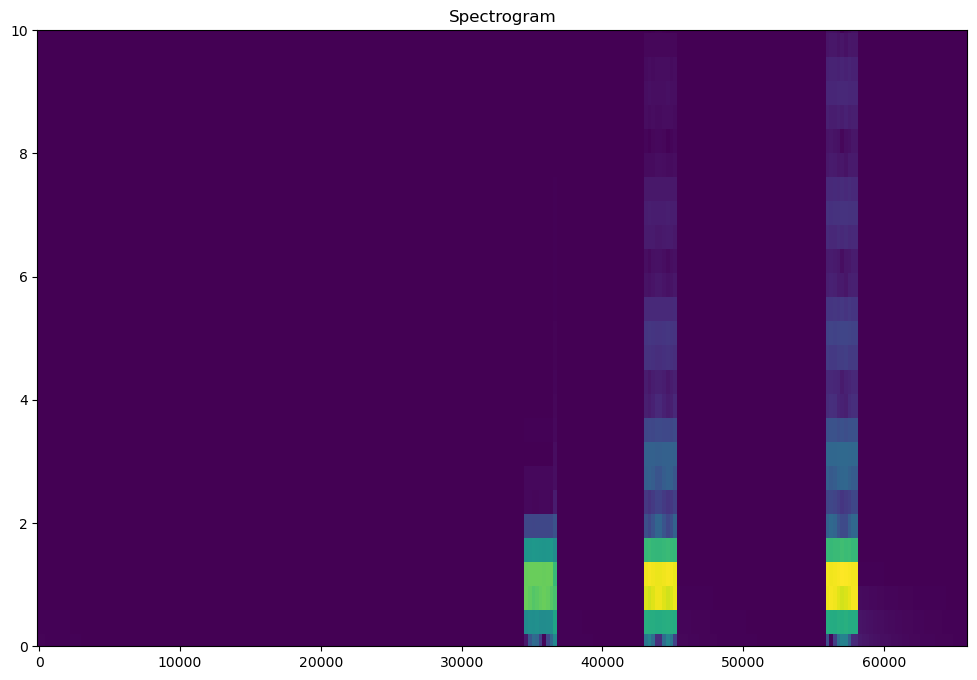

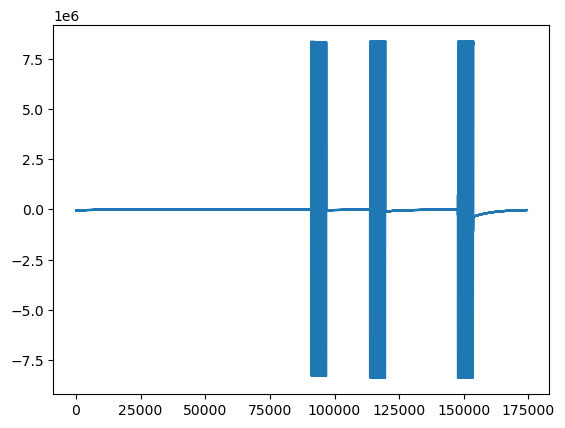

In [98]:
#Function that calcualtes the spectrogram of a waveform and returns it. 
def get_plot_spectrogram(waveform):
  tensor = tf.constant(waveform)
  # Convert the waveform to a spectrogram via a STFT.
  frame_lengthC,frame_stepC = get_right_params(waveform)
  spectrogram = tf.signal.stft(
      tensor, frame_length=frame_lengthC, frame_step=frame_stepC)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram, frame_lengthC

waveform = read('Hoover_cals/HooverCals/Atlogger/HOVR6/ENZ.D/347/LE.HOVR6.52.ENZ.D.2022.347.20')
waveform = float32(waveform[0].data)
spectrogram,fl = get_plot_spectrogram(waveform)
print(spectrogram.shape)

fig, axes = plt.subplots(1, figsize=(12, 8))

plot_spectrogram(spectrogram.numpy(), axes,fl)
axes.set_title('Spectrogram')
plt.show()
plt.plot(waveform)
plt.show()

In [6]:
#Import Neccessary Libraries
import obspy as ob
from scipy import signal
from obspy import read
from os import fsencode as fse
from os import fsdecode as fsd
from os import listdir as ld
from obspy.core import Trace,Stream
from obspy.signal.invsim import cosine_taper
import matplotlib.pyplot as plt
import numpy as np
from cmath import exp
import math
from matplotlib.ticker import ScalarFormatter
#This is a function we will utilize during the fourier transform section later on
def abs2(x):
    return x.real**2 + x.imag**2
from numpy import float16
import pandas as pd
from numpy import mean, sqrt, square, arange
from obspy.signal.cross_correlation import correlate, xcorr_max
from obspy.signal.filter import envelope
from obspy.signal.util import smooth
import plotly
import plotly.express as px

## The below functions are just a method of obtaining a large pool of data to construct into training data. Please refer to https://nbviewer.org/github/LM2025/HooverDamProject/blob/main/HOVR_project.ipynb for more information.

HOVR
1 Trace(s) in Stream:
LE.HOVR.30.EN1 | 2022-12-13T19:56:32.160000Z - 2022-12-13T20:00:00.465000Z | 200.0 Hz, 41662 samples
1 Trace(s) in Stream:
LE.HOVR.30.EN1 | 2022-12-13T20:00:00.470000Z - 2022-12-13T20:09:54.180000Z | 200.0 Hz, 118743 samples


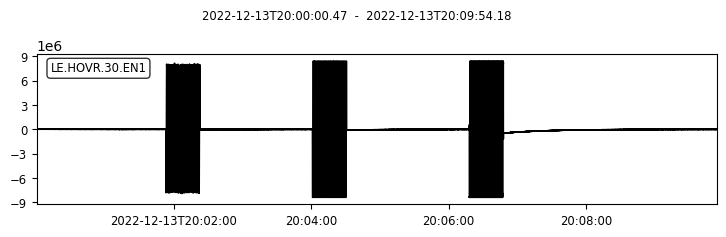

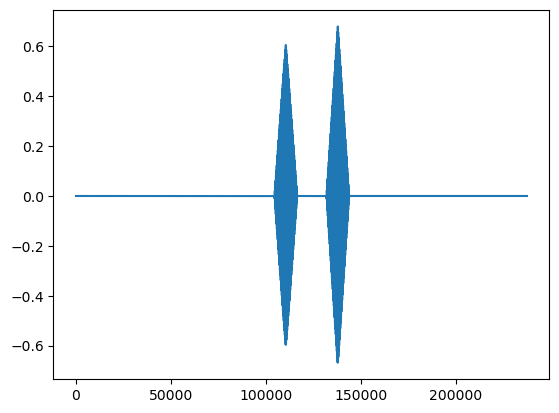

Shift and correlation values: 19135 0.6796494501744231


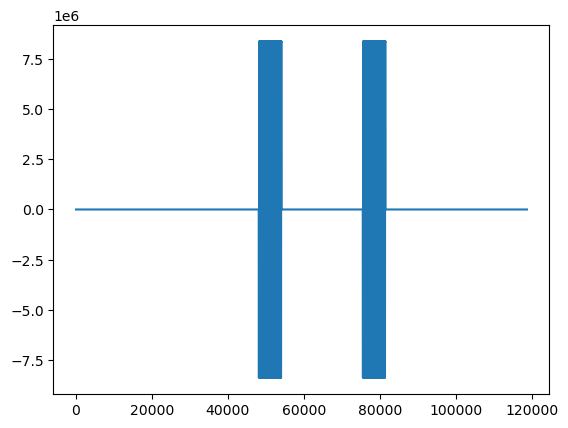

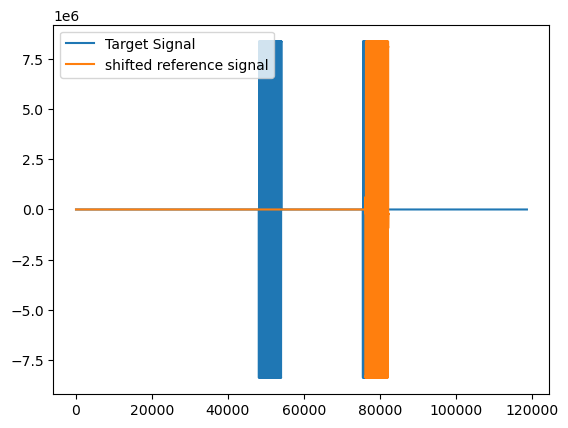

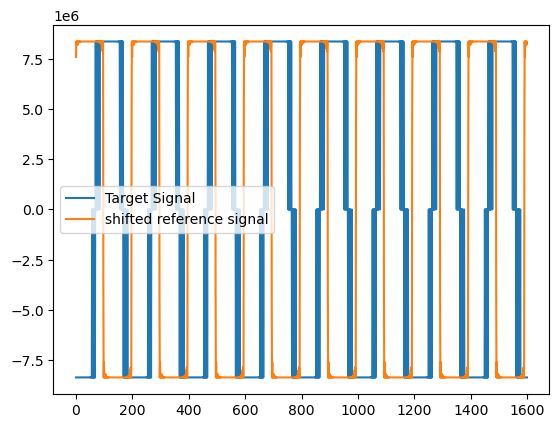

1 Trace(s) in Stream:
LE.HOVR.30.EN2 | 2022-12-13T19:56:32.350000Z - 2022-12-13T20:00:00.210000Z | 200.0 Hz, 41573 samples
1 Trace(s) in Stream:
LE.HOVR.30.EN2 | 2022-12-13T20:00:00.215000Z - 2022-12-13T20:09:54.260000Z | 200.0 Hz, 118810 samples


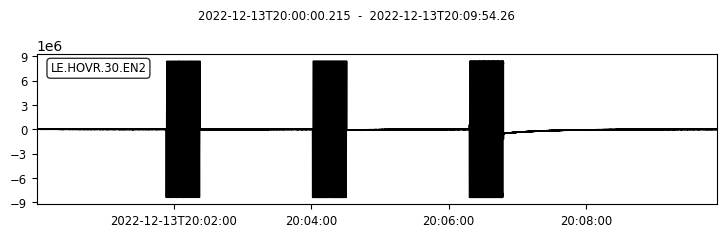

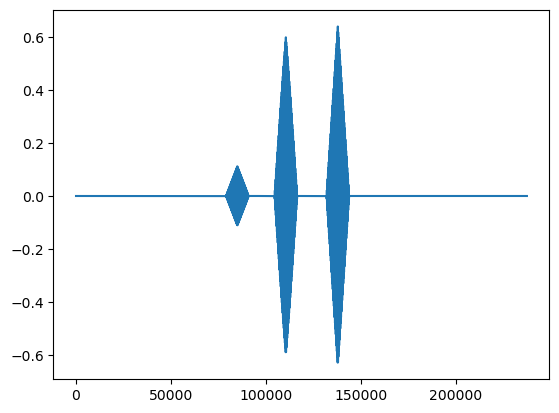

Shift and correlation values: 19152.5 0.6392614536566439


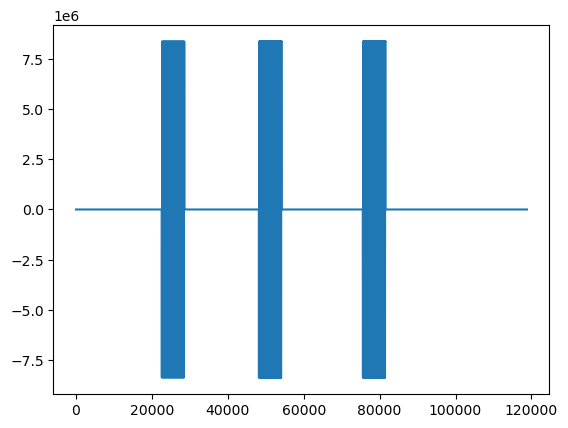

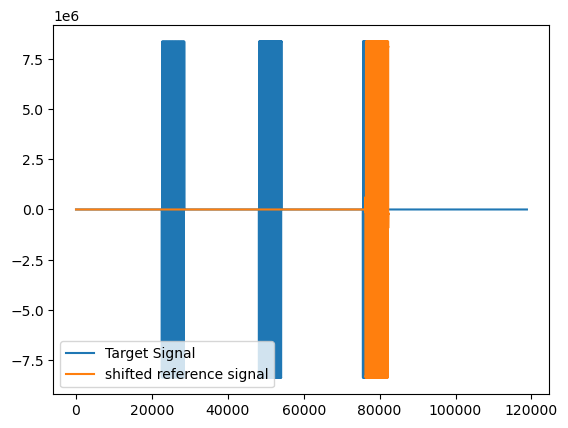

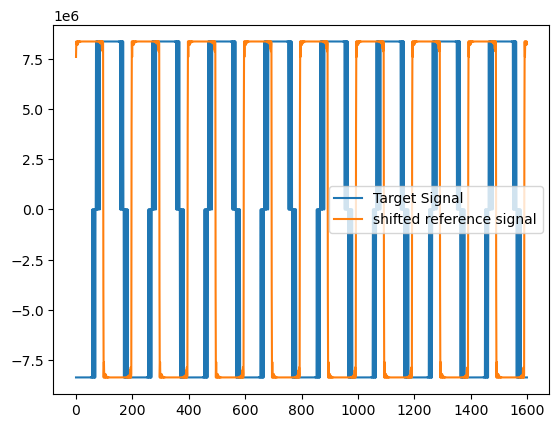

1 Trace(s) in Stream:
LE.HOVR.30.ENZ | 2022-12-13T19:56:32.105000Z - 2022-12-13T20:00:00.670000Z | 200.0 Hz, 41714 samples
1 Trace(s) in Stream:
LE.HOVR.30.ENZ | 2022-12-13T20:00:00.675000Z - 2022-12-13T20:09:53.840000Z | 200.0 Hz, 118634 samples


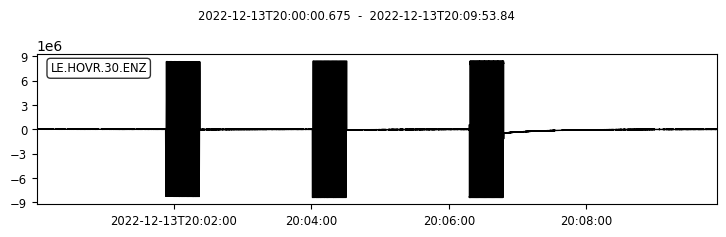

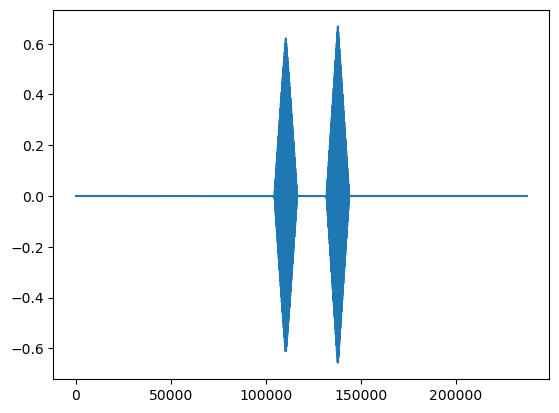

Shift and correlation values: 19148.5 0.6678242710545961


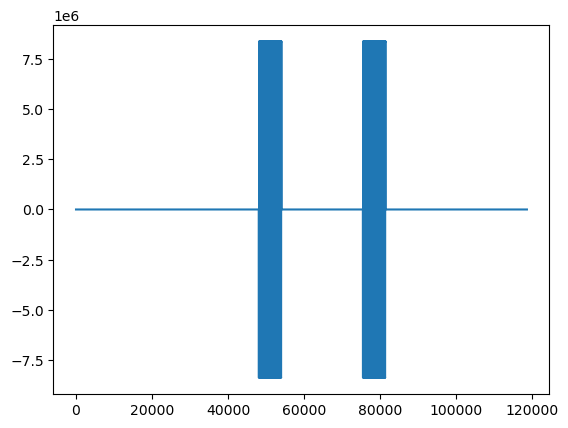

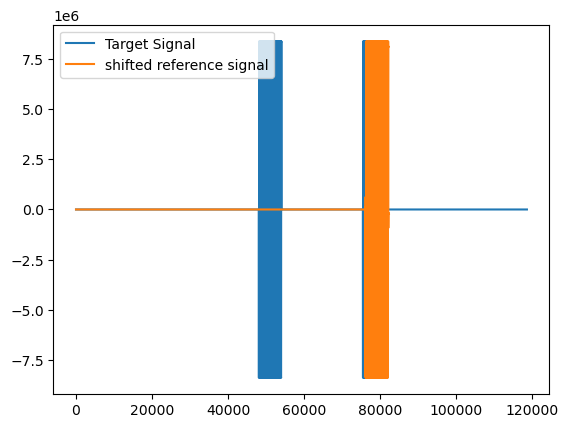

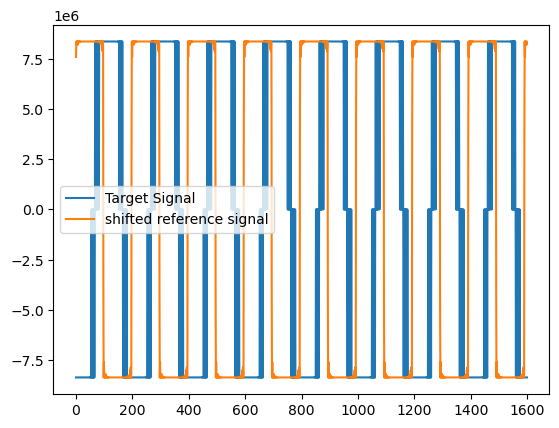

HOVR1
1 Trace(s) in Stream:
LE.HOVR1.40.EN1 | 2022-12-13T21:31:54.215000Z - 2022-12-13T21:43:43.075000Z | 200.0 Hz, 141773 samples


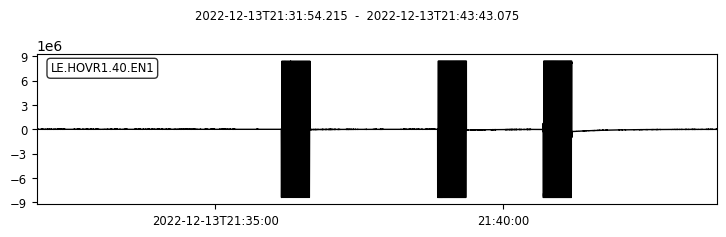

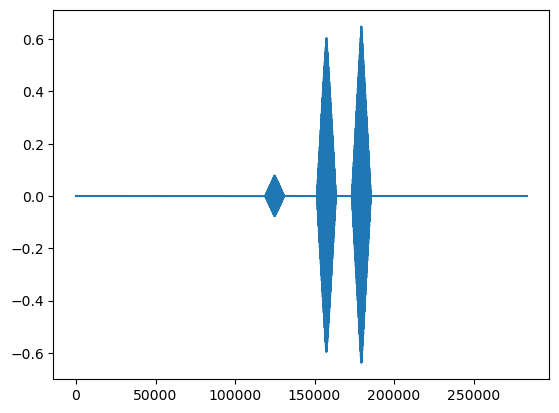

Shift and correlation values: 37671 0.6483909905187837


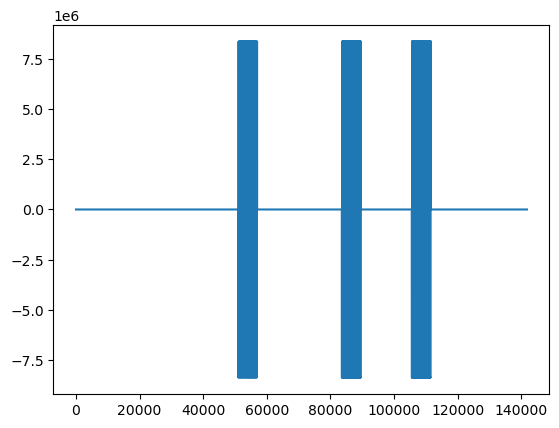

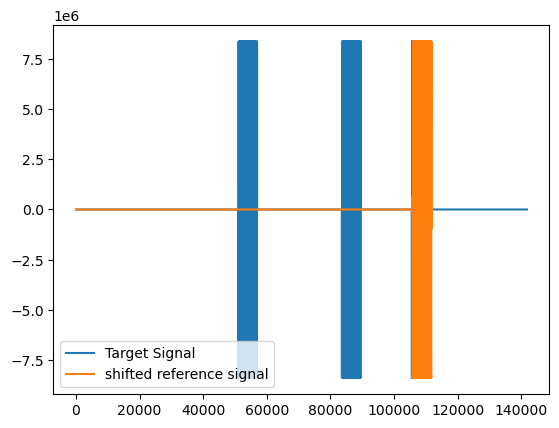

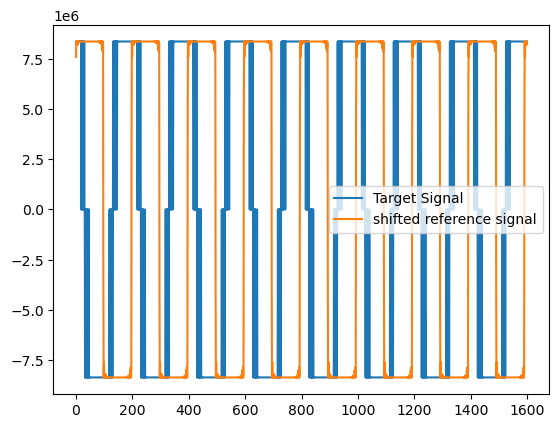

1 Trace(s) in Stream:
LE.HOVR1.40.EN2 | 2022-12-13T21:31:54.250000Z - 2022-12-13T21:43:43.050000Z | 200.0 Hz, 141761 samples


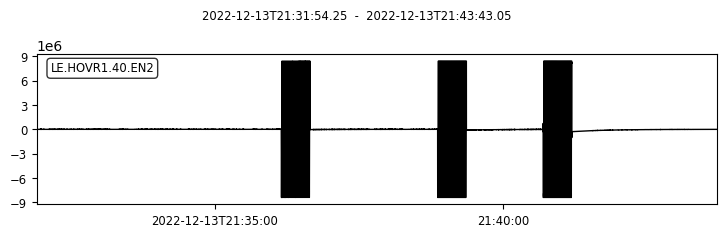

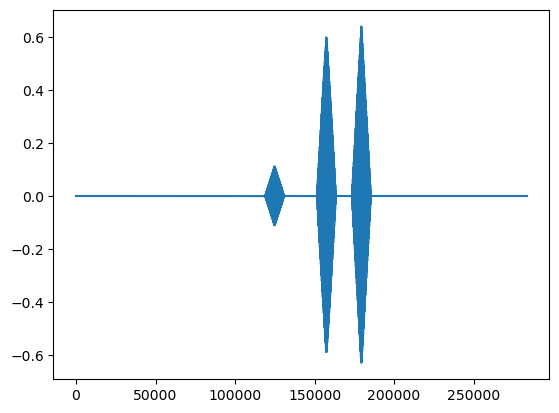

Shift and correlation values: 37670 0.6395353435446326


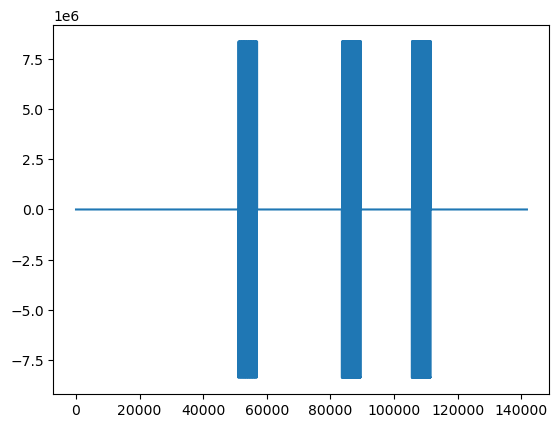

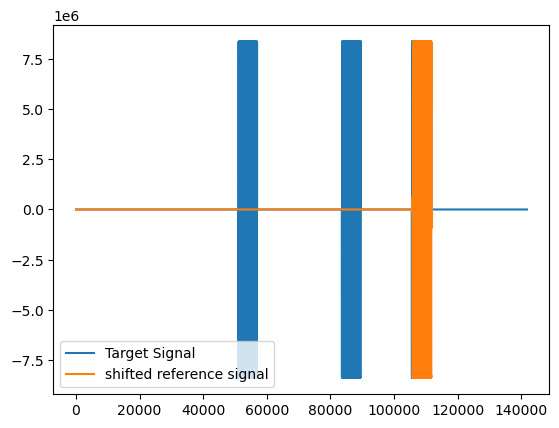

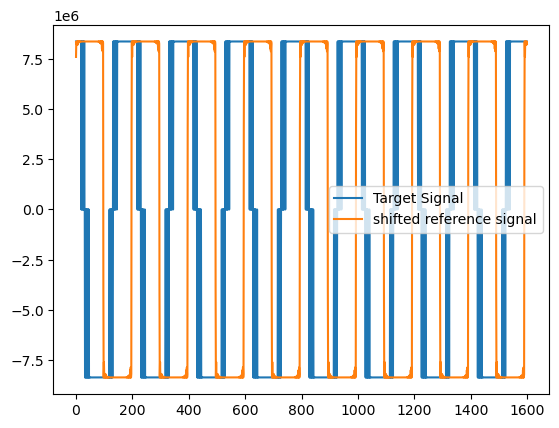

1 Trace(s) in Stream:
LE.HOVR1.40.ENZ | 2022-12-13T21:31:54.195000Z - 2022-12-13T21:43:43.255000Z | 200.0 Hz, 141813 samples


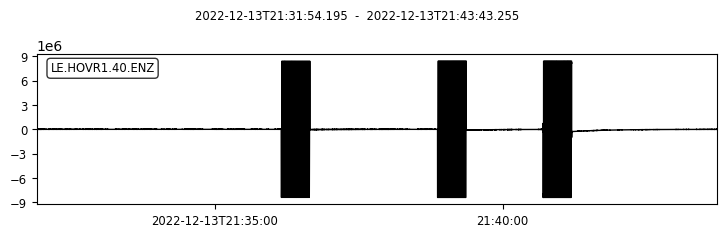

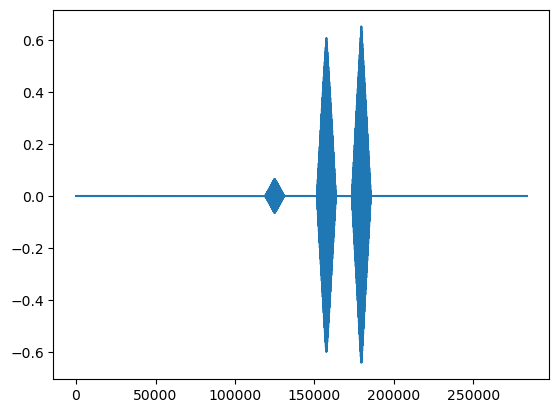

Shift and correlation values: 37655 0.6514122024366649


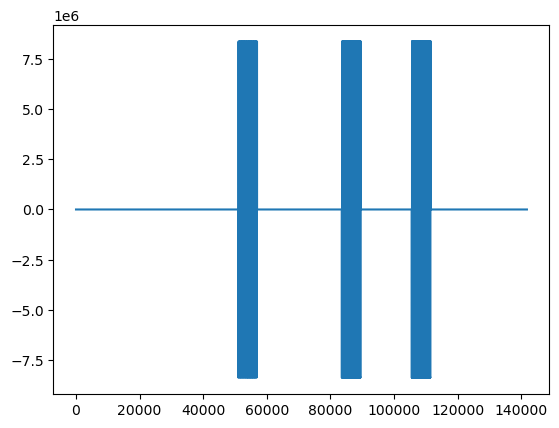

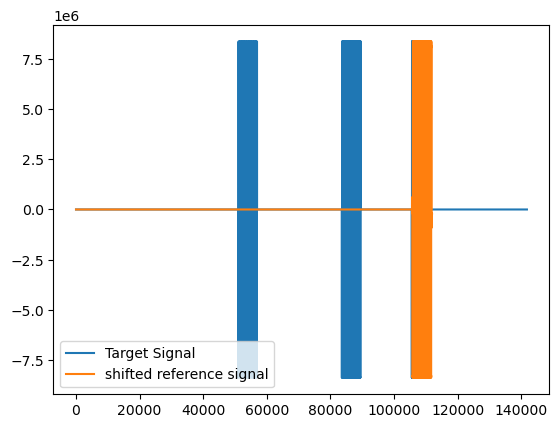

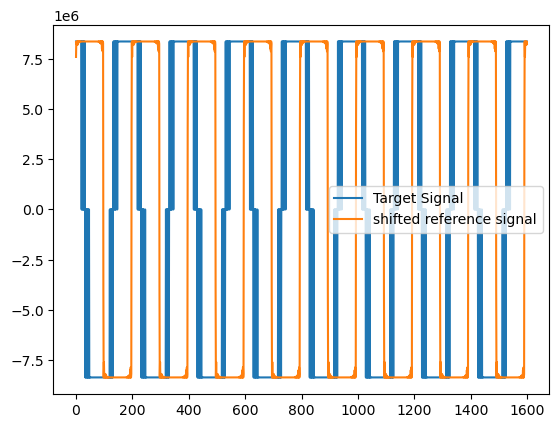

HOVR2
1 Trace(s) in Stream:
LE.HOVR2.11.EN1 | 2022-12-13T21:50:15.150000Z - 2022-12-13T22:00:00.160000Z | 200.0 Hz, 117003 samples
1 Trace(s) in Stream:
LE.HOVR2.11.EN1 | 2022-12-13T22:00:00.165000Z - 2022-12-13T22:00:55.780000Z | 200.0 Hz, 11124 samples
1 Trace(s) in Stream:
LE.HOVR2.11.EN2 | 2022-12-13T21:50:15.150000Z - 2022-12-13T22:00:00.030000Z | 200.0 Hz, 116977 samples
1 Trace(s) in Stream:
LE.HOVR2.11.EN2 | 2022-12-13T22:00:00.035000Z - 2022-12-13T22:00:55.650000Z | 200.0 Hz, 11124 samples
1 Trace(s) in Stream:
LE.HOVR2.11.ENZ | 2022-12-13T21:50:15.150000Z - 2022-12-13T22:00:00.960000Z | 200.0 Hz, 117163 samples
1 Trace(s) in Stream:
LE.HOVR2.11.ENZ | 2022-12-13T22:00:00.965000Z - 2022-12-13T22:00:55.550000Z | 200.0 Hz, 10918 samples
HOVR3
1 Trace(s) in Stream:
LE.HOVR3.32.EN1 | 2022-12-13T21:14:04.955000Z - 2022-12-13T21:25:20.615000Z | 200.0 Hz, 135133 samples
1 Trace(s) in Stream:
LE.HOVR3.32.EN2 | 2022-12-13T21:14:04.820000Z - 2022-12-13T21:25:20.715000Z | 200.0 Hz, 135180

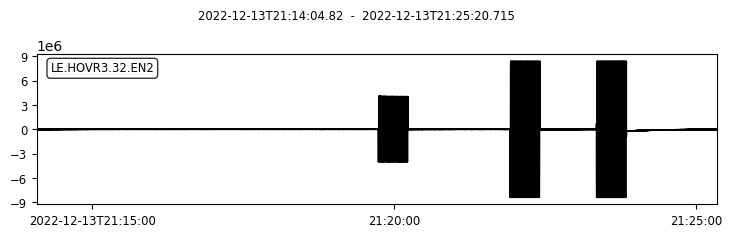

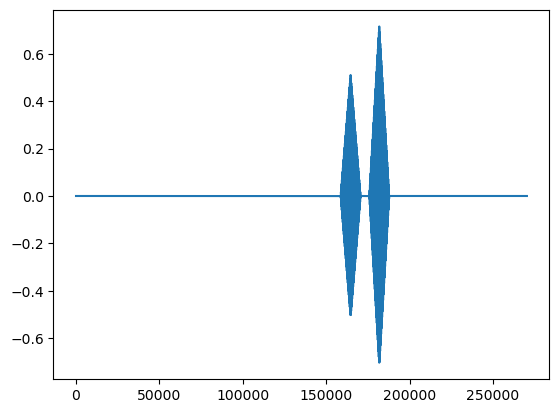

Shift and correlation values: 46646.5 0.7159777450768465


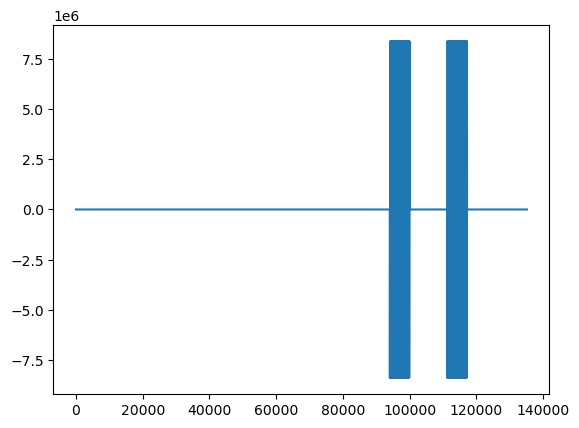

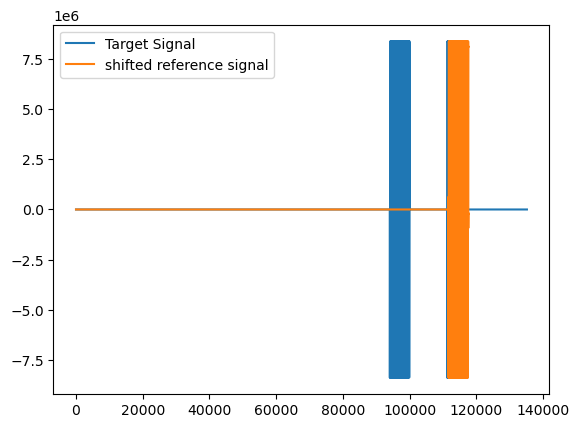

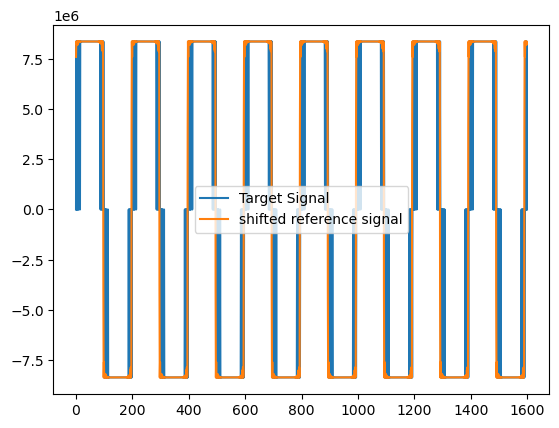

1 Trace(s) in Stream:
LE.HOVR3.32.ENZ | 2022-12-13T21:14:05.080000Z - 2022-12-13T21:25:20.130000Z | 200.0 Hz, 135011 samples


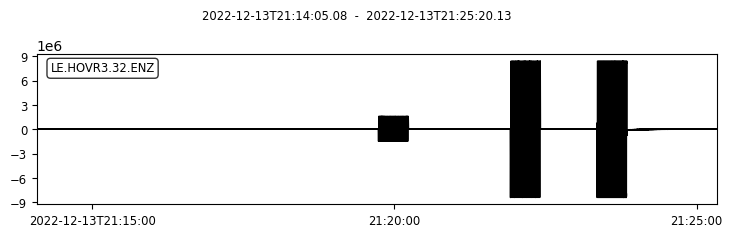

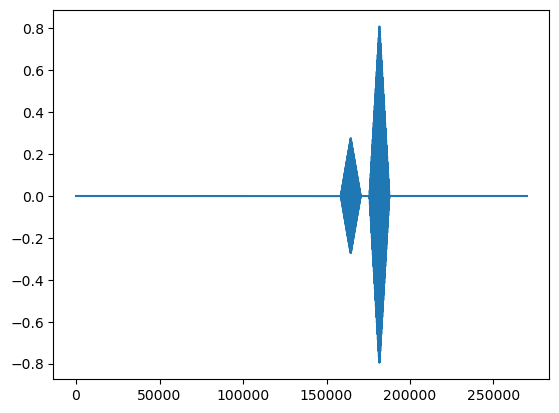

Shift and correlation values: 46679 0.8090582168755724


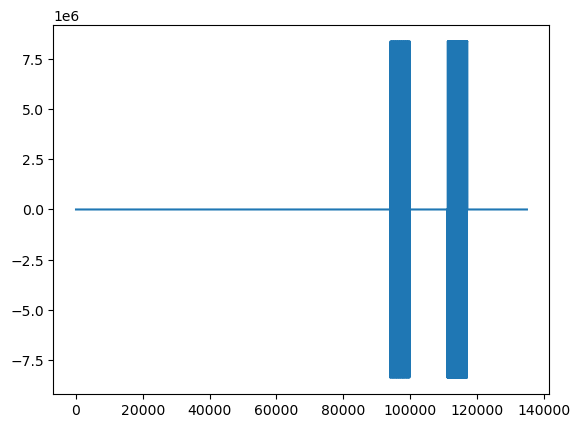

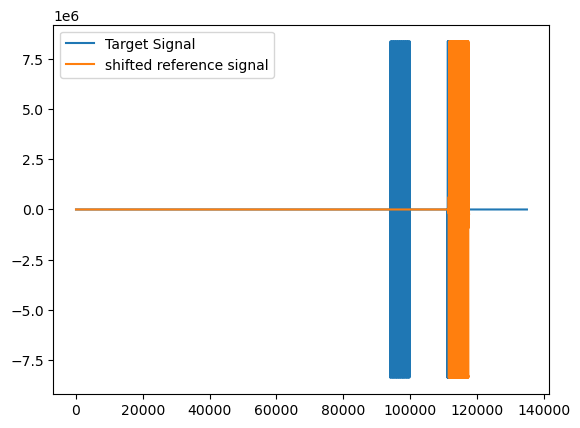

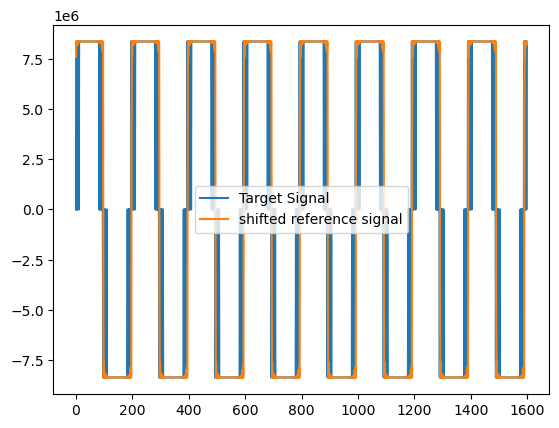

HOVR4
1 Trace(s) in Stream:
LE.HOVR4.42.EN1 | 2022-12-13T22:06:15.330000Z - 2022-12-13T22:24:29.925000Z | 200.0 Hz, 218920 samples


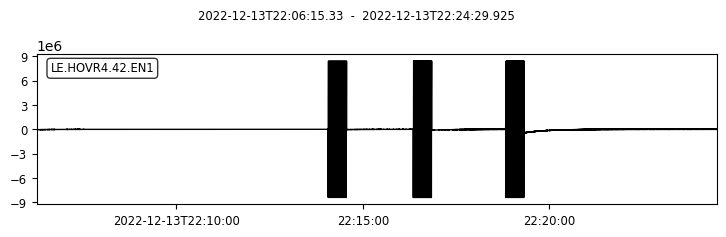

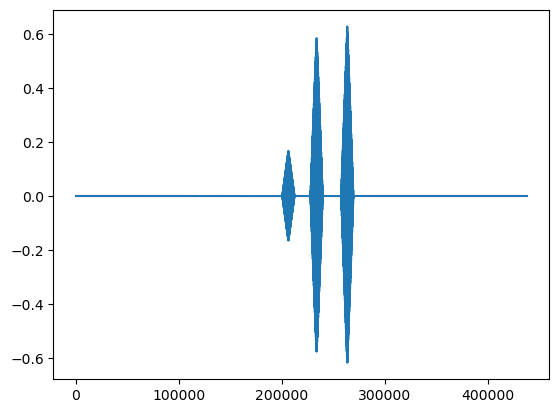

Shift and correlation values: 44474.5 0.6271053253036122


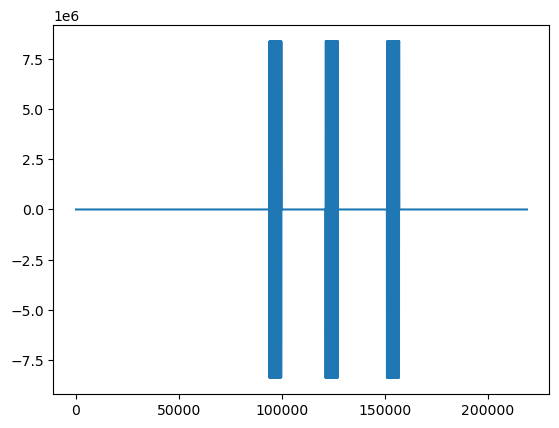

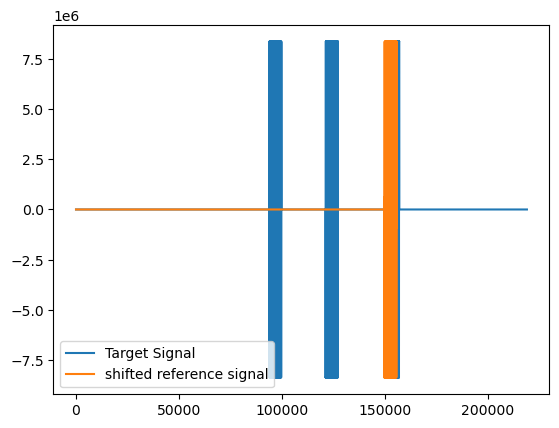

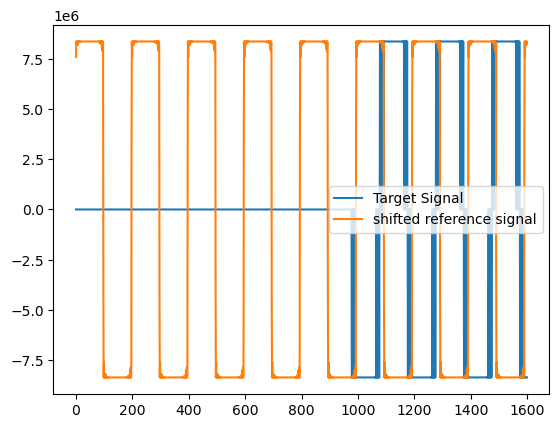

1 Trace(s) in Stream:
LE.HOVR4.42.EN2 | 2022-12-13T22:06:15.355000Z - 2022-12-13T22:24:29.995000Z | 200.0 Hz, 218929 samples


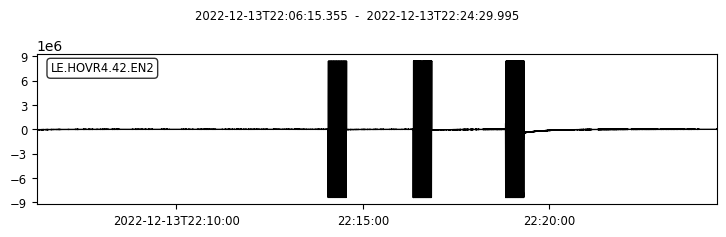

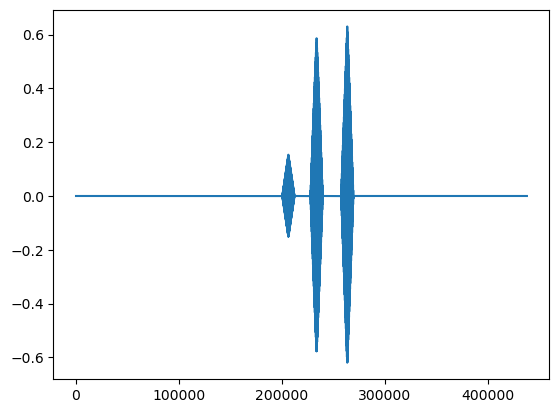

Shift and correlation values: 44465 0.6303089031426067


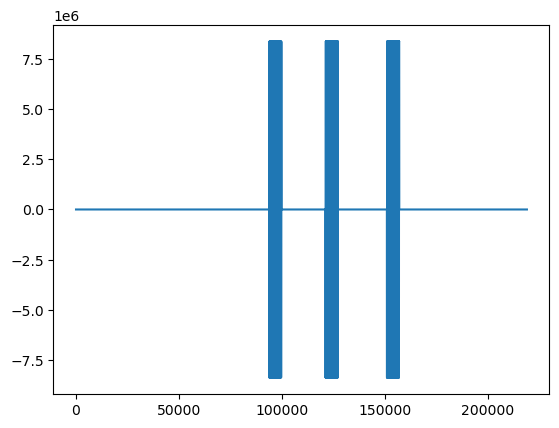

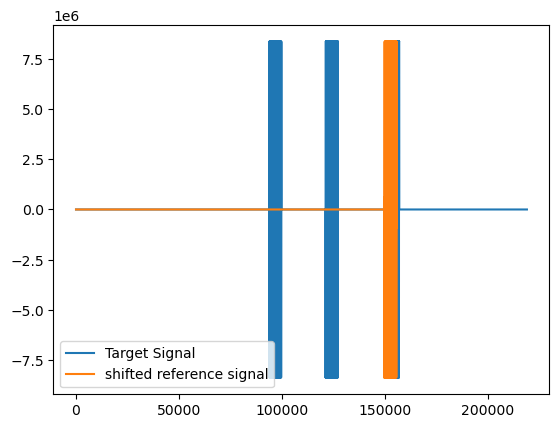

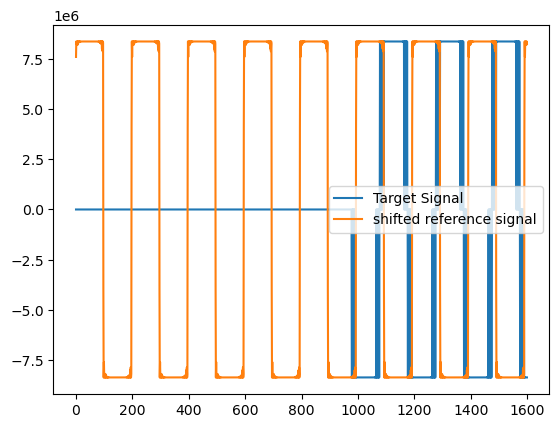

1 Trace(s) in Stream:
LE.HOVR4.42.ENZ | 2022-12-13T22:06:15.410000Z - 2022-12-13T22:24:29.720000Z | 200.0 Hz, 218863 samples


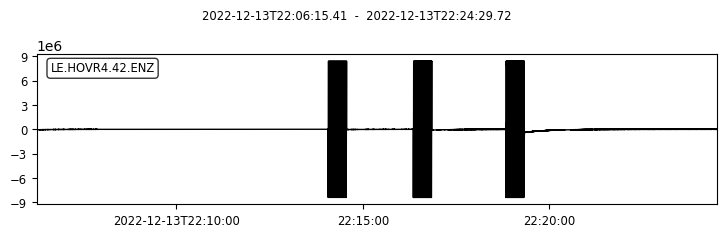

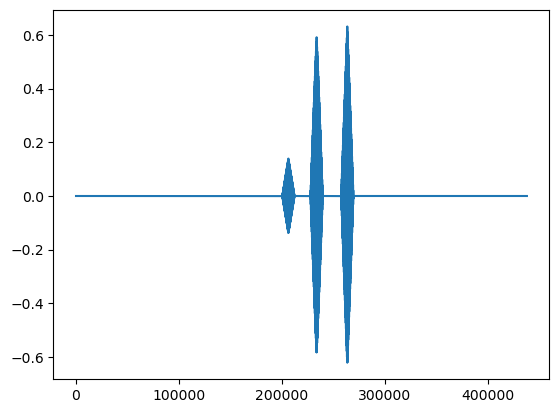

Shift and correlation values: 44487 0.6317262230291755


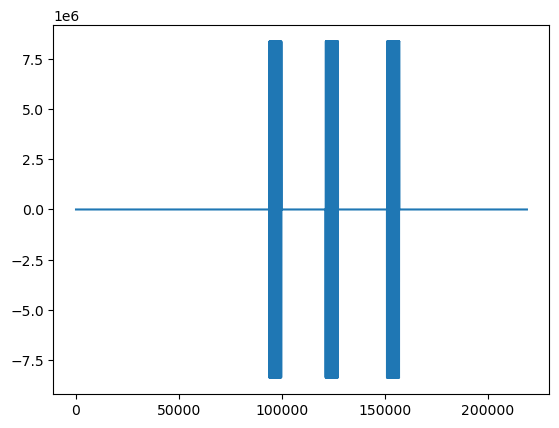

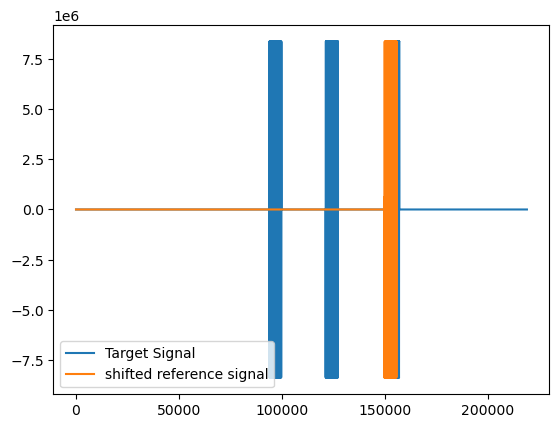

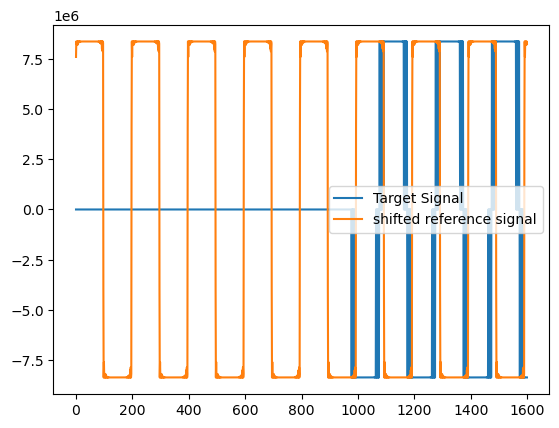

HOVR5
1 Trace(s) in Stream:
LE.HOVR5.50.EN1 | 2022-12-13T20:51:36.500000Z - 2022-12-13T21:00:00.730000Z | 200.0 Hz, 100847 samples


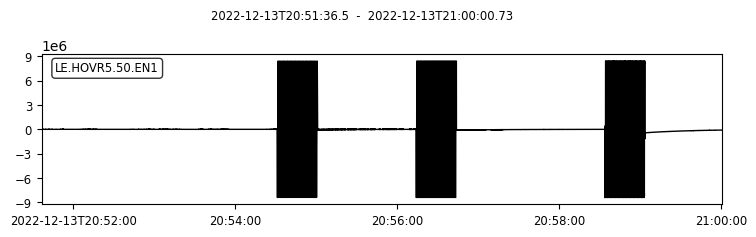

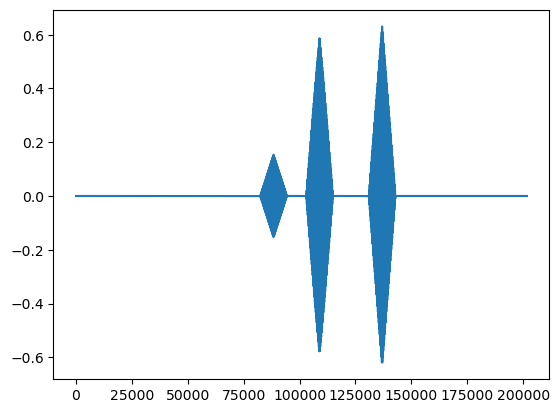

Shift and correlation values: 36077 0.6306579127853164


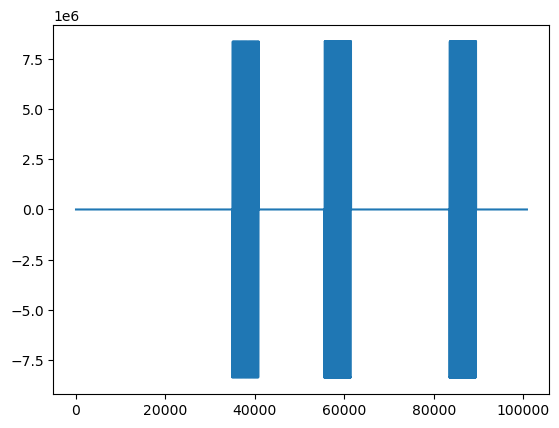

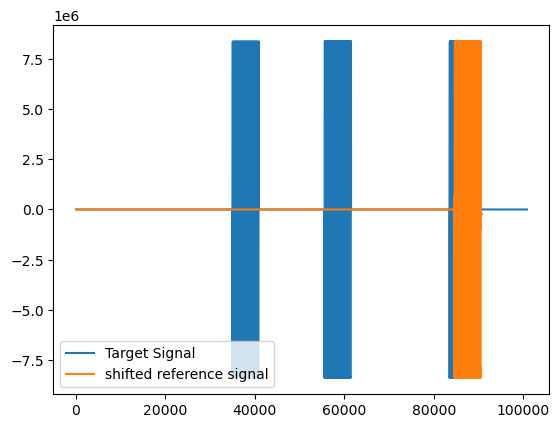

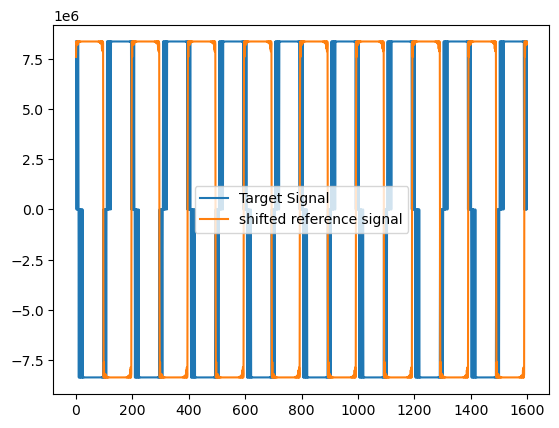

1 Trace(s) in Stream:
LE.HOVR5.50.EN1 | 2022-12-13T21:00:00.735000Z - 2022-12-13T21:01:39.620000Z | 200.0 Hz, 19778 samples
1 Trace(s) in Stream:
LE.HOVR5.50.EN2 | 2022-12-13T20:51:36.515000Z - 2022-12-13T21:00:00.140000Z | 200.0 Hz, 100726 samples


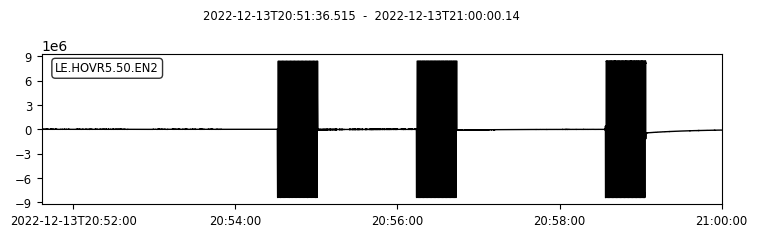

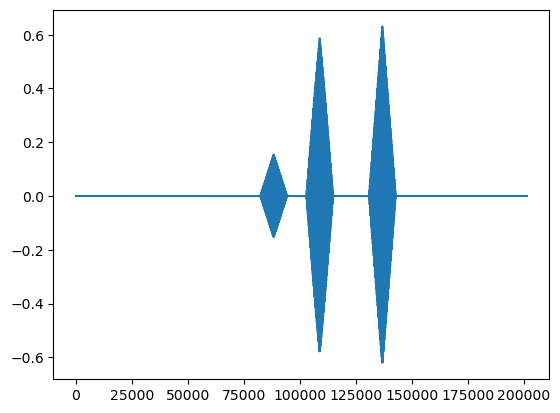

Shift and correlation values: 36134.5 0.6306007150749257


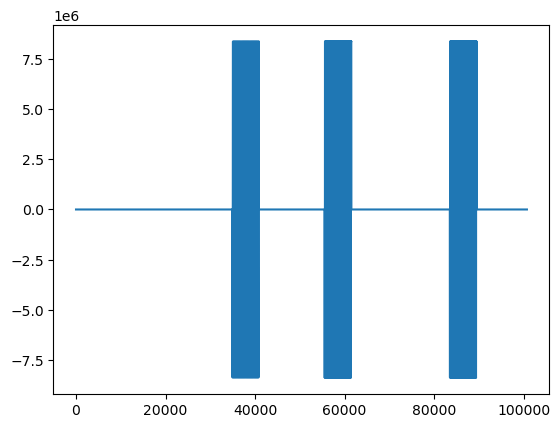

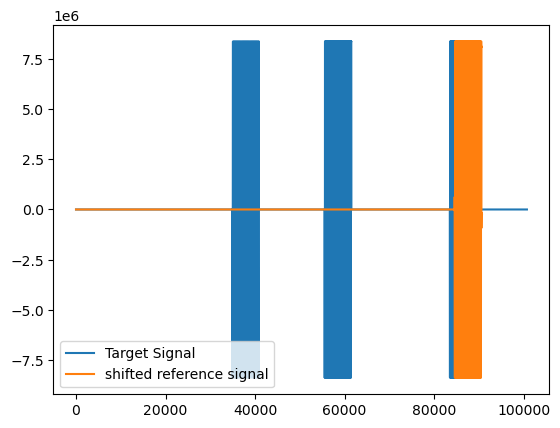

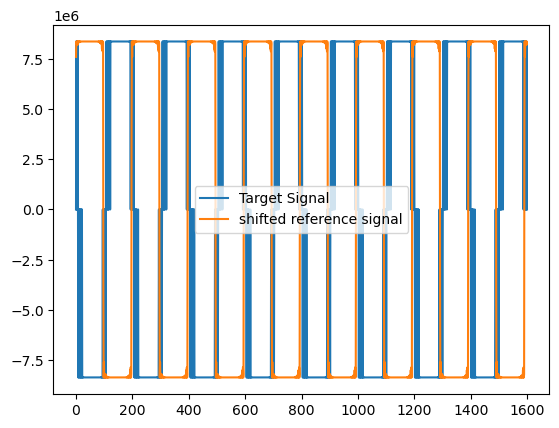

1 Trace(s) in Stream:
LE.HOVR5.50.EN2 | 2022-12-13T21:00:00.145000Z - 2022-12-13T21:01:40.305000Z | 200.0 Hz, 20033 samples
1 Trace(s) in Stream:
LE.HOVR5.50.ENZ | 2022-12-13T20:51:36.520000Z - 2022-12-13T21:00:00.350000Z | 200.0 Hz, 100767 samples


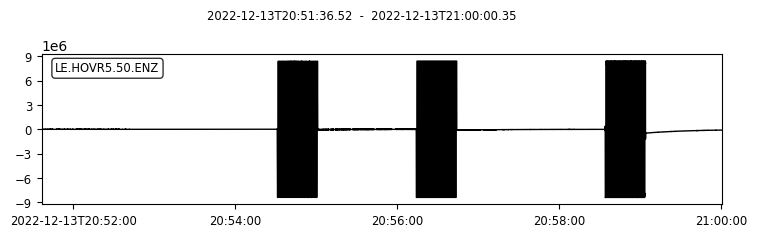

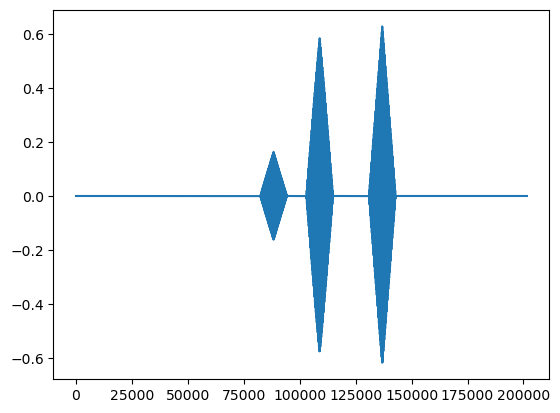

Shift and correlation values: 36113 0.6283879830298844


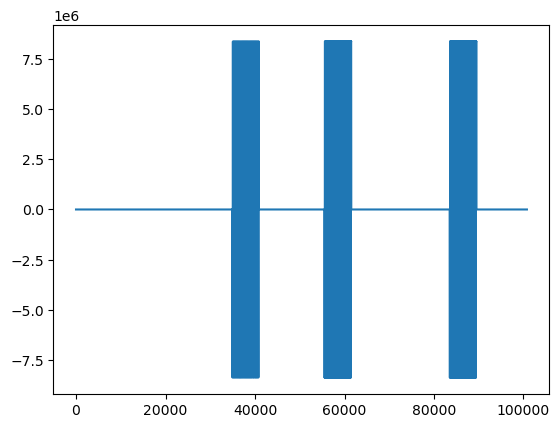

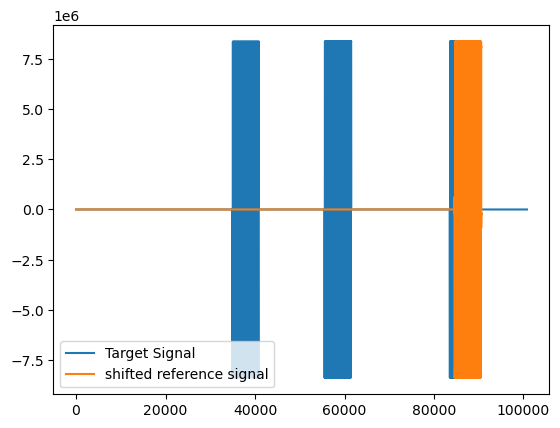

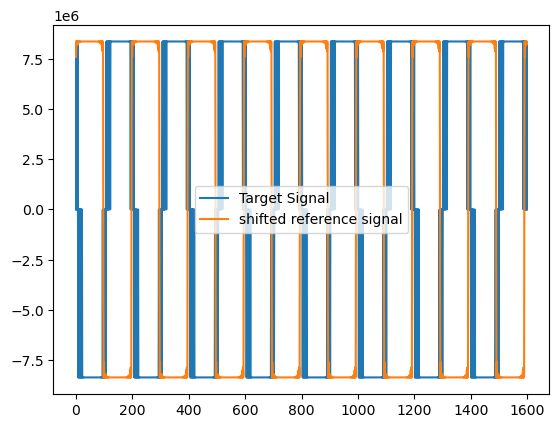

1 Trace(s) in Stream:
LE.HOVR5.50.ENZ | 2022-12-13T21:00:00.355000Z - 2022-12-13T21:01:40.505000Z | 200.0 Hz, 20031 samples
HOVR6
1 Trace(s) in Stream:
LE.HOVR6.52.EN1 | 2022-12-13T20:21:25.460000Z - 2022-12-13T20:35:57.040000Z | 200.0 Hz, 174317 samples


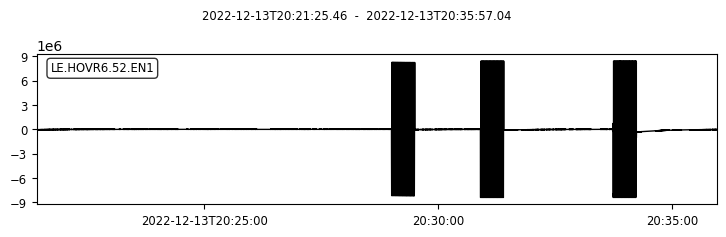

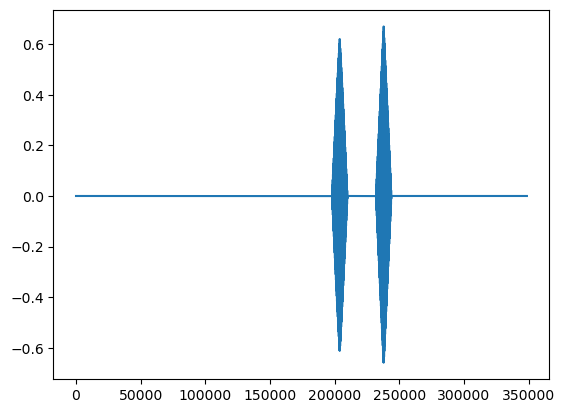

Shift and correlation values: 63550 0.6697844236279927


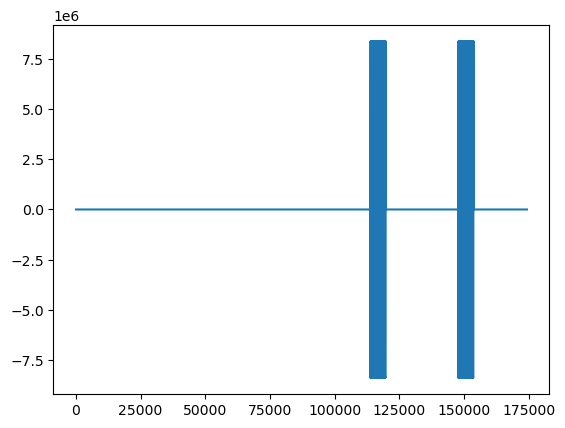

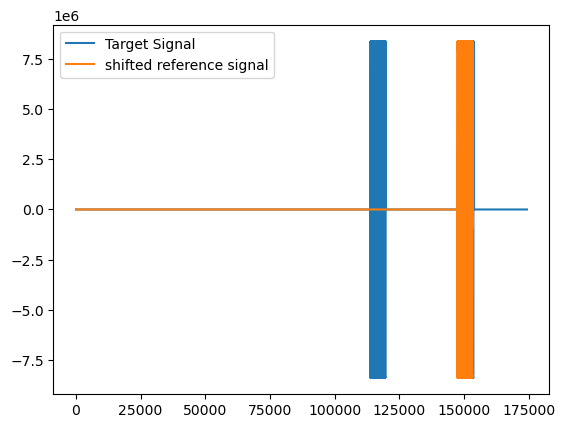

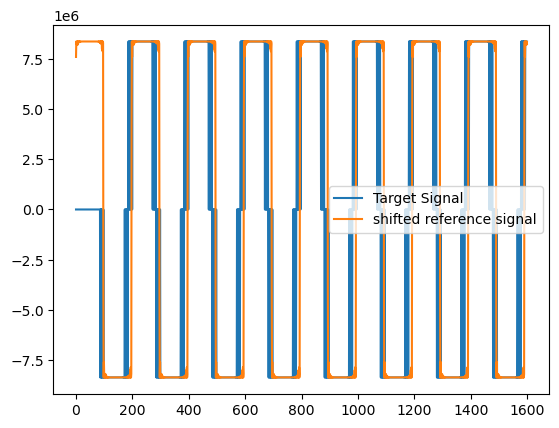

1 Trace(s) in Stream:
LE.HOVR6.52.EN2 | 2022-12-13T20:21:25.485000Z - 2022-12-13T20:35:57.475000Z | 200.0 Hz, 174399 samples


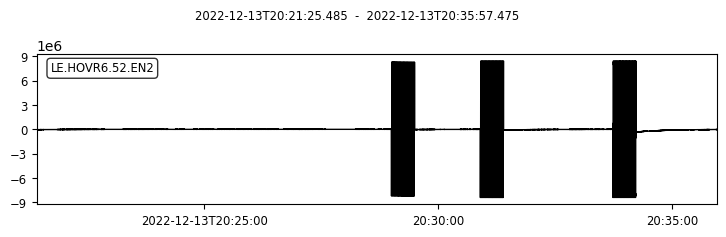

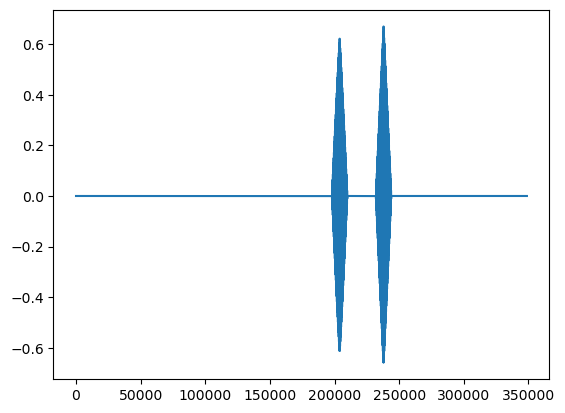

Shift and correlation values: 63504 0.6694515094164765


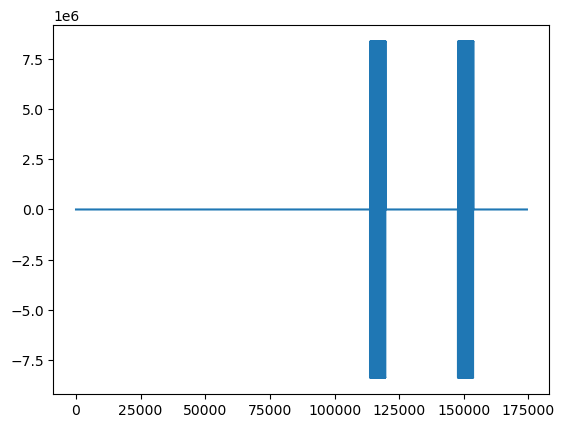

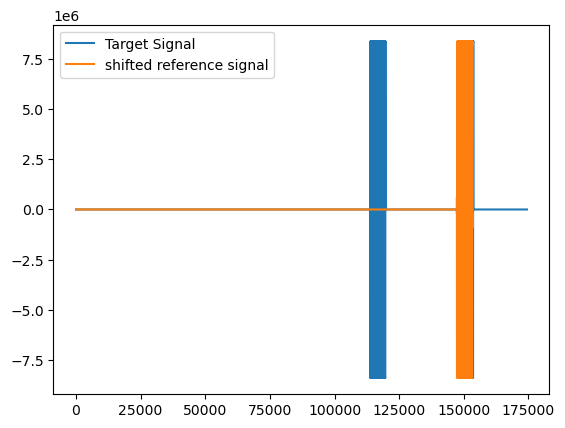

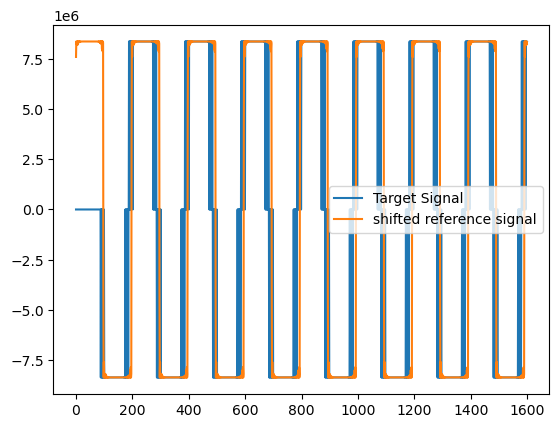

1 Trace(s) in Stream:
LE.HOVR6.52.ENZ | 2022-12-13T20:21:25.505000Z - 2022-12-13T20:35:57.695000Z | 200.0 Hz, 174439 samples


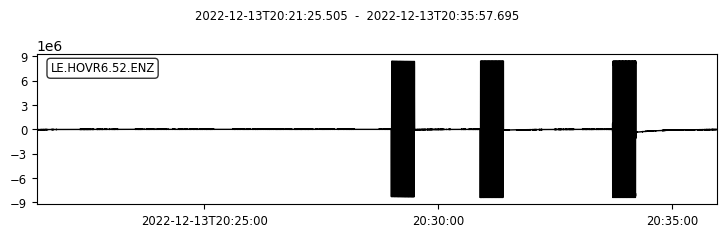

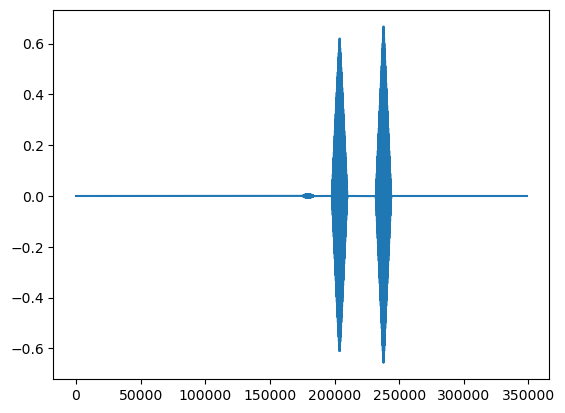

Shift and correlation values: 63480 0.6671661170306001


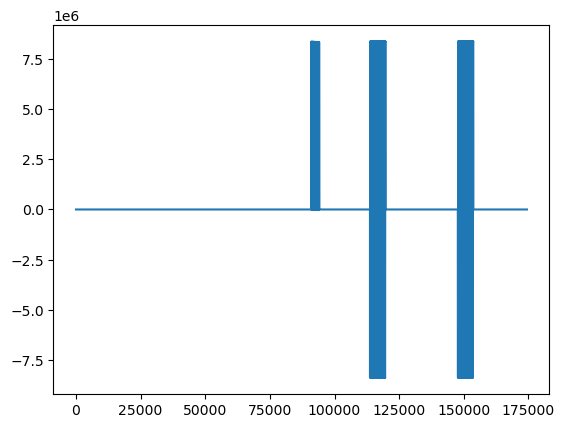

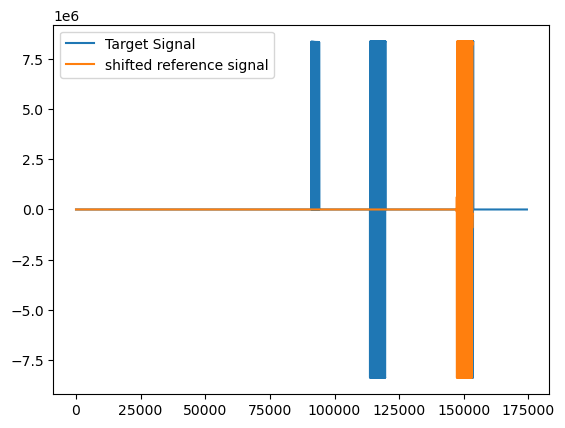

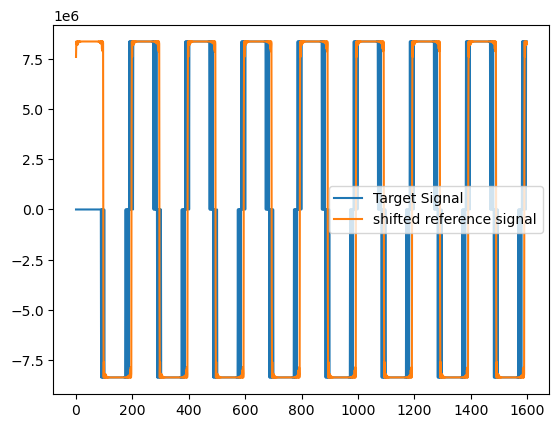

In [7]:
def get_atlogger_references():
    #Encode the top directory 
    directory = fse('Hoover_cals/HooverCals/Atlogger/')
    #Make three reference streams that will be used for cross correlation
    reference = read('calibration_waveforms\LB.HOVR.30.EN1.square.sac')
    reference2 = read('calibration_waveforms\LB.HOVR.30.EN2.square.sac')
    reference3 = read('calibration_waveforms\LB.HOVR.30.ENZ.square.sac')
    reference_correlate_list = [reference[0].data,reference2[0].data,reference3[0].data]
    #List the Files of the Encoded directory
    storage = ld(directory)
    #Make a dictionary that will contain all of the data.
    station_dict = {}
    #Loop through all the entries in the Encoded Directory
    for dir in storage:
        #Decode the directory and encode its contents  
        file = fsd(dir)
        #Print the filename, which in this case is the station ID
        print(file)
        new_dir = fse(f'Hoover_cals/HooverCals/Atlogger/{file}')
        # Create a new list of the directory's encoded sub-directories
        new_storage = ld(new_dir)
        #Create a list that will contain all the data for a given station
        channel_list = []
        i = -1
        #Loop through the encoded contents of the most recently decoded directory
        for dir2 in new_storage:
            #Decode the most recently encoded directory. A pattern is Emerging here. Essentially, we follow this 
            #convention of encoding and decoding the filesystem until we reach all the sac files at the bottom 
            #of the Directory Tree. 
            file2 = fsd(dir2)
            #For this project, we are only concerned with all the EN* stations on Hoover, so all HN* stations will be ingored. 
            if file2[0] != 'E':
                continue
            new_dir2 = fse(f'Hoover_cals/HooverCals/Atlogger/{file}/{file2}')
            new_storage2 = ld(new_dir2)
            i+=1
            #Loop through the encoded contents of the recently decoded directory. 
            for dir3 in new_storage2:
                file3 = fsd(dir3)
                new_dir3 = fse(f'Hoover_cals/HooverCals/Atlogger/{file}/{file2}/{file3}')
                new_storage3 = ld(new_dir3)
                #We have finally reached the sac files we want to work with. Let's perform some operations 
                for sac_file in new_storage3:
                    #Read in the data stream from the sac file using Obspy 
                    sac_obs = fsd(sac_file)
                    st = read(f'Hoover_cals/HooverCals/Atlogger/{file}/{file2}/{file3}/{sac_obs}')
                    #print the stream information, and loop through it if it contains more than one trace
                    print(st)
                    if len(st) != 1:
                        dominant_trace = st[0]
                        #Compare the Root-Mean_squared values of the traces. We do this to extract the trace with the 'most' 
                        #data in it to make our results accurate
                        for tr in st[1:]:
                            if sqrt(mean(square(tr.data))) > sqrt(mean(square(dominant_trace.data))):
                                dominant_trace = tr
                        #Retrieve the data of the dominant trace, establish a threshold, and perform amplitude filtering. 
                        info = dominant_trace.data
                        threshold = np.max(info) - 30000
                        good_info = np.where(np.abs(info) >= threshold, info, info*0)
                        #Cross correlate a reference signal reference waveform. This will make an array with correlation constants.
                        cc = correlate(good_info,reference_correlate_list[i],len(good_info))
                    else:
                        #Same process, but no need to loop through a single-trace stream. 
                        dominant_trace = st[0]
                        info = dominant_trace.data
                        threshold = np.max(info) - 30000
                        good_info = np.where(np.abs(info) >= threshold, info, info*0)
                        x = np.arange(0,len(info))
                        cc = correlate(good_info,reference_correlate_list[i],len(good_info))
                    #We only want to move forward if the correlation is at least a little strong. Any stations/channels 
                    #that do not make the correlation threshold wont't be included. 
                    if np.max(cc) > 0.1:
                        #Plot the dominant trace to display station and channel ID. 
                        dominant_trace.plot()
                        #Plot the correlation coefficients. 
                        plt.plot(np.arange(0,len(cc)),cc)
                        plt.show()
                        #Find the shift value and max correlation value of the waveforms, and print them out. 
                        shift,correlation_value = xcorr_max(cc)
                        print('Shift and correlation values:',shift,correlation_value)
                        # We found emperically that the shift alone is not enough to align a lot of the waveforms. 
                        # So we will have to make an add on 
                        # Based on the length of the original data array and the correlation array. 
                        if len(info) < 1e5:
                            add_on = len(cc)*0.2153
                        else:
                            add_on = len(cc)*0.24
                        #Make an alignment waveform based on the add_on parameter
                        check = np.concatenate((np.zeros(np.abs(int(shift+add_on))),reference_correlate_list[i]))
                        #Plot the data array by itself, and then along with the alignment waveform. 
                        plt.plot(good_info)
                        plt.show()
                        plt.plot(good_info)
                        plt.plot(check)
                        plt.legend(['Target Signal','shifted reference signal'])
                        plt.show()
                        #Based on the shift value, plot a zoomed in version of the data array and alingment waveform. 
                        if shift > 0:
                            midpoint = check.argmax()
                            plt.plot(good_info[midpoint+200:midpoint+1800])
                            plt.plot(check[midpoint+200:midpoint+1800])
                            plt.legend(['Target Signal','shifted reference signal'])
                            plt.show()
                        else:
                            midpoint = check.argmax()
                            plt.plot(good_info[:midpoint])
                            plt.plot(check[:midpoint])
                            plt.legend(['Target Signal','shifted reference signal'])
                            plt.show()
                        #Save the atlogger waveform to the channel list 
                        channel_list.append(good_info[midpoint+1300:midpoint+4800])
        #Save all the channel lists from a given station to the dictionary. 
        station_dict[f'{file}'] = channel_list
    return(station_dict)
    
station_dict= get_atlogger_references()

2 Trace(s) in Stream:
LB.HOVR.30.EN1 | 2022-12-09T20:52:28.400000Z - 2022-12-09T20:56:41.995000Z | 200.0 Hz, 50720 samples
LB.HOVR.30.EN1 | 2022-12-09T20:57:10.000000Z - 2022-12-09T21:00:00.360000Z | 200.0 Hz, 34073 samples
0.05737709165956857
5 Trace(s) in Stream:
LB.HOVR.30.EN1 | 2022-12-09T21:00:00.365000Z - 2022-12-09T21:02:46.995000Z | 200.0 Hz, 33327 samples
LB.HOVR.30.EN1 | 2022-12-09T21:07:02.000000Z - 2022-12-09T21:10:45.995000Z | 200.0 Hz, 44800 samples
LB.HOVR.30.EN1 | 2022-12-09T21:18:42.000000Z - 2022-12-09T21:19:18.995000Z | 200.0 Hz, 7400 samples
LB.HOVR.30.EN1 | 2022-12-09T21:23:23.000000Z - 2022-12-09T21:24:29.995000Z | 200.0 Hz, 13400 samples
LB.HOVR.30.EN1 | 2022-12-09T21:28:14.000000Z - 2022-12-09T21:34:00.530000Z | 200.0 Hz, 69307 samples
0.03711582364587417
1 Trace(s) in Stream:
LB.HOVR.32.EN1 | 2022-12-12T20:22:50.795000Z - 2022-12-12T20:41:12.595000Z | 200.0 Hz, 220361 samples
0.547962314241332


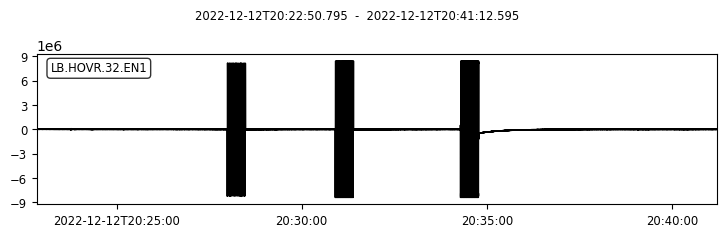

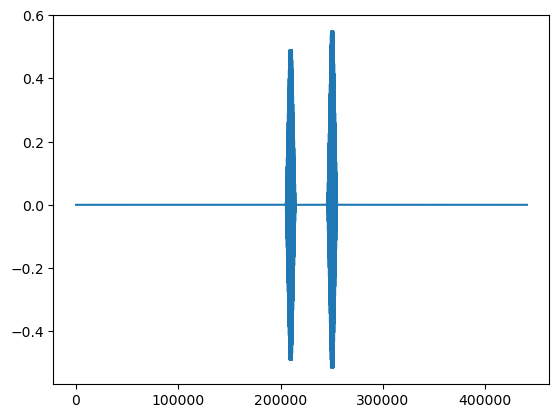

28948.5 0.547962314241332


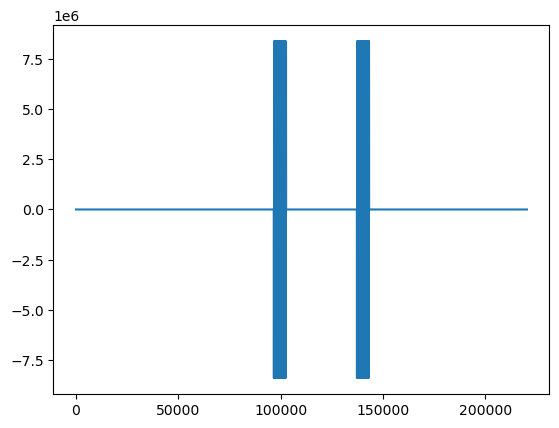

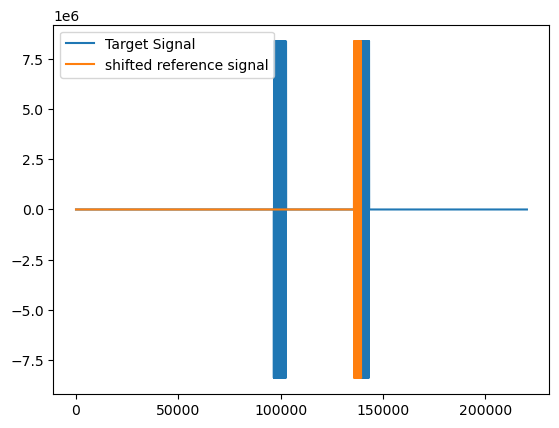

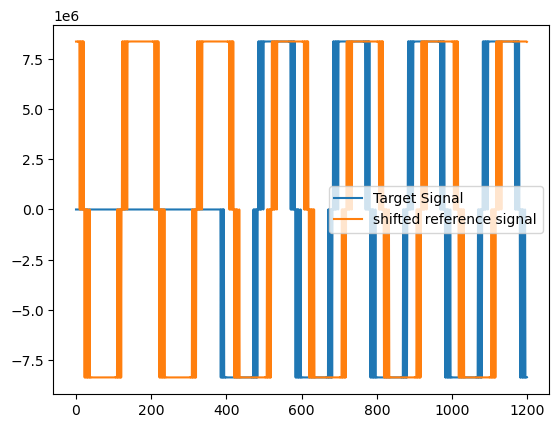

2 Trace(s) in Stream:
LB.HOVR.30.EN2 | 2022-12-09T20:52:28.055000Z - 2022-12-09T20:56:41.995000Z | 200.0 Hz, 50789 samples
LB.HOVR.30.EN2 | 2022-12-09T20:57:10.000000Z - 2022-12-09T21:00:00.660000Z | 200.0 Hz, 34133 samples
0.05717909144097155
5 Trace(s) in Stream:
LB.HOVR.30.EN2 | 2022-12-09T21:00:00.665000Z - 2022-12-09T21:02:46.995000Z | 200.0 Hz, 33267 samples
LB.HOVR.30.EN2 | 2022-12-09T21:07:02.000000Z - 2022-12-09T21:10:45.995000Z | 200.0 Hz, 44800 samples
LB.HOVR.30.EN2 | 2022-12-09T21:18:42.000000Z - 2022-12-09T21:19:18.995000Z | 200.0 Hz, 7400 samples
LB.HOVR.30.EN2 | 2022-12-09T21:23:23.000000Z - 2022-12-09T21:24:29.995000Z | 200.0 Hz, 13400 samples
LB.HOVR.30.EN2 | 2022-12-09T21:28:14.000000Z - 2022-12-09T21:34:00.400000Z | 200.0 Hz, 69281 samples
0.710624407102004


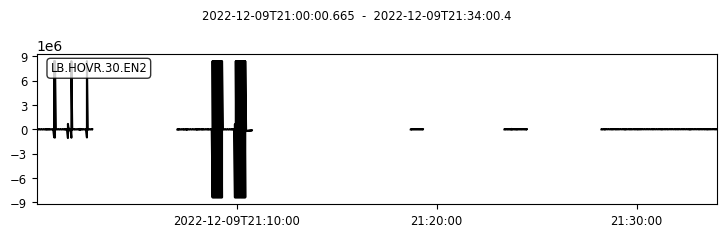

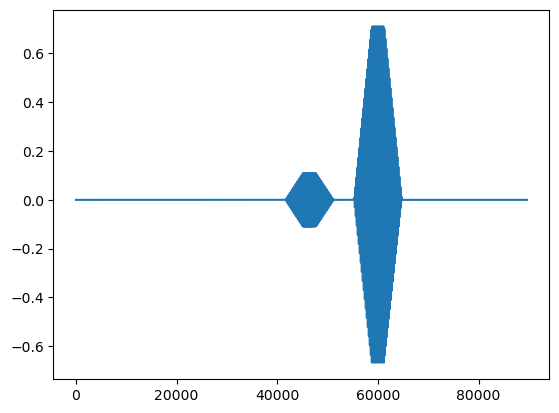

14485 0.710624407102004


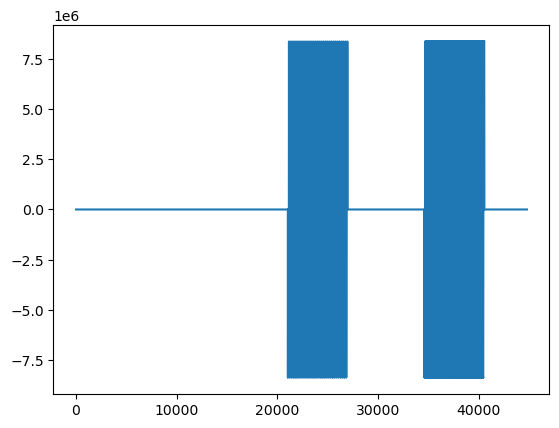

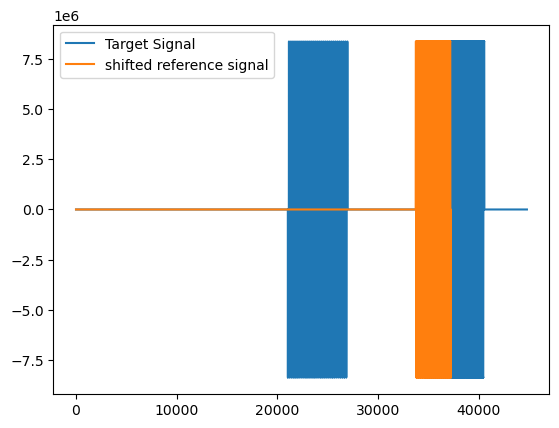

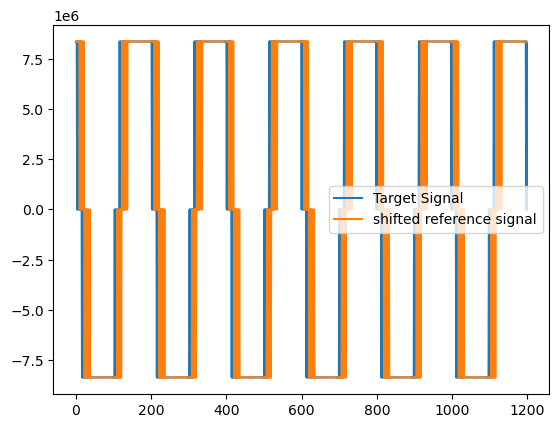

1 Trace(s) in Stream:
LB.HOVR.32.EN2 | 2022-12-12T20:22:50.995000Z - 2022-12-12T20:41:12.860000Z | 200.0 Hz, 220374 samples
0.5176833612865875


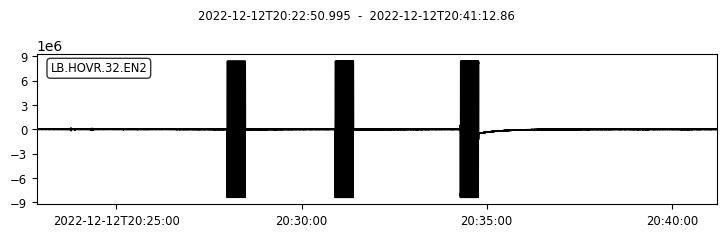

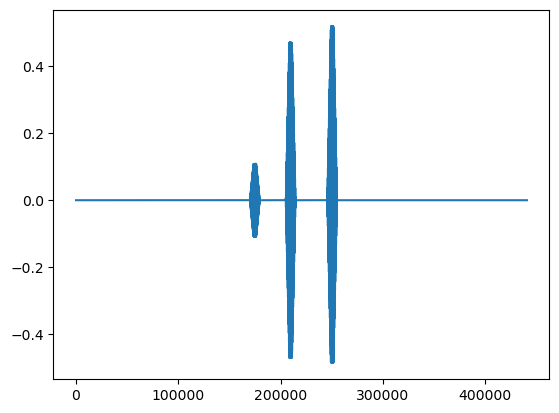

30891 0.5176833612865875


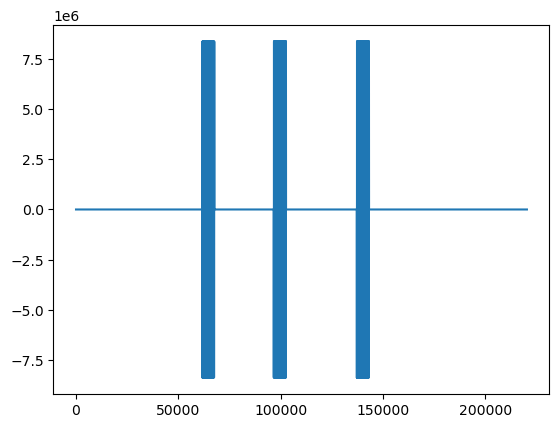

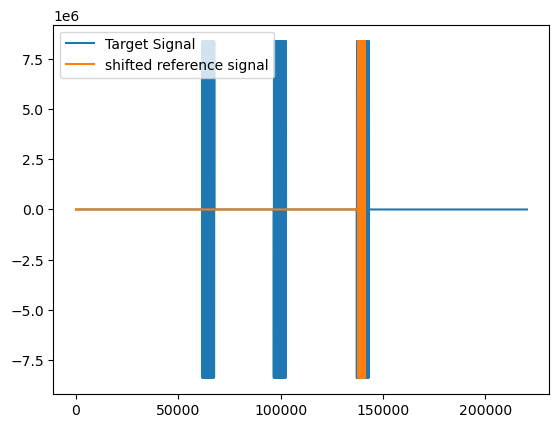

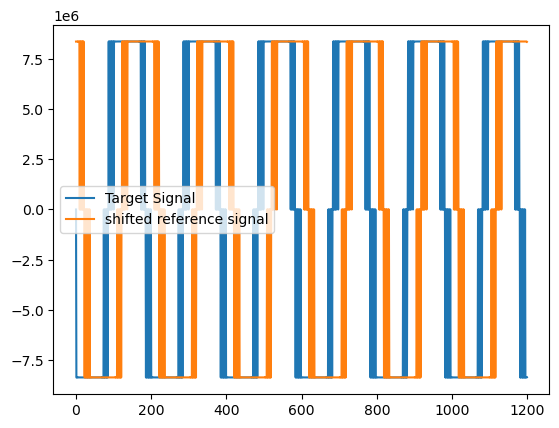

2 Trace(s) in Stream:
LB.HOVR.30.ENZ | 2022-12-09T20:52:28.450000Z - 2022-12-09T20:56:41.995000Z | 200.0 Hz, 50710 samples
LB.HOVR.30.ENZ | 2022-12-09T20:57:10.000000Z - 2022-12-09T21:00:00.225000Z | 200.0 Hz, 34046 samples
0.057354486991582534
5 Trace(s) in Stream:
LB.HOVR.30.ENZ | 2022-12-09T21:00:00.230000Z - 2022-12-09T21:02:46.995000Z | 200.0 Hz, 33354 samples
LB.HOVR.30.ENZ | 2022-12-09T21:07:02.000000Z - 2022-12-09T21:10:45.995000Z | 200.0 Hz, 44800 samples
LB.HOVR.30.ENZ | 2022-12-09T21:18:42.000000Z - 2022-12-09T21:19:18.995000Z | 200.0 Hz, 7400 samples
LB.HOVR.30.ENZ | 2022-12-09T21:23:23.000000Z - 2022-12-09T21:24:29.995000Z | 200.0 Hz, 13400 samples
LB.HOVR.30.ENZ | 2022-12-09T21:28:14.000000Z - 2022-12-09T21:34:01.080000Z | 200.0 Hz, 69417 samples
0.013070009530636785
1 Trace(s) in Stream:
LB.HOVR.32.ENZ | 2022-12-12T20:22:50.545000Z - 2022-12-12T20:41:12.820000Z | 200.0 Hz, 220456 samples
0.5342575260263531


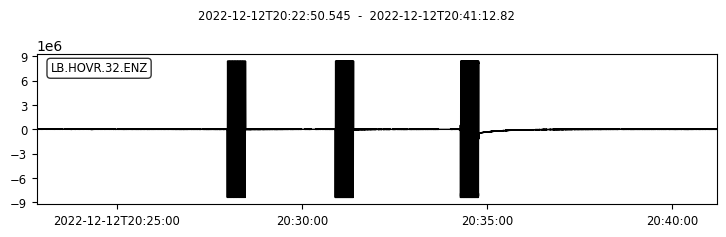

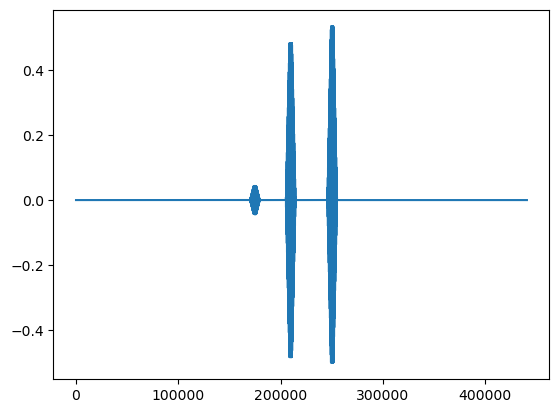

30545 0.5342575260263531


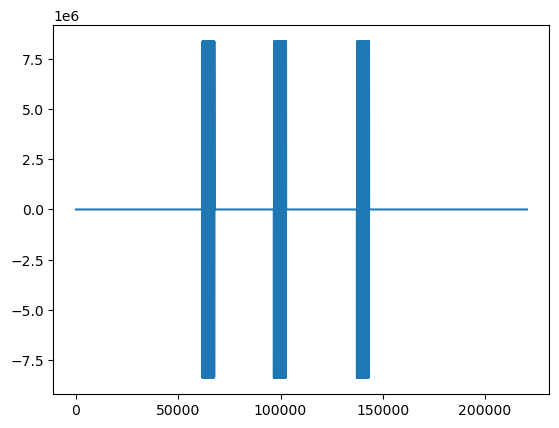

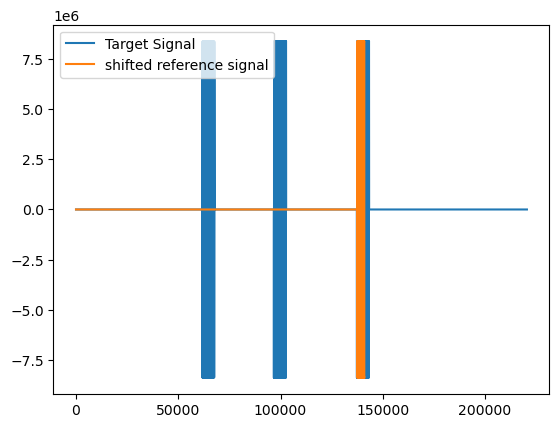

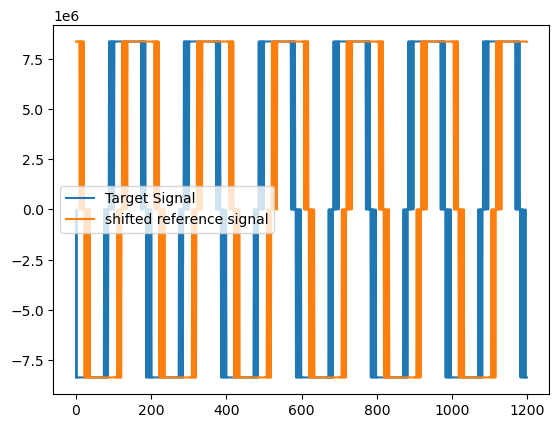

2 Trace(s) in Stream:
LB.HOVR1.40.EN1 | 2022-12-12T21:29:44.185000Z - 2022-12-12T21:38:46.995000Z | 200.0 Hz, 108563 samples
LB.HOVR1.40.EN1 | 2022-12-12T21:38:48.000000Z - 2022-12-12T21:47:14.650000Z | 200.0 Hz, 101331 samples
0.5954795319268156


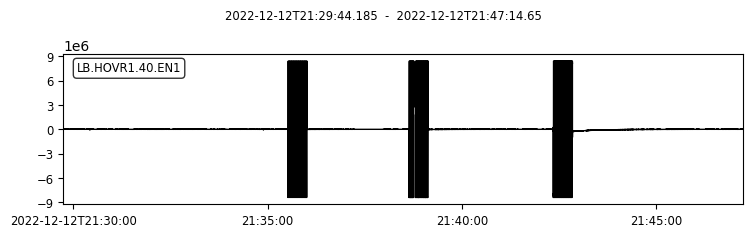

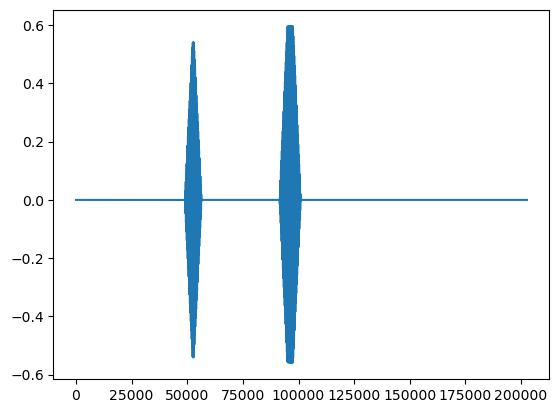

-3851.5 0.5954795319268156


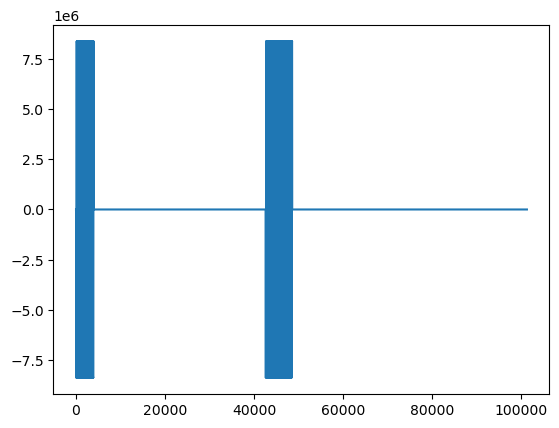

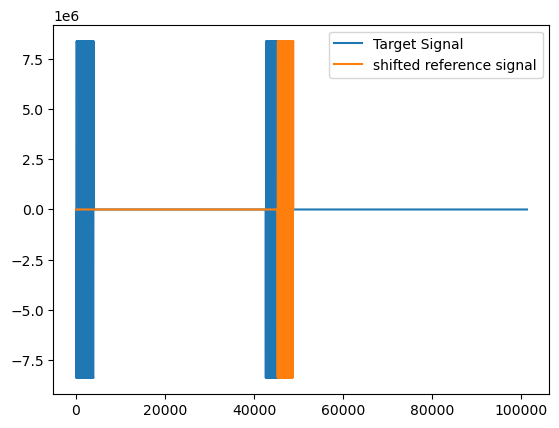

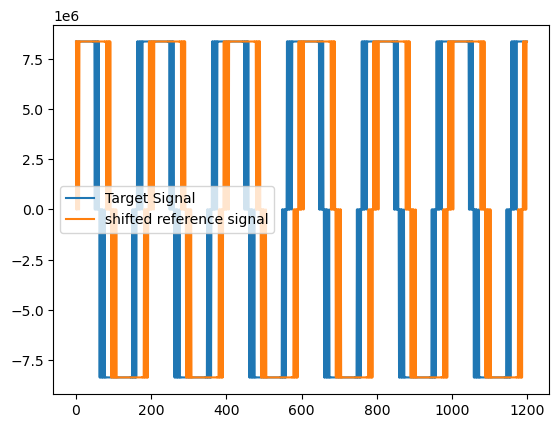

2 Trace(s) in Stream:
LB.HOVR1.40.EN2 | 2022-12-12T21:29:44.205000Z - 2022-12-12T21:38:46.995000Z | 200.0 Hz, 108559 samples
LB.HOVR1.40.EN2 | 2022-12-12T21:38:48.000000Z - 2022-12-12T21:47:14.270000Z | 200.0 Hz, 101255 samples
0.5961403854098539


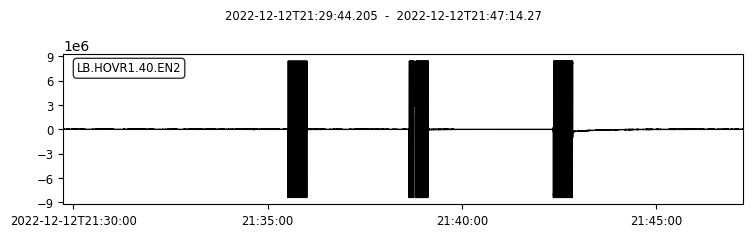

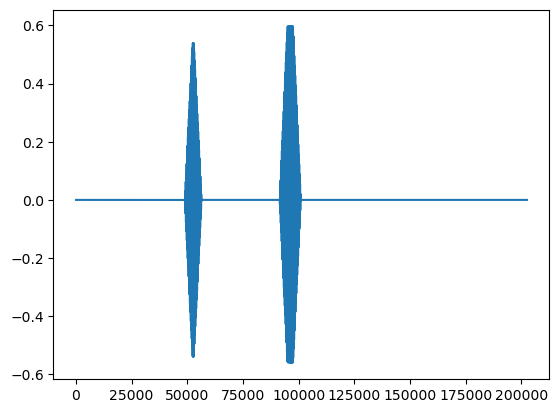

-3813.5 0.5961403854098539


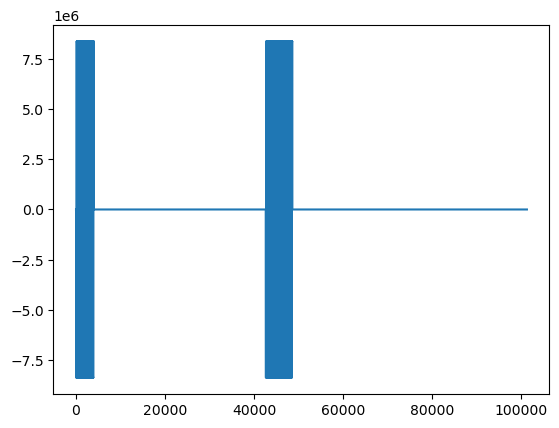

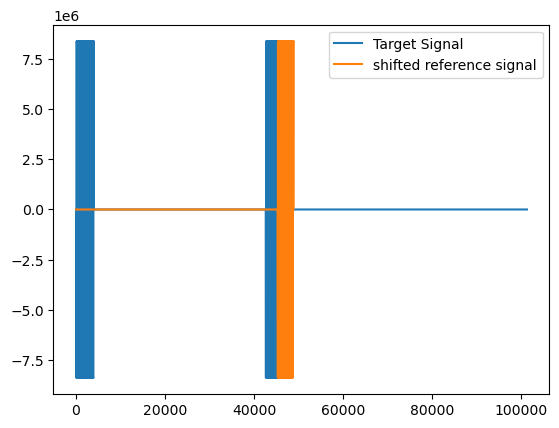

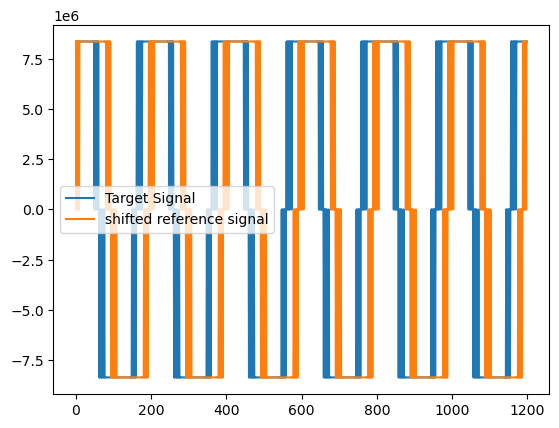

2 Trace(s) in Stream:
LB.HOVR1.40.ENZ | 2022-12-12T21:29:44.160000Z - 2022-12-12T21:38:46.995000Z | 200.0 Hz, 108568 samples
LB.HOVR1.40.ENZ | 2022-12-12T21:38:48.000000Z - 2022-12-12T21:47:13.865000Z | 200.0 Hz, 101174 samples
0.5959422137815023


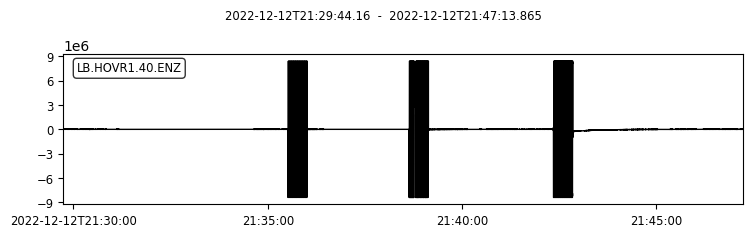

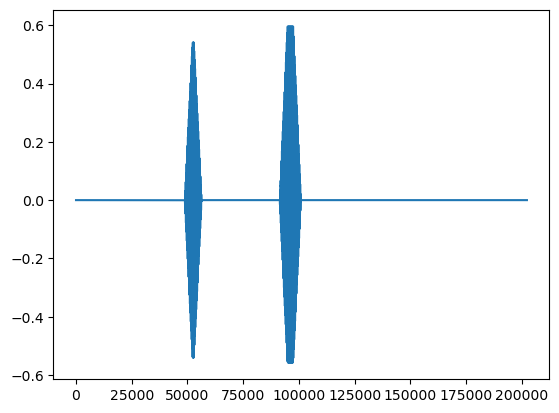

-3774 0.5959422137815023


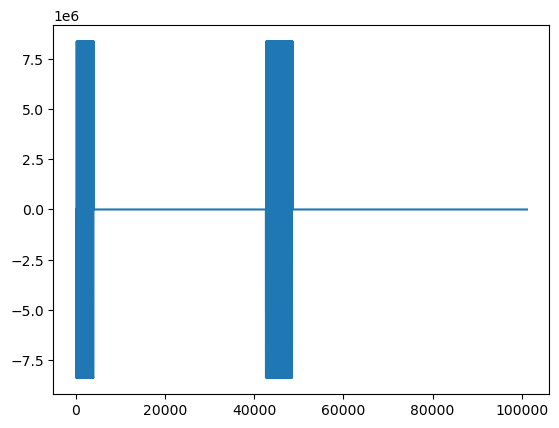

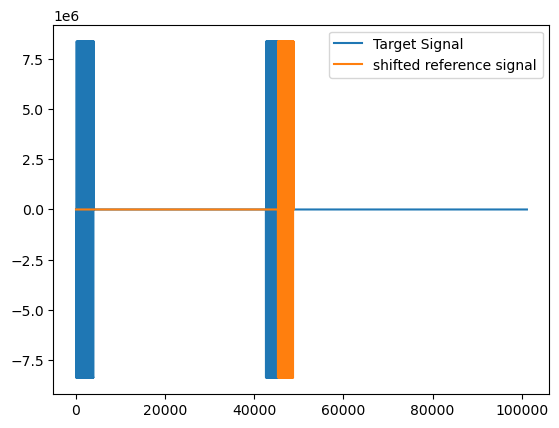

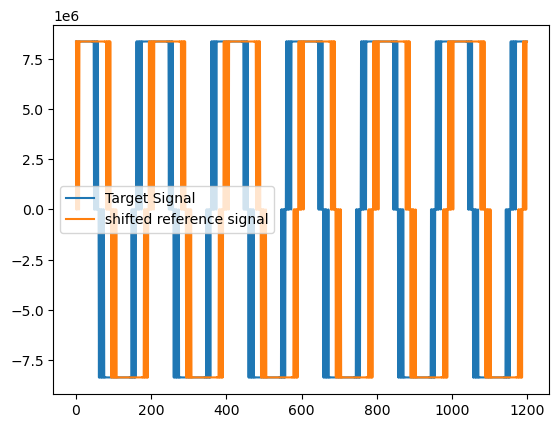

2 Trace(s) in Stream:
LB.HOVR3.32.EN1 | 2022-12-12T19:31:11.300000Z - 2022-12-12T19:36:14.995000Z | 200.0 Hz, 60740 samples
LB.HOVR3.32.EN1 | 2022-12-12T19:38:29.000000Z - 2022-12-12T19:50:17.505000Z | 200.0 Hz, 141702 samples
0.018548390262135846
2 Trace(s) in Stream:
LB.HOVR3.32.EN2 | 2022-12-12T19:31:11.905000Z - 2022-12-12T19:36:14.995000Z | 200.0 Hz, 60619 samples
LB.HOVR3.32.EN2 | 2022-12-12T19:38:29.000000Z - 2022-12-12T19:50:18.055000Z | 200.0 Hz, 141812 samples
0.539762443405096


C:\Users\lmazza\AppData\Local\Temp\7\ipykernel_15076\1590243472.py:45: RuntimeWarning: invalid value encountered in sqrt
  if sqrt(mean(square(tr.data))) > sqrt(mean(square(dominant_trace.data))):


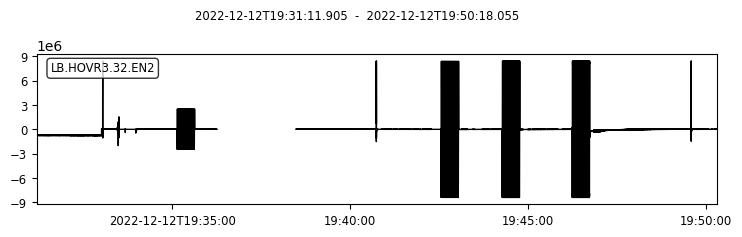

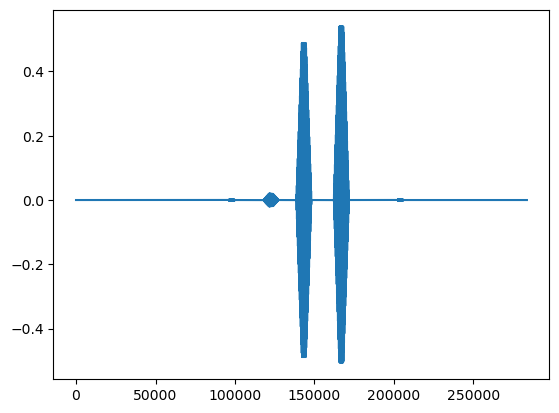

25647 0.539762443405096


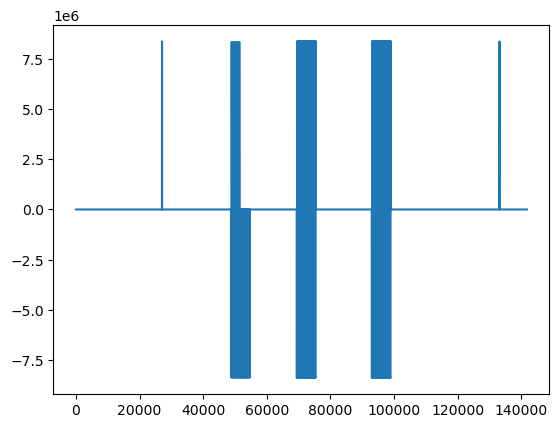

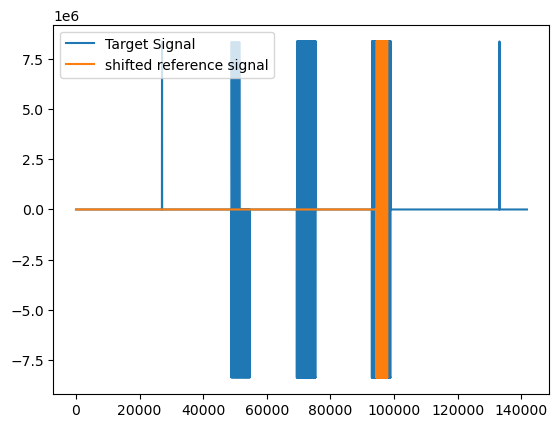

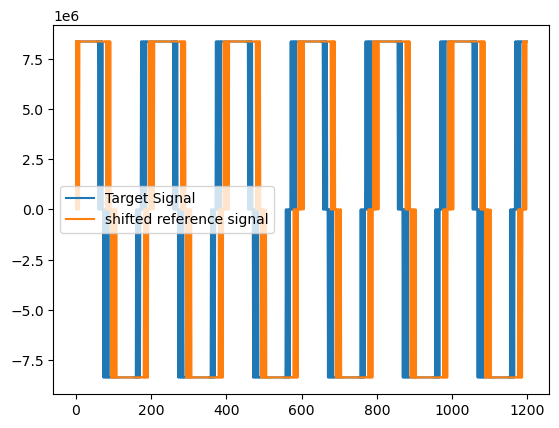

1 Trace(s) in Stream:
LB.HOVR4.42.EN1 | 2022-12-12T22:10:27.375000Z - 2022-12-12T22:25:40.535000Z | 200.0 Hz, 182633 samples
0.5103148082184948


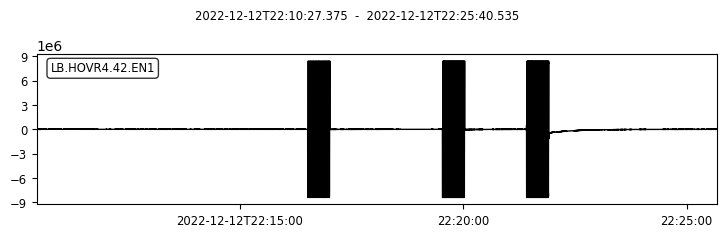

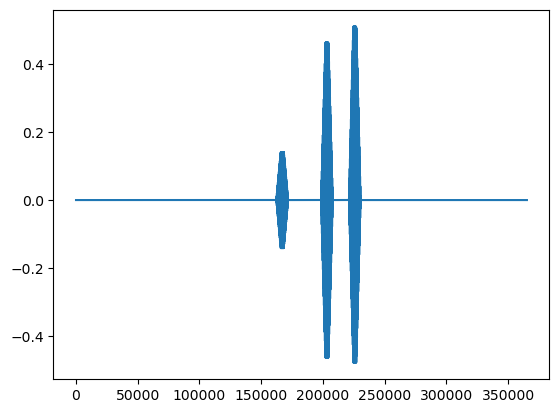

42083.5 0.5103148082184948


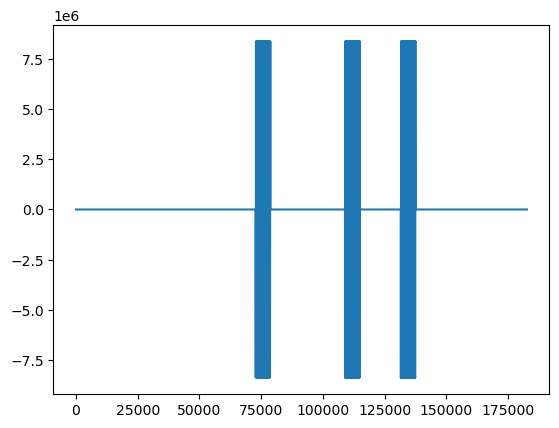

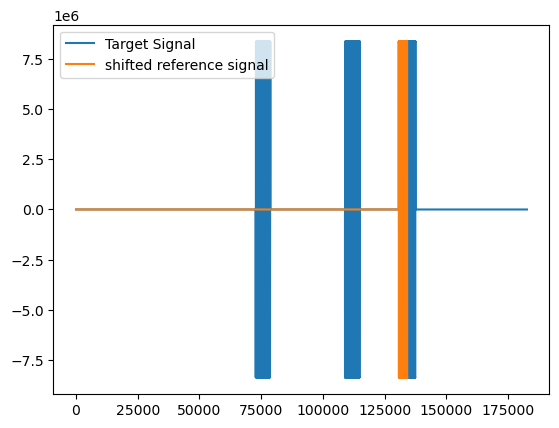

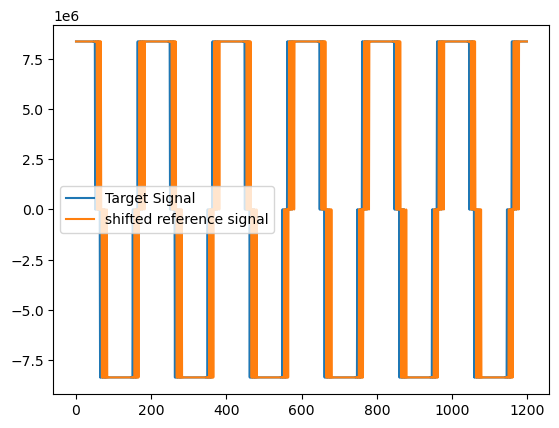

1 Trace(s) in Stream:
LB.HOVR4.42.EN2 | 2022-12-12T22:10:26.365000Z - 2022-12-12T22:25:40.330000Z | 200.0 Hz, 182794 samples
0.5124739429223661


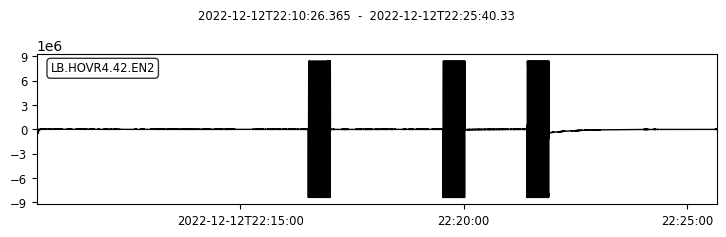

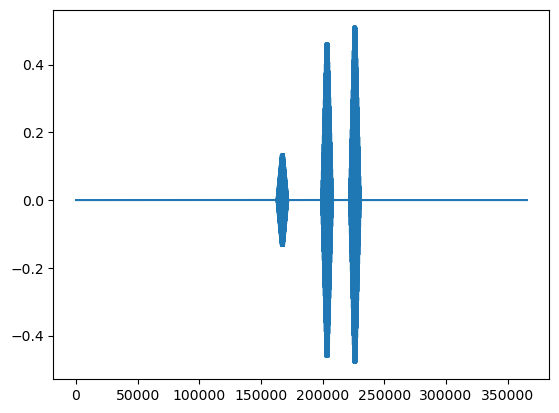

42603 0.5124739429223661


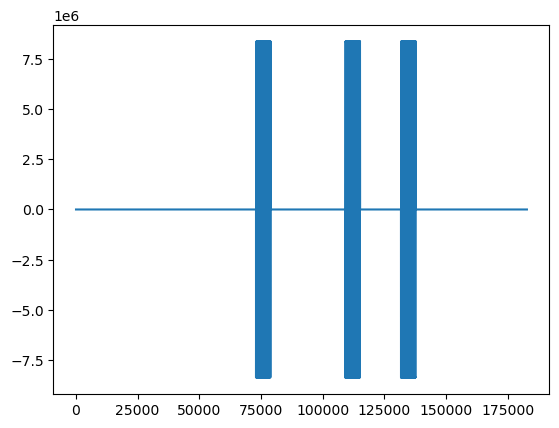

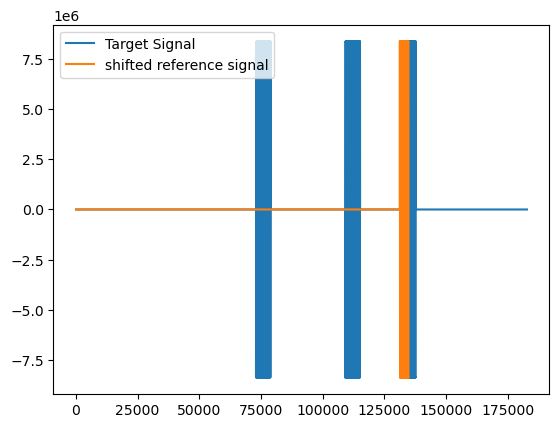

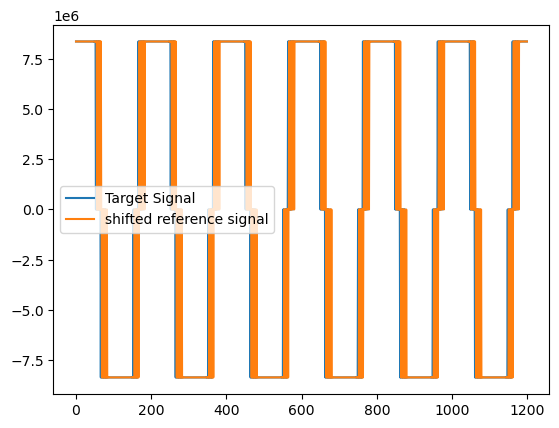

1 Trace(s) in Stream:
LB.HOVR4.42.ENZ | 2022-12-12T22:10:26.080000Z - 2022-12-12T22:25:40.095000Z | 200.0 Hz, 182804 samples
0.5142888259398617


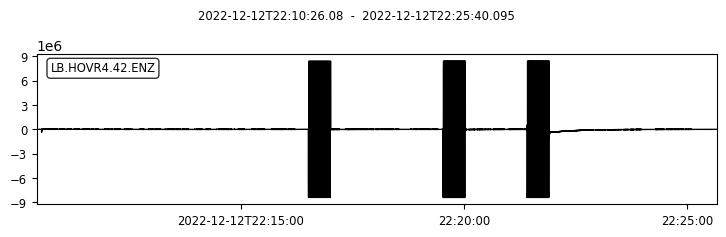

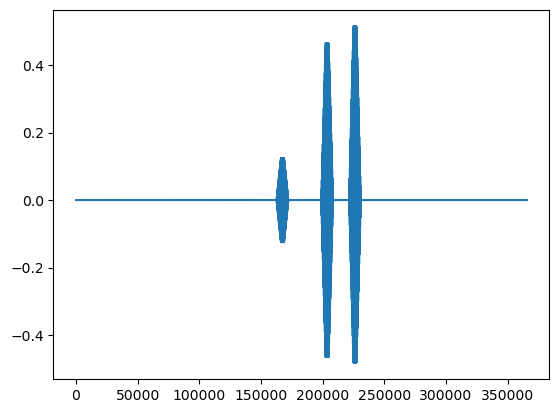

42656 0.5142888259398617


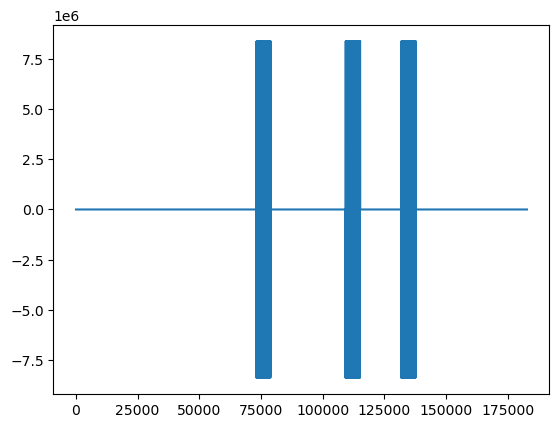

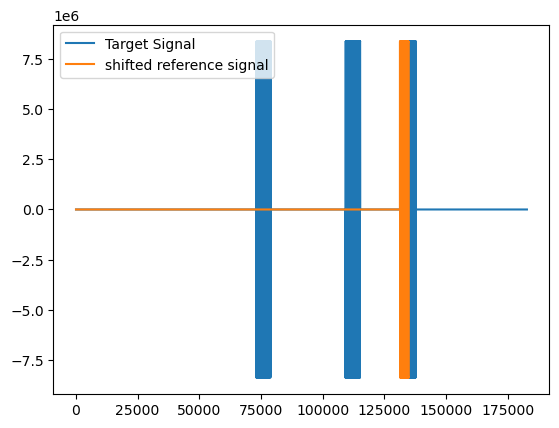

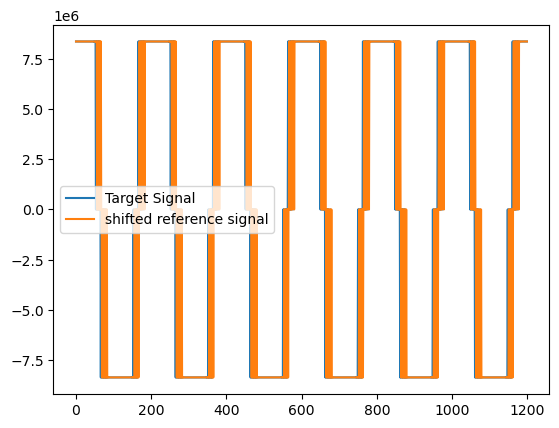

2 Trace(s) in Stream:
LB.HOVR5.50.EN1 | 2022-12-13T17:11:54.385000Z - 2022-12-13T17:16:45.995000Z | 200.0 Hz, 58323 samples
LB.HOVR5.50.EN1 | 2022-12-13T17:16:47.000000Z - 2022-12-13T17:26:48.615000Z | 200.0 Hz, 120324 samples
0.4833995807369546


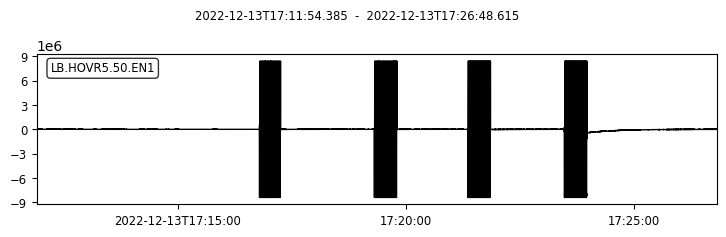

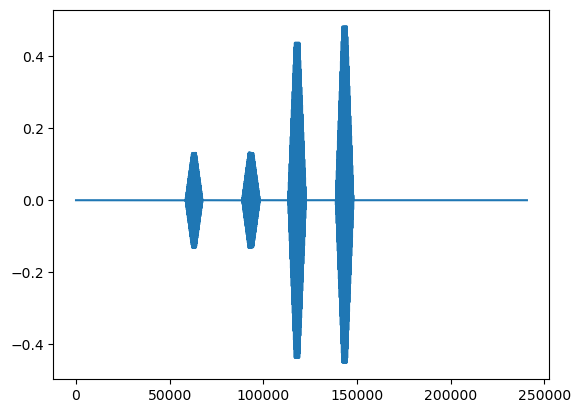

23080 0.4833995807369546


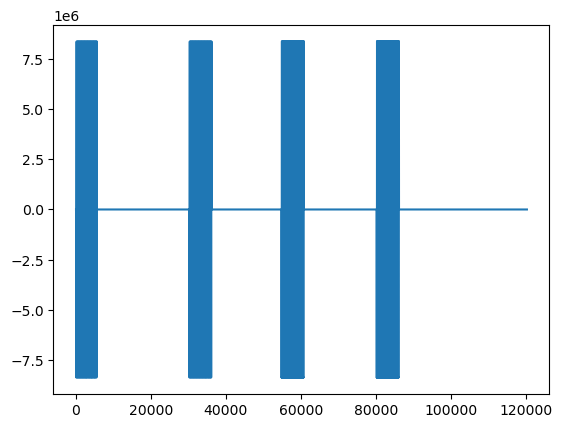

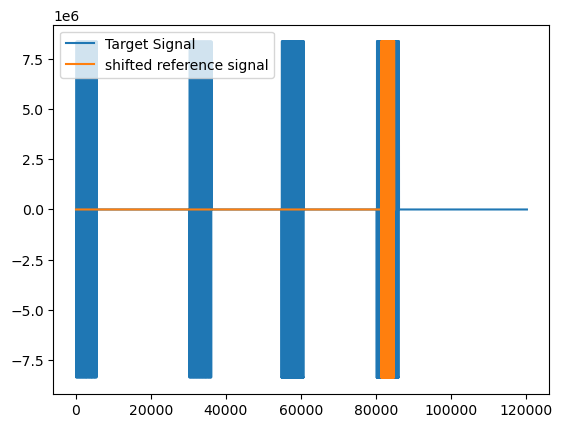

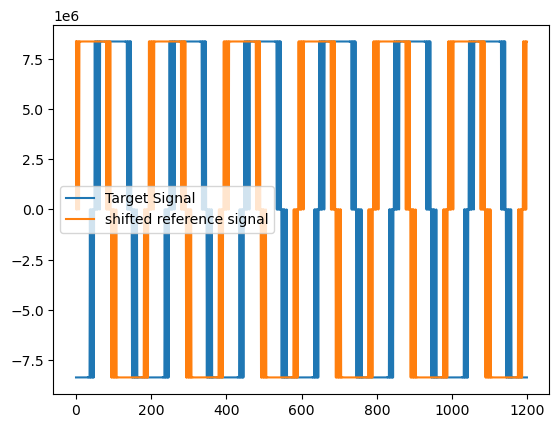

2 Trace(s) in Stream:
LB.HOVR5.50.EN2 | 2022-12-13T17:11:54.360000Z - 2022-12-13T17:16:45.995000Z | 200.0 Hz, 58328 samples
LB.HOVR5.50.EN2 | 2022-12-13T17:16:47.000000Z - 2022-12-13T17:26:48.295000Z | 200.0 Hz, 120260 samples
0.4828242966228857


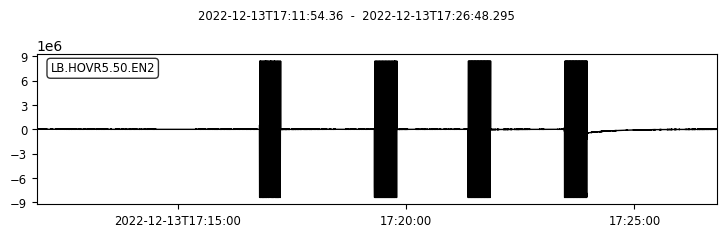

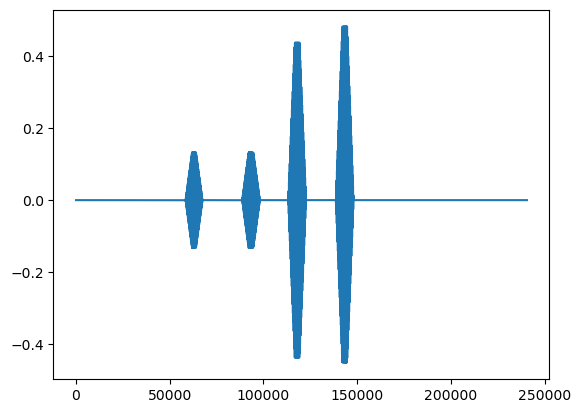

23512 0.4828242966228857


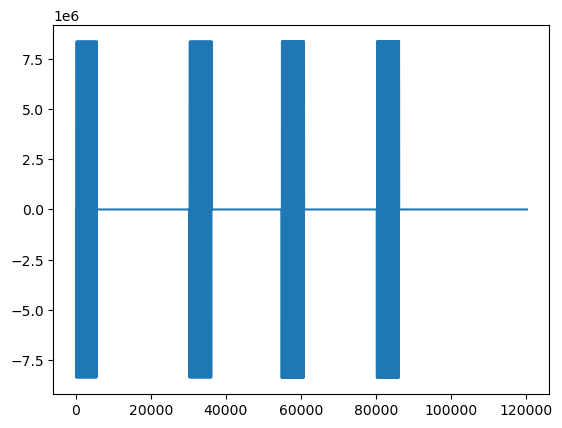

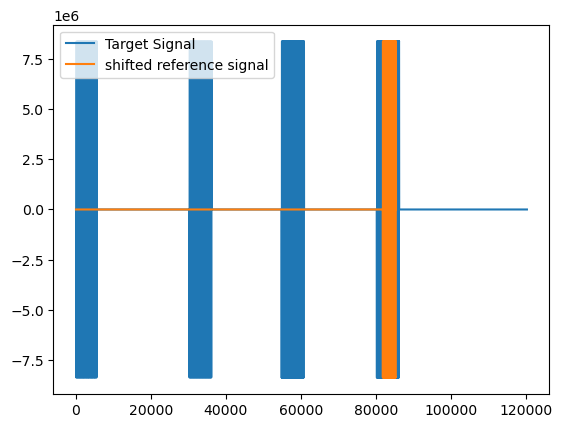

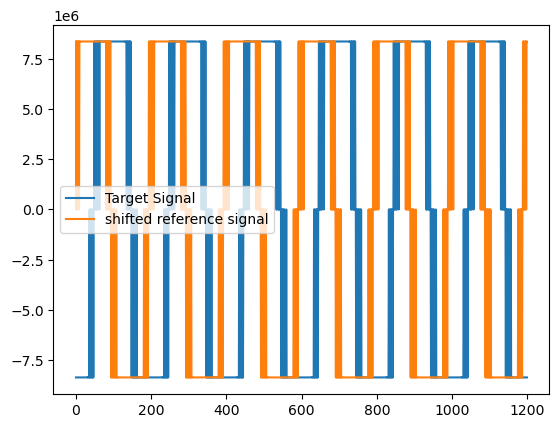

2 Trace(s) in Stream:
LB.HOVR5.50.ENZ | 2022-12-13T17:11:54.345000Z - 2022-12-13T17:16:45.995000Z | 200.0 Hz, 58331 samples
LB.HOVR5.50.ENZ | 2022-12-13T17:16:47.000000Z - 2022-12-13T17:26:48.540000Z | 200.0 Hz, 120309 samples
0.4816723232704213


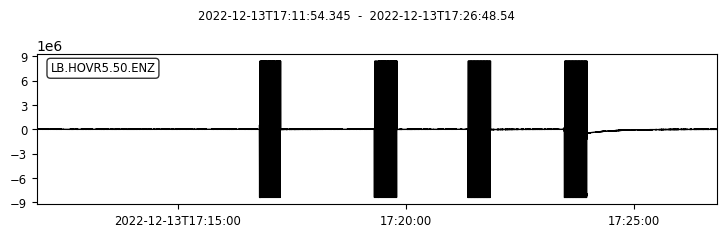

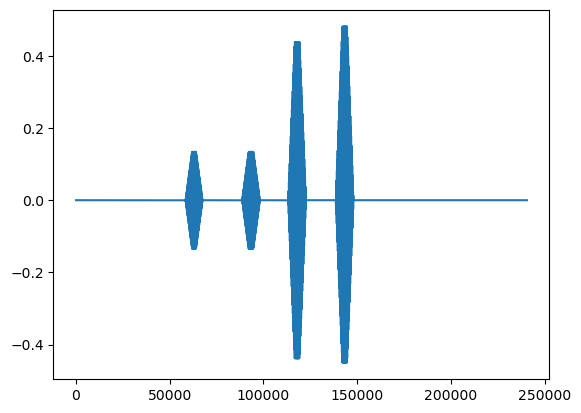

23089.5 0.4816723232704213


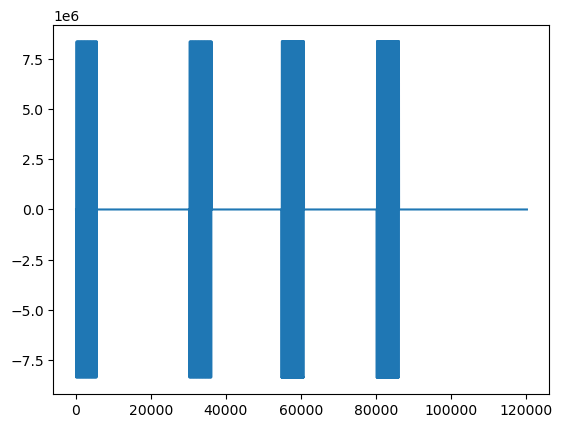

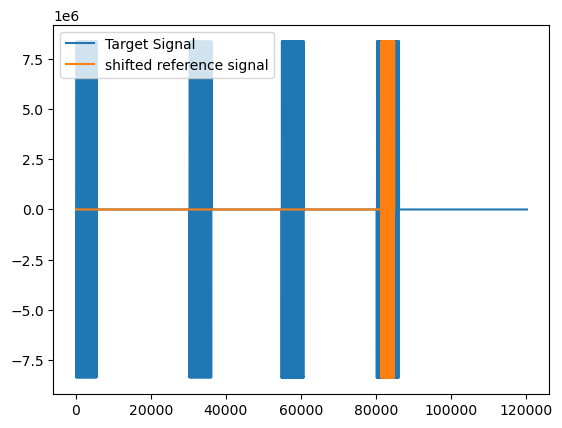

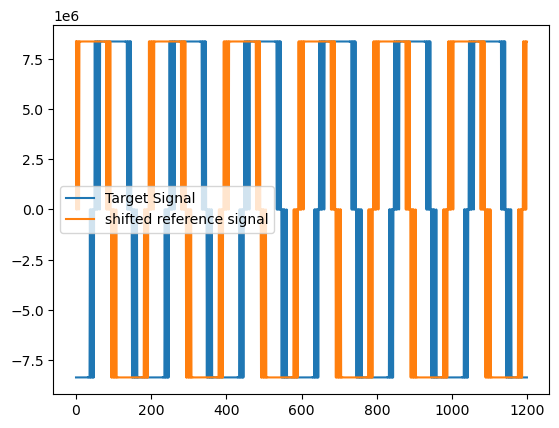

1 Trace(s) in Stream:
LB.HOVR6.52.EN1 | 2022-12-13T16:22:31.250000Z - 2022-12-13T16:40:59.320000Z | 200.0 Hz, 221615 samples
0.5461911862104435


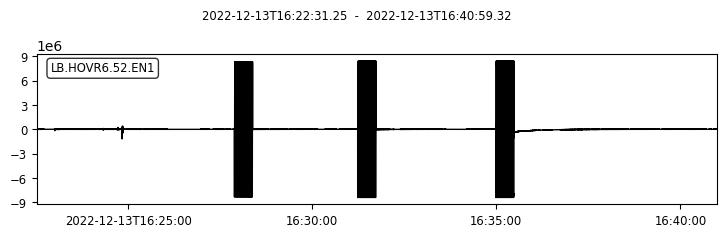

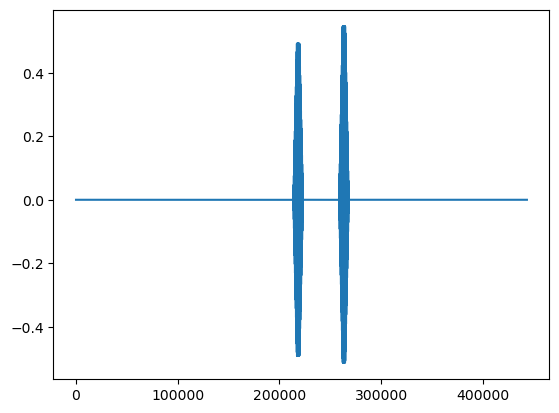

41111.5 0.5461911862104435


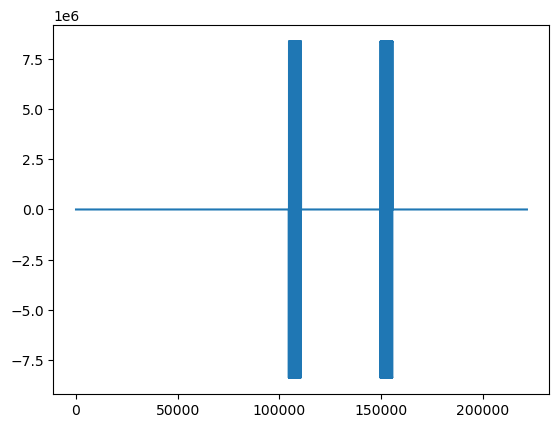

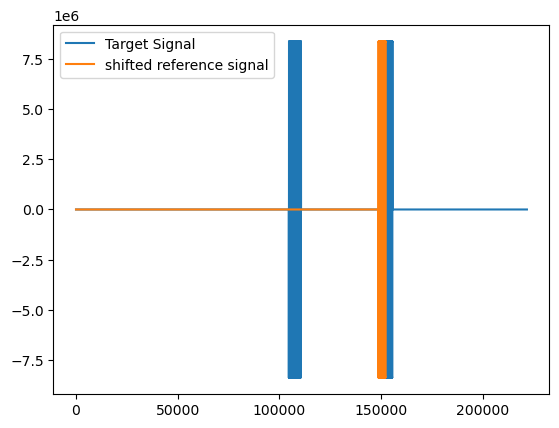

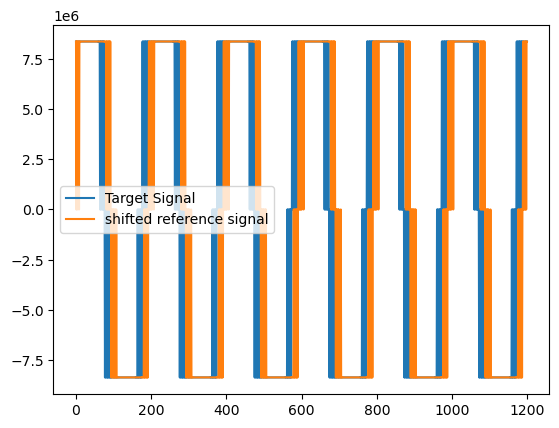

1 Trace(s) in Stream:
LB.HOVR6.52.EN2 | 2022-12-13T16:22:31.280000Z - 2022-12-13T16:40:59.125000Z | 200.0 Hz, 221570 samples
0.5427051411642255


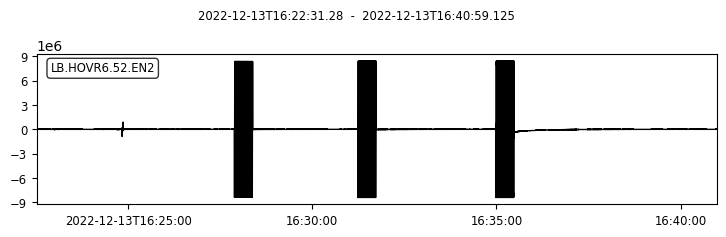

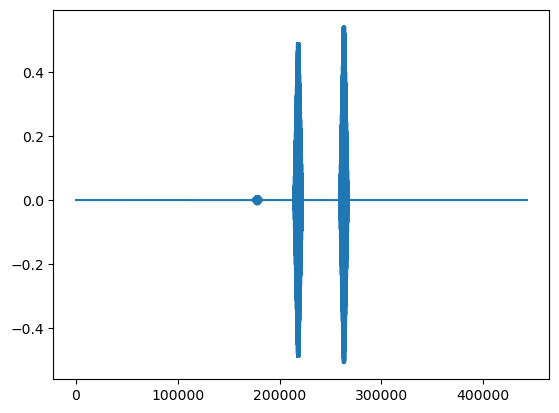

41126 0.5427051411642255


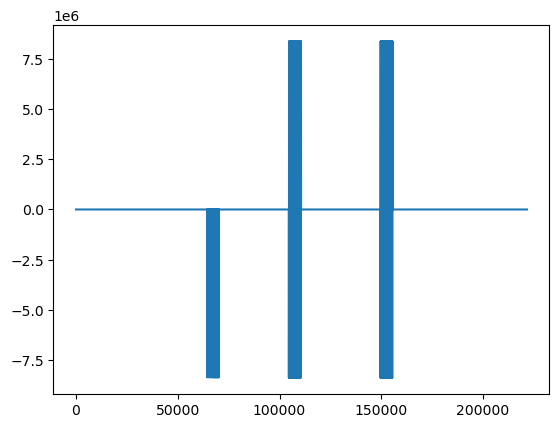

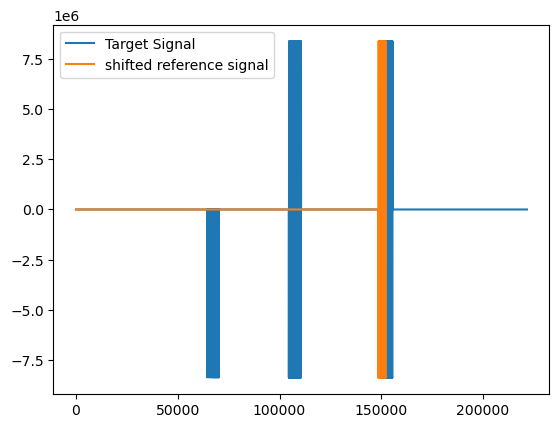

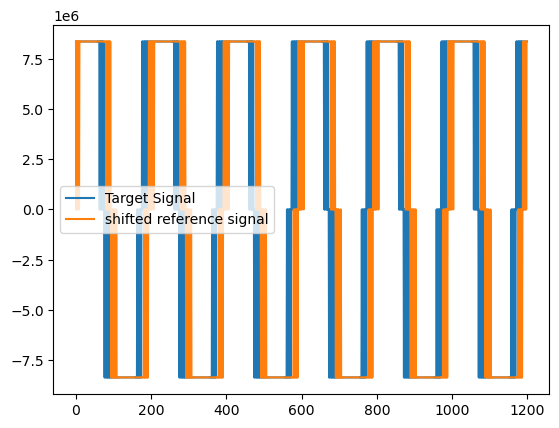

1 Trace(s) in Stream:
LB.HOVR6.52.ENZ | 2022-12-13T16:22:31.280000Z - 2022-12-13T16:40:58.950000Z | 200.0 Hz, 221535 samples
0.5317085778831822


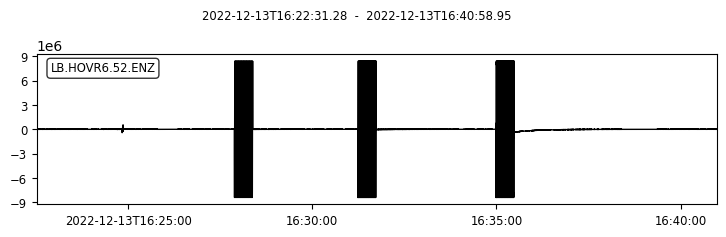

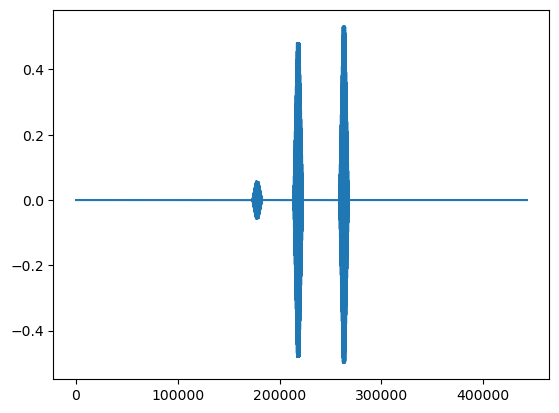

41142.5 0.5317085778831822


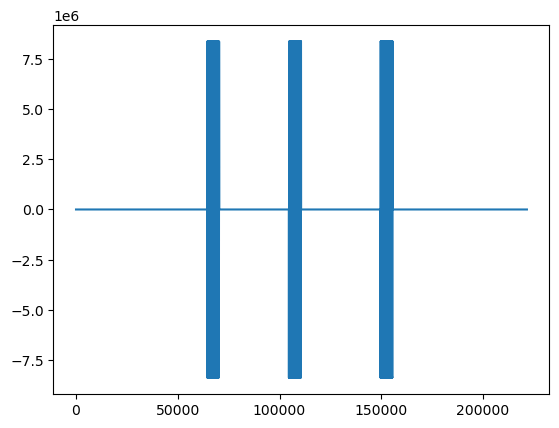

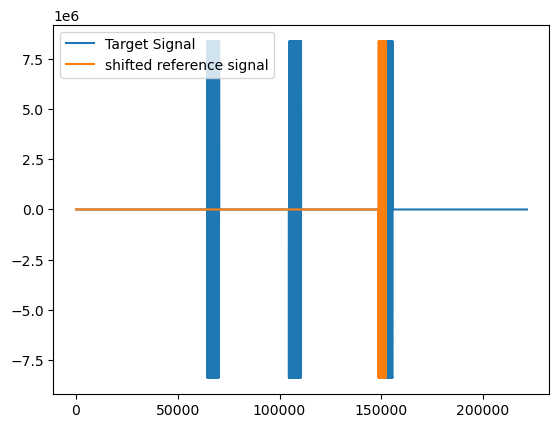

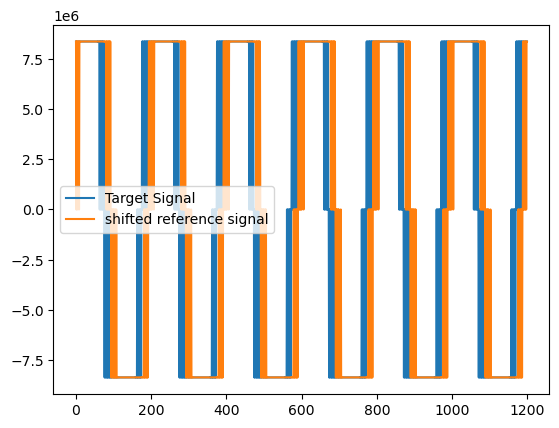

In [8]:
def get_atsensor_signals(station_dict):
    #Encode the top directory 
    directory = fse('Hoover_cals/HooverCals/Atsensorsite/')
    #List the Files of the Encoded directory
    storage = ld(directory)
    #Loop through all the entries in the Encoded Directory
    station_dict_atsens = {}
    station_dict_atlog = {}
    for dir in storage:
        #Decode the directory and encode its contents
        sig_list_log = []
        sig_list_sens = []
        file = fsd(dir)
        #Failsafe for if the user forgets to delete HOVR2 from the atlogger dictionary
        if file == 'HOVR2':
            continue
        new_dir = fse(f'Hoover_cals/HooverCals/Atsensorsite/{file}')
        # Create a new list of the directory's encoded sub-directories
        new_storage = ld(new_dir)
        i = -1
        #Loop through the encoded contents of the most recently decoded directory
        for dir2 in new_storage:
            #Decode the most recently encoded directory. A pattern is Emerging here. Essentially, 
            #we follow this convention of encoding and decoding the filesystem until we reach all the sac files at the bottom 
            #of the Directory Tree. 
            file2 = fsd(dir2)
            if file2[0] != 'E' or (file == 'HOVR3' and i == 1): # ->EXP
                continue
            new_dir2 = fse(f'Hoover_cals/HooverCals/Atsensorsite/{file}/{file2}')
            new_storage2 = ld(new_dir2)
            i+=1
            for dir3 in new_storage2:
                file3 = fsd(dir3)
                new_dir3 = fse(f'Hoover_cals/HooverCals/Atsensorsite/{file}/{file2}/{file3}')
                new_storage3 = ld(new_dir3)
                #We have finally reached the sac files we want to work with. Let's perform some operations 
                for sac_file in new_storage3: 
                    #Read in the data from the sac file using Obspy 
                    sac_obs = fsd(sac_file)
                    st = read(f'Hoover_cals/HooverCals/Atsensorsite/{file}/{file2}/{file3}/{sac_obs}')
                    print(st)
                    if len(st) != 1:
                        dominant_trace = st[0]
                        for tr in st[1:]:
                            if sqrt(mean(square(tr.data))) > sqrt(mean(square(dominant_trace.data))):
                                dominant_trace = tr
                        info = dominant_trace.data
                        threshold = np.max(info) - 30000 # ->EXP
                        good_info = np.where(np.abs(info) >= threshold, info, info*0)
                        x = np.arange(0,len(info))
                        #Different process for accessing the correlation waveforms with atlogger. 
                        cc = correlate(good_info,station_dict[f'{file}'][i],len(good_info))
                    else:
                        dominant_trace = st[0]
                        info = dominant_trace.data
                        threshold = np.max(info) - 30000 # ->EXP
                        good_info = np.where(np.abs(info) >= threshold, info, info*0)
                        x = np.arange(0,len(info))
                        cc = correlate(good_info,station_dict[f'{file}'][i],len(good_info))
                    print(np.max(cc))
                    if np.max(cc) > 0.1:
                        st.plot()
                        plt.plot(cc)
                        plt.show()
                        shift,correlation_value = xcorr_max(cc)
                        print(shift,correlation_value)
                        #Slightly different routine for the add_on derivation
                        if len(info) < 1e5:
                            add_on = len(cc)*0.215
                        else:
                            add_on = len(cc)*0.2425
                        check = np.concatenate((np.zeros(np.abs(int(shift+add_on))),station_dict[f'{file}'][i])) # ->EXP
                        plt.plot(good_info)
                        plt.show()
                        plt.plot(good_info)
                        plt.plot(check)
                        plt.legend(['Target Signal','shifted reference signal'])
                        plt.show()
                        #Different indexing routine for plotting and saving the aligned waveforms. 
                        if shift > 0:
                            midpoint = check.argmax()
                            plt.plot(good_info[midpoint+1000:midpoint+2200]) # ->EXP
                            plt.plot(check[midpoint+1000:midpoint+2200]) # ->EXP
                            plt.legend(['Target Signal','shifted reference signal'])
                            plt.show()
                        else:
                            midpoint = check.argmax()
                            plt.plot(good_info[midpoint+1000:midpoint+2200]) # ->EXP
                            plt.plot(check[midpoint+1000:midpoint+2200]) # ->EXP
                            plt.legend(['Target Signal','shifted reference signal'])
                            plt.show()
                        sig_list_sens.append(good_info[midpoint+1000:midpoint+2200]) # ->EXP
                        sig_list_log.append(check[midpoint+1000:midpoint+2200]) # ->EXP
        station_dict_atsens[f'{file}'] = sig_list_sens
        station_dict_atlog[f'{file}'] = sig_list_log
    return(station_dict_atsens,station_dict_atlog)
station_dict_atsens,station_dict_atlog = get_atsensor_signals(station_dict)

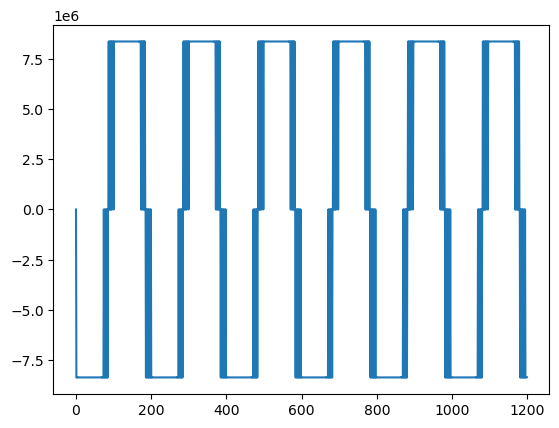

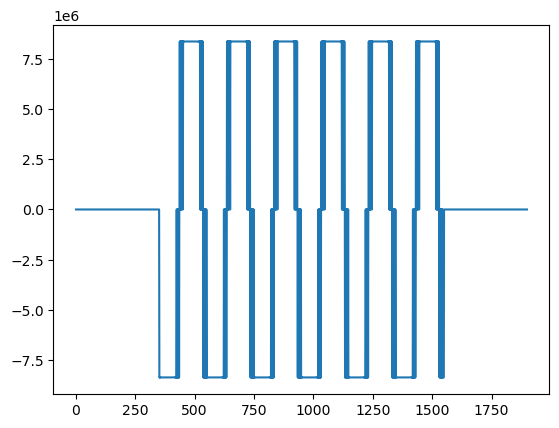

In [100]:
#Create a reference waveform from a random signal in the dataset. This will serve as the wave of interest for the training data 
ref = (station_dict_atsens['HOVR'][2])
plt.plot(ref)
plt.show()
#Make a template for waveform insertion for training data and an insert which contains some zeros and the reference waveform
template = np.zeros(int(1e5))
insert = np.concatenate((np.zeros(350),ref,np.zeros(350)))
plt.plot(insert)

In [102]:
#Make a noise insert based on a section of a signal from the dataset. 
waveform2 = read('Hoover_cals/HooverCals/Atlogger/HOVR6/ENZ.D/347/LE.HOVR6.52.ENZ.D.2022.347.20')
section = (waveform2[0].data[300:800])
insert = np.concatenate((np.zeros(350),section,np.zeros(350)))
training_data = {}
#Through looping through two ranges, many training data entries will be made through inserting ref once and the insert many times throughout the 
# Artificial waveform. 
for i in range(int(1060)):
    new_data = np.zeros(int(1e5))
    new_data[int(i**1.65):int(i**1.65)+1200] = ref
    training_data[i] = new_data
    for j in range(315):
        training_data[i][int(j**2):int(j**2)+1200] += (insert * np.random.randint(10)) 
    #Make a trace out of the training data entry
    tr = Trace((training_data[i]))
    #Make a teimstamp based off of today's date and the sample entry of the reference wave insertion. Divided by 100 to account for the 
    #Sampling Rate 
    stamp = 'timestamp_' + str(np.datetime64('today') + np.timedelta64(int(i**1.65/100),'s'))
    #Method to convert unusable characters in the timestamp to a valid filename. 
    stamp = list(stamp)
    stamp[23] = '-'
    stamp[26] = '-'
    stamp = ''.join(stamp)
    #Readjust the sampling rate and write the training data to a .MSEED file. 
    tr.stats.sampling_rate = 100
    tr.write(f'training_waveforms_MSEED/{stamp}.MSEED',format='MSEED')

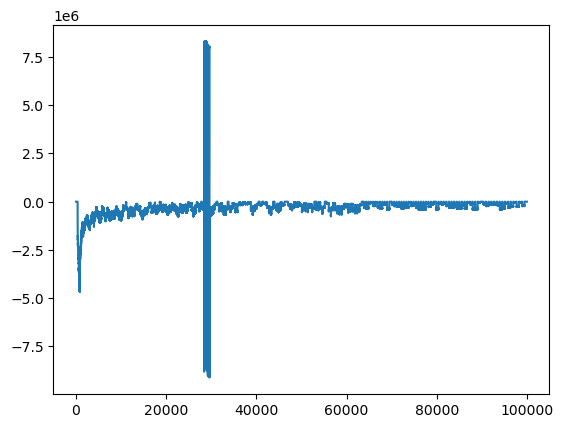

In [103]:
plt.plot(training_data[500])
plt.show()

In [14]:
from os import fsencode as fse
from os import fsdecode as fsd
from os import listdir as ld

# Script that recods where in a training waveform the primary waveform insert was made

In [15]:
dir = fse('training_waveforms_MSEED')
mega_dict = {}
storage = ld(dir)
for i, file in enumerate(storage):
    total = 0
    if i == 0:
        continue
    sac = fsd(file)
    num_group_min = sac[24:26]
    num_group_sec = sac[27:29]
    #Case where num_group_min is a double_digit
    if '0' not in num_group_min:
        #Case where num_group_sec is 00
        if '0' in num_group_sec[0] and '0' in num_group_sec[1]:
            total = (int(num_group_min))*6000
        #Case where num_group_sec is a single digit
        elif '0' in num_group_sec[0]:
            num_group_sec = num_group_sec[1]
            total = (int(num_group_min))*6000 + int(num_group_sec)*100
        #Case where num_group_sec is a double digit 
        else:
            total = (int(num_group_min))*6000 + int(num_group_sec)*100
    #Case where num_group_min is a single digit
    elif '0' not in num_group_min[1]:
        num_group_min = num_group_min[1]
        #Case where num_group_sec is 00
        if '0' in num_group_sec[0] and '0' in num_group_sec[1]:
            total = (int(num_group_min))*6000
        #Case where num_group_sec is a single digit
        elif '0' in num_group_sec[0]:
            num_group_sec = num_group_sec[1]
            total = (int(num_group_min))*6000 + int(num_group_sec)*100
        #Case where num_group_sec is a double digit 
        else:
            total = (int(num_group_min))*6000 + int(num_group_sec)*100
    #Case Where num_group_min is a multiple of 10
    elif '0' not in num_group_min[0]:
        num_group_min = num_group_min[0]
        #Case where num_group_sec is 00
        if '0' in num_group_sec[0] and '0' in num_group_sec[1]:
            total = (int(num_group_min))*6000
        #Case where num_group_sec is a single digit
        elif '0' in num_group_sec[0]:
            num_group_sec = num_group_sec[1]
            total = (int(num_group_min))*6000 + int(num_group_sec)*100
        #Case where num_group_sec is a double digit
        else:
            total = (int(num_group_min))*6000 + int(num_group_sec)*100
    #Case where num_group_min is 00
    else:
        #Case where num_group_sec is a double digit
        if '0' not in num_group_sec:
            total = int(num_group_sec)*100
        #Case where num_group_sec is a single digit
        elif '0' not in num_group_sec[1]:
            total = int(num_group_sec[1])*100
        #Case Where num_group_sec is a multiple of 10
        elif '0' not in num_group_sec[0]:
            total = int(num_group_sec[0]) *100
        #Case where num_group_sec is 00
        else:
            total = 0
    mini_seed = read(f'training_waveforms_MSEED/{sac}')
    start = (total)
    end = total + 1200
    id_num = f'{round(start)}-{round(end)}'
    mega_dict[f'{id_num}'] = mini_seed[0].data


In [16]:
mega_dict

{'100-1300': array([0., 0., 0., ..., 0., 0., 0.]),
 '200-1400': array([0., 0., 0., ..., 0., 0., 0.]),
 '300-1500': array([0., 0., 0., ..., 0., 0., 0.]),
 '400-1600': array([0., 0., 0., ..., 0., 0., 0.]),
 '500-1700': array([0., 0., 0., ..., 0., 0., 0.]),
 '600-1800': array([0., 0., 0., ..., 0., 0., 0.]),
 '700-1900': array([0., 0., 0., ..., 0., 0., 0.]),
 '800-2000': array([0., 0., 0., ..., 0., 0., 0.]),
 '900-2100': array([0., 0., 0., ..., 0., 0., 0.]),
 '1100-2300': array([0., 0., 0., ..., 0., 0., 0.]),
 '1200-2400': array([0., 0., 0., ..., 0., 0., 0.]),
 '1300-2500': array([0., 0., 0., ..., 0., 0., 0.]),
 '1400-2600': array([0., 0., 0., ..., 0., 0., 0.]),
 '1500-2700': array([0., 0., 0., ..., 0., 0., 0.]),
 '1600-2800': array([0., 0., 0., ..., 0., 0., 0.]),
 '1700-2900': array([0., 0., 0., ..., 0., 0., 0.]),
 '1800-3000': array([0., 0., 0., ..., 0., 0., 0.]),
 '1900-3100': array([0., 0., 0., ..., 0., 0., 0.]),
 '2100-3300': array([0., 0., 0., ..., 0., 0., 0.]),
 '2200-3400': array([

In [17]:
dir = fse('training_waveforms_MSEED/')
storage = ld(dir)
storage[1]
sac = fsd(storage[1])
sacy = read(f'training_waveforms_MSEED/{sac}')
sacy[0].stats.sampling_rate = 200
sacy[0].stats

         network: 
         station: 
        location: 
         channel: 
       starttime: 1970-01-01T00:00:00.000000Z
         endtime: 1970-01-01T00:08:19.995000Z
   sampling_rate: 200.0
           delta: 0.005
            npts: 100000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 199, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 815104})

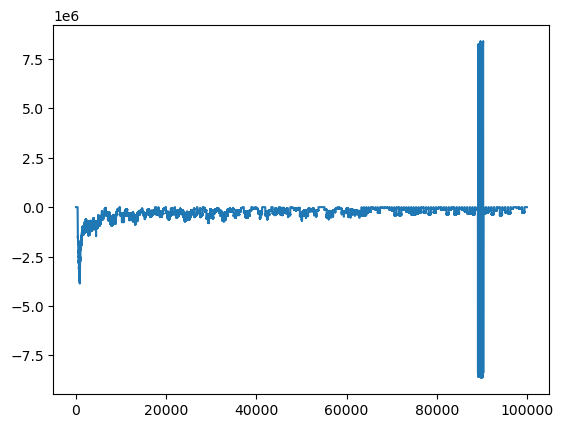

In [18]:
plt.plot(training_data[1000])

281 401
(249, 257, 1)


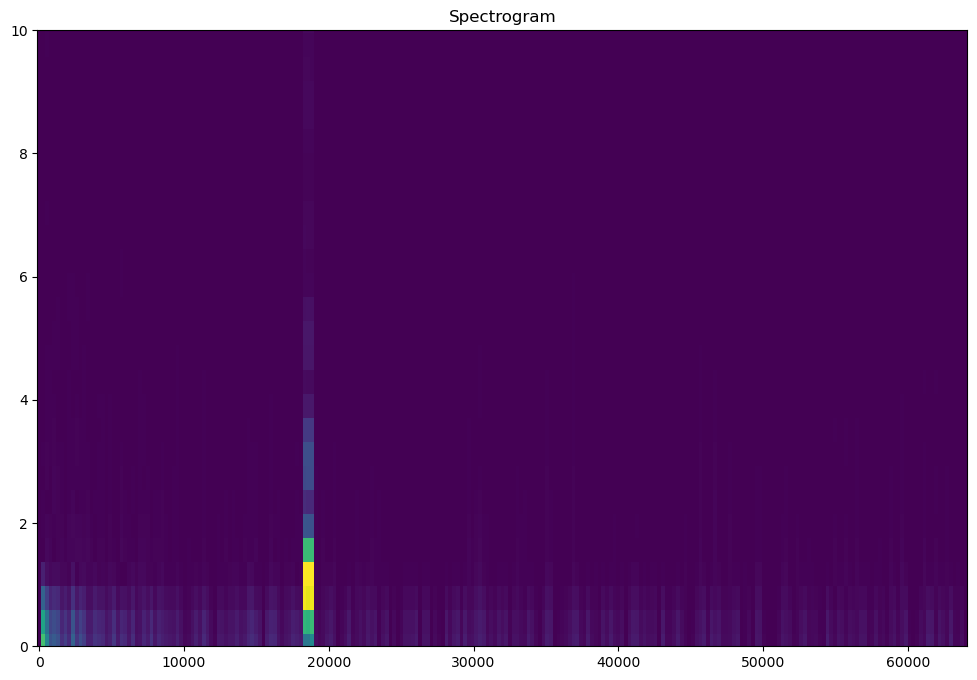

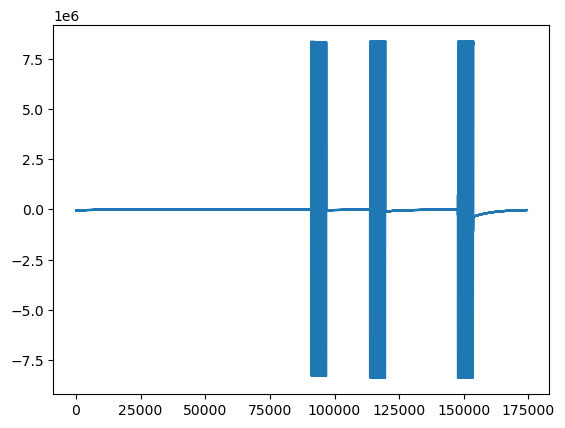

In [19]:
spectrogram,fl = get_plot_spectrogram(training_data[500])
print(spectrogram.shape)

fig, axes = plt.subplots(1, figsize=(12, 8))

plot_spectrogram(spectrogram.numpy(), axes,fl)
axes.set_title('Spectrogram')
plt.show()
plt.plot(waveform)
plt.show()

# Subspace Detection

# Notes

## Partitioning these detectors is the key to getting accurate results.
## Make sure to account for the sampling_rates!
## Descriptions of subspace methods, filtering schemes, and plotting methods are detailed in the master function at the bottom of the notebook

# File Reading and detector construction

In [20]:
from eqcorrscan.core import subspace
detector = subspace.Detector()
import glob

In [21]:
import matplotlib.pyplot as plt

In [22]:
wavefiles = glob.glob('Truck_waves_clipped2/*')
streams = [read(w) for w in wavefiles]
# for i, st in enumerate(streams):
#     st.write(f'newst{i}.wav', format='WAV')

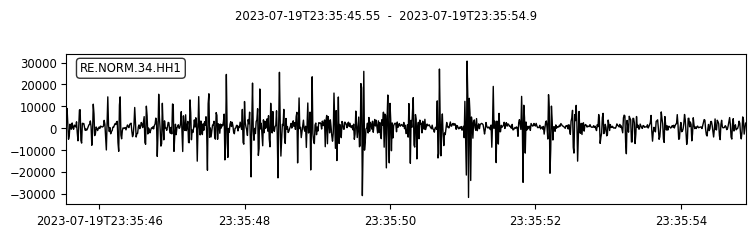

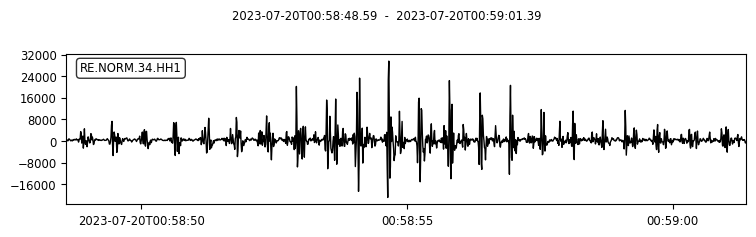

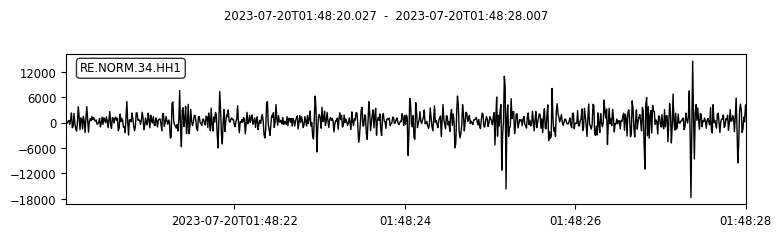

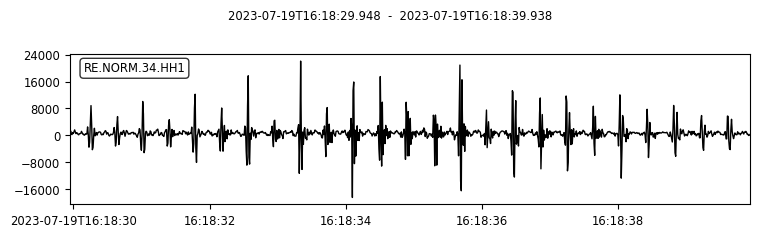

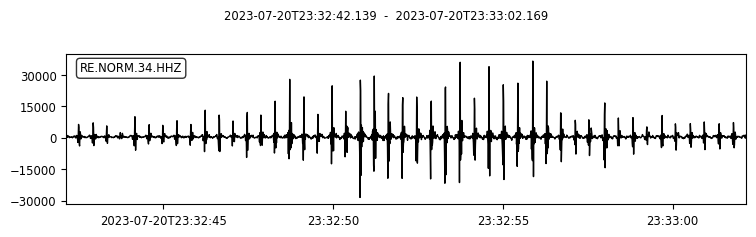

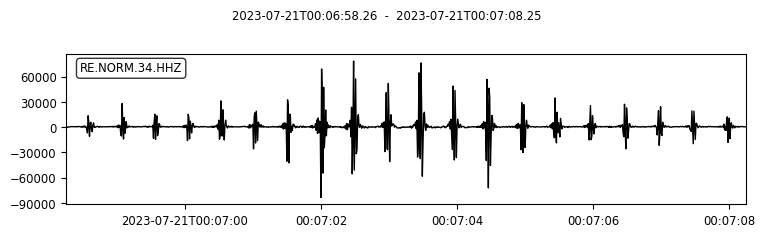

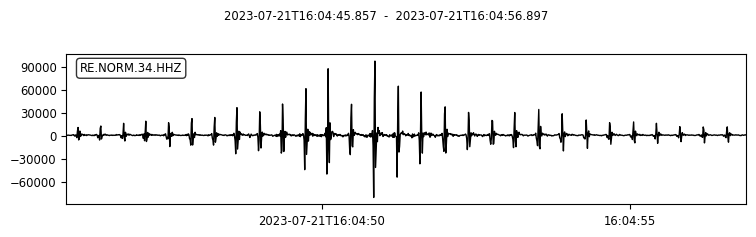

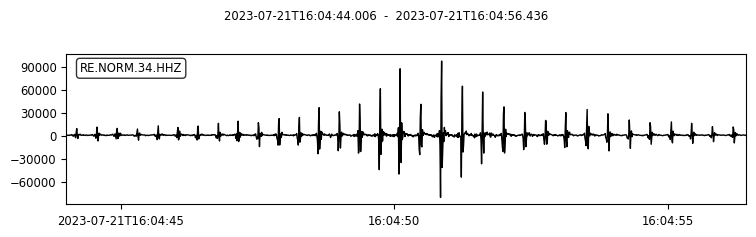

In [23]:
for stream in streams:
    stream.plot()

In [97]:
from obspy import read
import numpy as np
import glob
import os
from eqcorrscan import tests
from obspy import Trace, Stream
streamz = []
#Method for waveform condensement and length aligning.
for st in streams:
    print(len(st[0].data))
    new_st = Stream(Trace(np.array(st[0][400:799].data)))
    new_st[0].stats.sampling_rate = 100
    streamz.append(new_st)
    

936
1281
799
1000
2004
1000
1105
1244


In [25]:
streamz

[1 Trace(s) in Stream:
... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:03.980000Z | 100.0 Hz, 399 samples,
 1 Trace(s) in Stream:
... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:03.980000Z | 100.0 Hz, 399 samples,
 1 Trace(s) in Stream:
... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:03.980000Z | 100.0 Hz, 399 samples,
 1 Trace(s) in Stream:
... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:03.980000Z | 100.0 Hz, 399 samples,
 1 Trace(s) in Stream:
... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:03.980000Z | 100.0 Hz, 399 samples,
 1 Trace(s) in Stream:
... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:03.980000Z | 100.0 Hz, 399 samples,
 1 Trace(s) in Stream:
... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:03.980000Z | 100.0 Hz, 399 samples,
 1 Trace(s) in Stream:
... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:03.980000Z | 100.0 Hz, 399 samples]

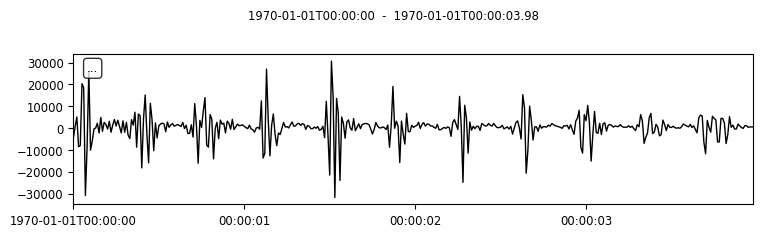

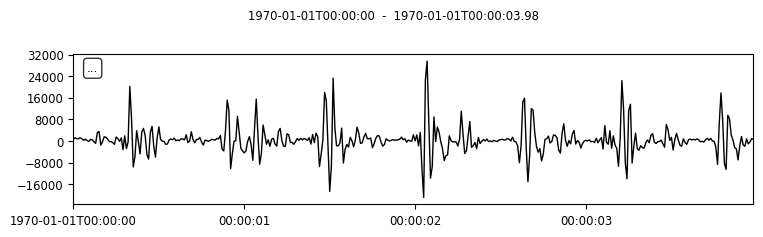

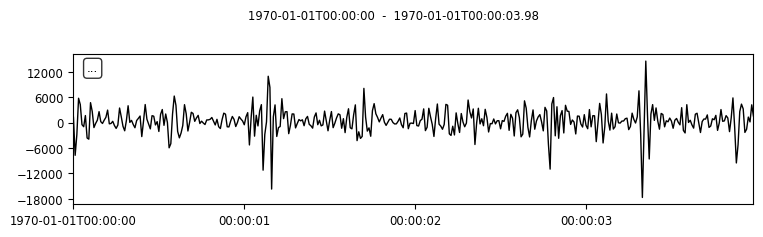

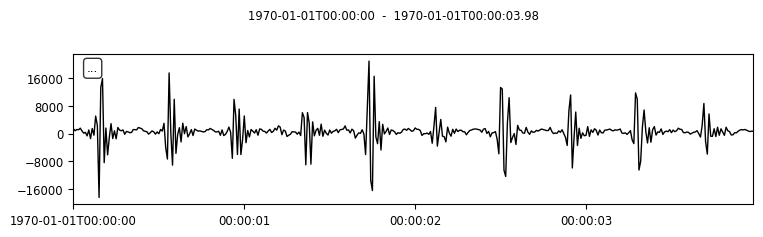

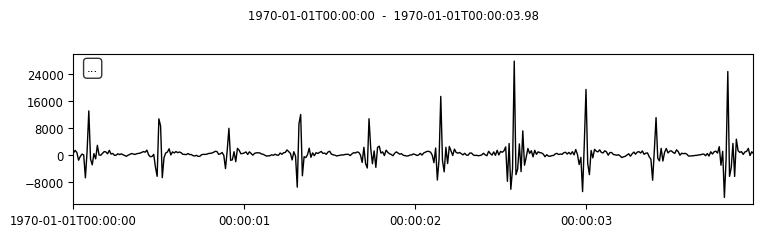

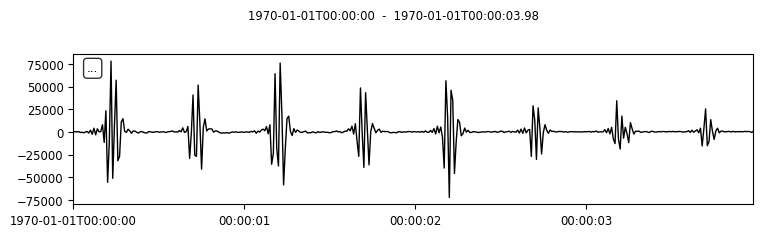

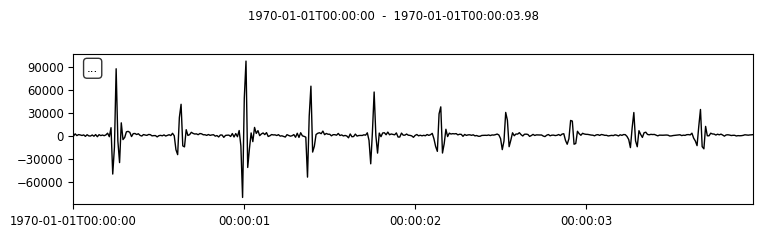

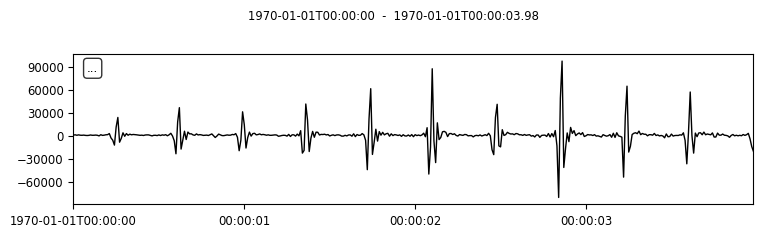

In [26]:
for stream in streamz:
    stream.plot()

In [27]:
# Channels must all be the same length
detector.construct(streams=streamz, lowcut=3, highcut=12, filt_order=4,
                    sampling_rate=100, multiplex=False, name='Test_1',
                    align=True,shift_len=1, reject=0.15) # ->EXP
detector.partition(2)

Detector: Test_1

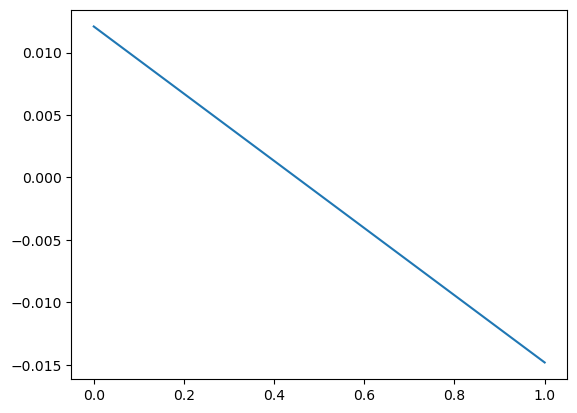

In [28]:
plt.plot(detector.data[0][49])

# Detector Testing

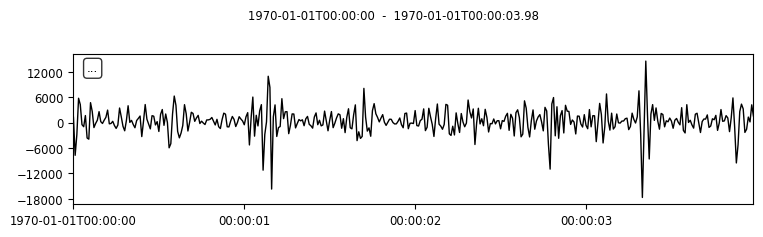

In [29]:
# Test on original template waveform

streamey = streamz[2]
streamey.plot()
#Initiate the detector on the test stream and print out important information alongside it.
detections = detector.detect(st=streamey, threshold=0.3,trig_int=10,extract_detections=True) # ->EXP

1


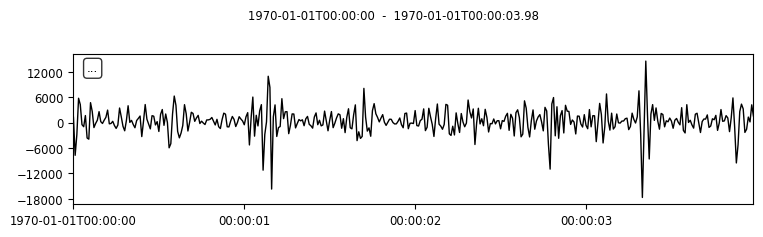

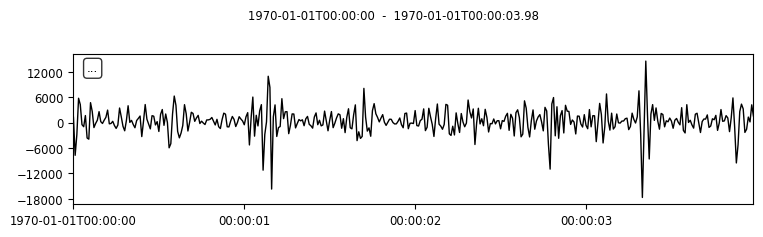

In [30]:
print(len(detections[0]))
detections[1][0].plot()

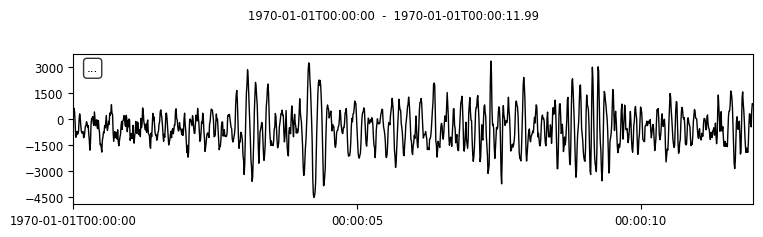

1 Trace(s) in Stream:
... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:11.990000Z | 100.0 Hz, 1200 samples

In [31]:
#Test on small waveform outside dataset

streamey2 = read('Test_dir/neweywav0.wav,')
streamey2[0].stats.sampling_rate = 100
streamey2.plot()
streamey2

In [32]:
detections2 = detector.detect(st=streamey2, threshold=0.9,trig_int=1, extract_detections=True) # ->EXP
print(len(detections2[0]))

0


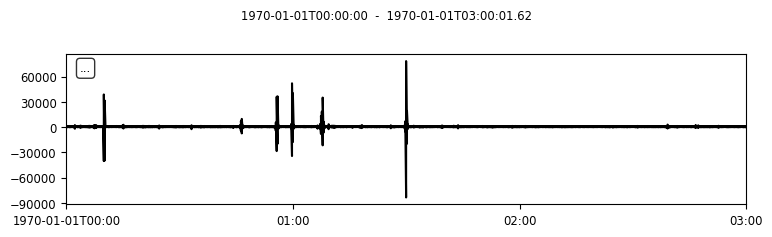

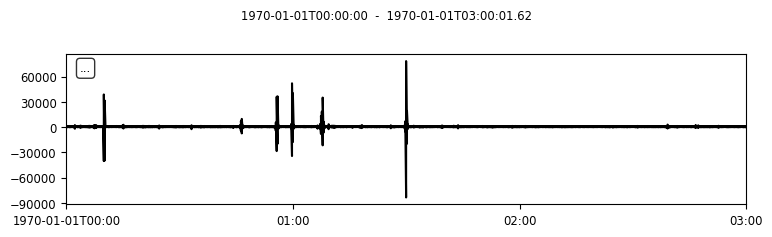

In [33]:
#Test on large waveform Group

streamey3 = read('Test_dir/NORM_HHZ_RE_34_Test3.mseed')
streamey33 = Stream(Trace(streamey3[0].data))
streamey33[0].stats.sampling_rate = 100
streamey33.plot()

In [34]:
detections3 = detector.detect(st=streamey33, threshold=0.375,trig_int=20,extract_detections=True) # ->EXP
len(detections3[0])

10

# False Detection Remover

In [35]:
trimmed_detections = []
trimmed_detection_info = []
for i,detection in enumerate(detections3[1]):
    tr = detection[0].data
    if np.max(tr) > 5000:
        new_tr = Stream(Trace(tr))
        new_tr[0].stats.sampling_rate = 100
        trimmed_detections.append(Stream(new_tr))
        trimmed_detection_info.append(detections3[0][i])    

In [36]:
trimmed_detections

[1 Trace(s) in Stream:
... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:30.000000Z | 100.0 Hz, 3001 samples,
 1 Trace(s) in Stream:
... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:30.000000Z | 100.0 Hz, 3001 samples,
 1 Trace(s) in Stream:
... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:30.000000Z | 100.0 Hz, 3001 samples,
 1 Trace(s) in Stream:
... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:30.000000Z | 100.0 Hz, 3001 samples,
 1 Trace(s) in Stream:
... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:30.000000Z | 100.0 Hz, 3001 samples]

In [37]:
len(detections3[1])

10

# Detection Plotting

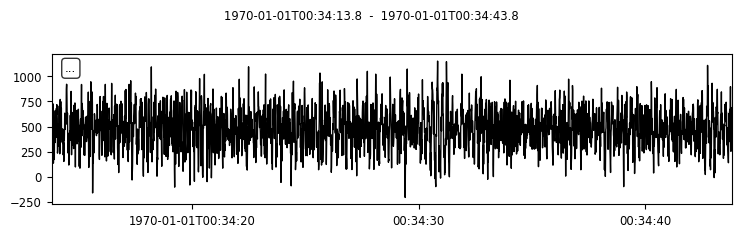

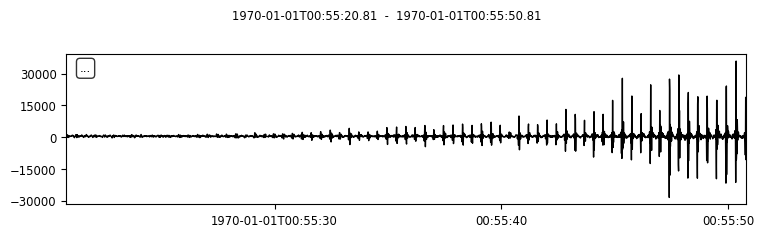

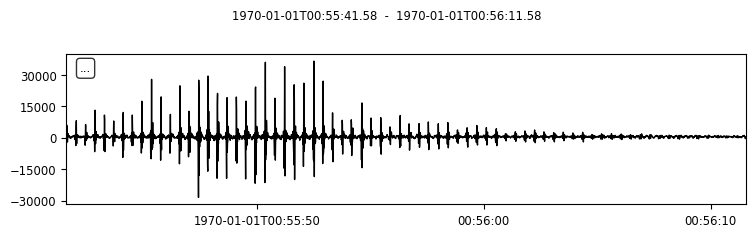

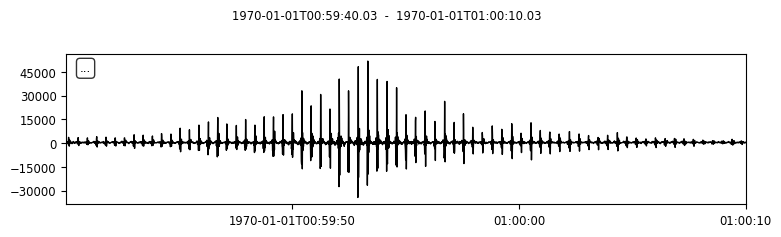

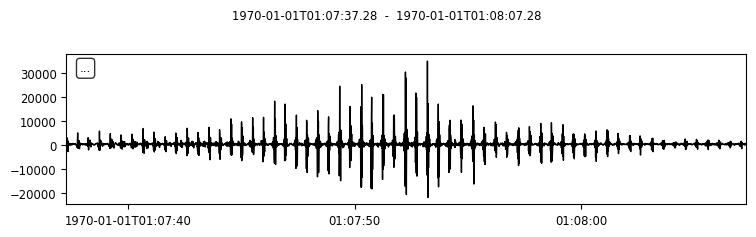

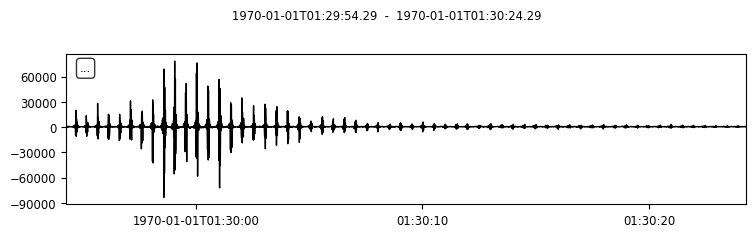

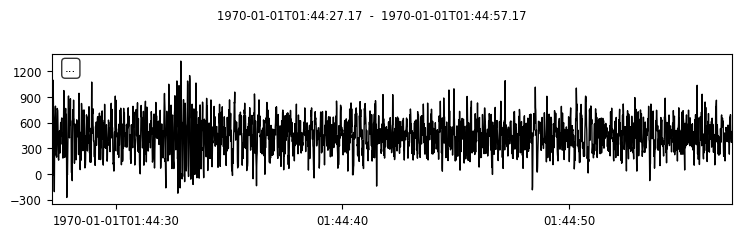

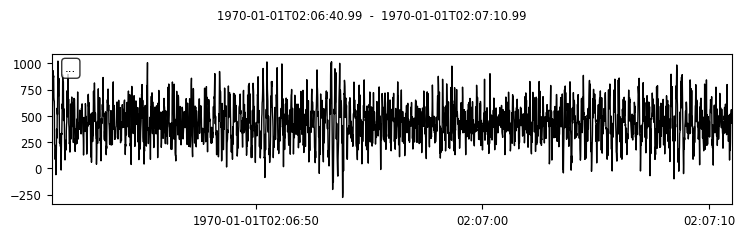

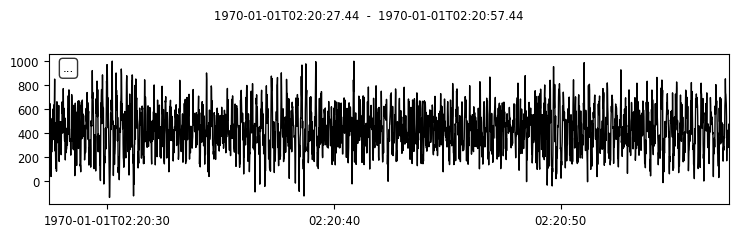

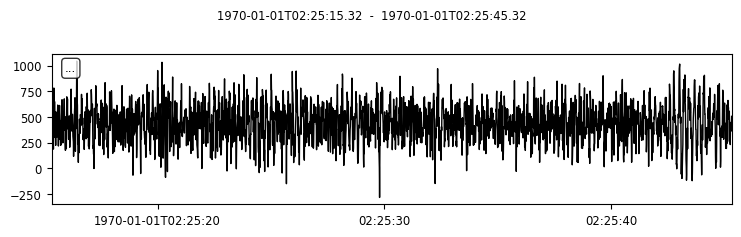

In [38]:
for stream in detections3[1]:
    stream[0].plot()

# Subspace detection line Marker

### Notes: For future reference, it would most likely be superior to divide the time groups up into individual functions for sec,min, and hrs to make the code less verbose. 

In [96]:
def index_finder2(detection):
    #Print the detection description and disect the timestamp portion of it. 
    print(detection)
    timestamp = (str(detection))[45:56]
    #Assemble the timestamp into three groups of time units and conver the values to sample #
    num_group_min = timestamp[3:5]
    num_group_sec = timestamp[6:8]
    num_group_hr = timestamp[0:2]
    #Case where num_group_hr is a double digit
    if '0' not in num_group_hr:
        #Case where num_group_min is a double_digit
        if '0' not in num_group_min:
            #Case where num_group_sec is 00
            if '0' in num_group_sec[0] and '0' in num_group_sec[1]:
                total = (int(num_group_min))*6000 + int(num_group_hr)*360000
            #Case where num_group_sec is a single digit
            elif '0' in num_group_sec[0]:
                num_group_sec = num_group_sec[1]
                total = (int(num_group_min))*6000 + int(num_group_sec)*100 + int(num_group_hr)*360000
            #Case where num_group_sec is a multiple of 10
            elif '0' in num_group_sec[1]:
                num_group_sec = num_group_sec[0]
                total = (int(num_group_min))*6000 + int(num_group_sec)*1000 + int(num_group_hr)*360000
            #Case where num_group_sec is a double digit 
            else:
                total = (int(num_group_min))*6000 + int(num_group_sec)*100 + int(num_group_hr)*360000
        #Case where num_group_min is a single digit
        elif '0' not in num_group_min[1]:
            num_group_min = num_group_min[1]
            #Case where num_group_sec is 00
            if '0' in num_group_sec[0] and '0' in num_group_sec[1]:
                total = (int(num_group_min))*6000 + int(num_group_hr)*360000
            #Case where num_group_sec is a single digit
            elif '0' in num_group_sec[0]:
                num_group_sec = num_group_sec[1]
                total = (int(num_group_min))*6000 + int(num_group_sec)*100 + int(num_group_hr)*360000
            #Case where num_group_sec is a multiple of 10
            elif '0' in num_group_sec[1]:
                num_group_sec = num_group_sec[0]
                total = (int(num_group_min))*6000 + int(num_group_sec)*1000 + int(num_group_hr)*360000
            #Case where num_group_sec is a double digit 
            else:
                total = (int(num_group_min))*6000 + int(num_group_sec)*100 + int(num_group_hr)*360000
        #Case Where num_group_min is a multiple of 10
        elif '0' not in num_group_min[0]:
            num_group_min = num_group_min[0]
            #Case where num_group_sec is 00
            if '0' in num_group_sec[0] and '0' in num_group_sec[1]:
                total = (int(num_group_min))*60000 + int(num_group_hr)*360000
            #Case where num_group_sec is a single digit
            elif '0' in num_group_sec[0]:
                num_group_sec = num_group_sec[1]
                total = (int(num_group_min))*60000 + int(num_group_sec)*100 + int(num_group_hr)*360000
            #Case where num_group_sec is a multiple of 10
            elif '0' in num_group_sec[1]:
                num_group_sec = num_group_sec[0]
                total = (int(num_group_min))*6000 + int(num_group_sec)*1000 + int(num_group_hr)*360000
            #Case where num_group_sec is a double digit
            else:
                total = (int(num_group_min))*60000 + int(num_group_sec)*100 + int(num_group_hr)*360000
        #Case where num_group_min is 00
        else:
            #Case where num_group_sec is a double digit
            if '0' not in num_group_sec:
                total = int(num_group_sec)*100 + int(num_group_hr)*360000
            #Case where num_group_sec is a single digit
            elif '0' not in num_group_sec[1]:
                total = int(num_group_sec[1])*100 + int(num_group_hr)*360000
            #Case Where num_group_sec is a multiple of 10
            elif '0' not in num_group_sec[0]:
                total = int(num_group_sec[0]) *1000 + int(num_group_hr)*360000
            #Case where num_group_sec is 00
            else:
                total = int(num_group_hr) * 360000
    #Case where num_group_hr is a single digit
    elif '0' not in num_group_hr[1]:
        num_group_hr = num_group_hr[1]
            #Case where num_group_min is a double_digit
        if '0' not in num_group_min:
            #Case where num_group_sec is 00
            if '0' in num_group_sec[0] and '0' in num_group_sec[1]:
                total = (int(num_group_min))*6000 + int(num_group_hr)*360000
            #Case where num_group_sec is a single digit
            elif '0' in num_group_sec[0]:
                num_group_sec = num_group_sec[1]
                total = (int(num_group_min))*6000 + int(num_group_sec)*100 + int(num_group_hr)*360000
            #Case where num_group_sec is a multiple of 10
            elif '0' in num_group_sec[1]:
                num_group_sec = num_group_sec[0]
                total = (int(num_group_min))*6000 + int(num_group_sec)*1000 + int(num_group_hr)*360000
            #Case where num_group_sec is a double digit 
            else:
                total = (int(num_group_min))*6000 + int(num_group_sec)*100 + int(num_group_hr)*360000
        #Case where num_group_min is a single digit
        elif '0' not in num_group_min[1]:
            num_group_min = num_group_min[1]
            #Case where num_group_sec is 00
            if '0' in num_group_sec[0] and '0' in num_group_sec[1]:
                total = (int(num_group_min))*6000 + int(num_group_hr)*360000
            #Case where num_group_sec is a single digit
            elif '0' in num_group_sec[0]:
                num_group_sec = num_group_sec[1]
                total = (int(num_group_min))*6000 + int(num_group_sec)*100 + int(num_group_hr)*360000
            #Case where num_group_sec is a multiple of 10
            elif '0' in num_group_sec[1]:
                num_group_sec = num_group_sec[0]
                total = (int(num_group_min))*6000 + int(num_group_sec)*1000 + int(num_group_hr)*360000
            #Case where num_group_sec is a double digit 
            else:
                total = (int(num_group_min))*6000 + int(num_group_sec)*100 + int(num_group_hr)*360000
        #Case Where num_group_min is a multiple of 10
        elif '0' not in num_group_min[0]:
            num_group_min = num_group_min[0]
            #Case where num_group_sec is 00
            if '0' in num_group_sec[0] and '0' in num_group_sec[1]:
                total = (int(num_group_min))*6000 + int(num_group_hr)*360000
            #Case where num_group_sec is a single digit
            elif '0' in num_group_sec[0]:
                num_group_sec = num_group_sec[1]
                total = (int(num_group_min))*6000 + int(num_group_sec)*100 + int(num_group_hr)*360000
            #Case where num_group_sec is a multiple of 10
            elif '0' in num_group_sec[1]:
                num_group_sec = num_group_sec[0]
                total = (int(num_group_min))*6000 + int(num_group_sec)*1000 + int(num_group_hr)*360000
            #Case where num_group_sec is a double digit
            else:
                total = (int(num_group_min))*6000 + int(num_group_sec)*100 + int(num_group_hr)*360000
        #Case where num_group_min is 00
        else:
            #Case where num_group_sec is a double digit
            if '0' not in num_group_sec:
                total = int(num_group_sec)*100 + int(num_group_hr)*360000
            #Case where num_group_sec is a single digit
            elif '0' not in num_group_sec[1]:
                total = int(num_group_sec[1])*100 + int(num_group_hr)*360000
            #Case Where num_group_sec is a multiple of 10
            elif '0' not in num_group_sec[0]:
                total = int(num_group_sec[0]) *100 + int(num_group_hr)*360000
            #Case where num_group_sec is 00
            else:
                total = int(num_group_hr) * 360000
    #Case where num_group_hr is a multiple of ten
    elif '0' not in num_group_hr[0]:
        num_group_hr = num_group_hr[0]
            #Case where num_group_min is a double_digit
        if '0' not in num_group_min:
            #Case where num_group_sec is 00
            if '0' in num_group_sec[0] and '0' in num_group_sec[1]:
                total = (int(num_group_min))*6000 + int(num_group_hr)*3600000
            #Case where num_group_sec is a single digit
            elif '0' in num_group_sec[0]:
                num_group_sec = num_group_sec[1]
                total = (int(num_group_min))*6000 + int(num_group_sec)*100 + int(num_group_hr)*3600000
            #Case where num_group_sec is a multiple of 10
            elif '0' in num_group_sec[1]:
                num_group_sec = num_group_sec[0]
                total = (int(num_group_min))*6000 + int(num_group_sec)*1000 + int(num_group_hr)*3600000
            #Case where num_group_sec is a double digit 
            else:
                total = (int(num_group_min))*6000 + int(num_group_sec)*100 + int(num_group_hr)*3600000
        #Case where num_group_min is a single digit
        elif '0' not in num_group_min[1]:
            num_group_min = num_group_min[1]
            #Case where num_group_sec is 00
            if '0' in num_group_sec[0] and '0' in num_group_sec[1]:
                total = (int(num_group_min))*6000 + int(num_group_hr)*3600000
            #Case where num_group_sec is a single digit
            elif '0' in num_group_sec[0]:
                num_group_sec = num_group_sec[1]
                total = (int(num_group_min))*6000 + int(num_group_sec)*100 + int(num_group_hr)*3600000
            #Case where num_group_sec is a multiple of 10
            elif '0' in num_group_sec[1]:
                num_group_sec = num_group_sec[0]
                total = (int(num_group_min))*6000 + int(num_group_sec)*1000 + int(num_group_hr)*3600000
            #Case where num_group_sec is a double digit 
            else:
                total = (int(num_group_min))*6000 + int(num_group_sec)*100 + int(num_group_hr)*3600000
        #Case Where num_group_min is a multiple of 10
        elif '0' not in num_group_min[0]:
            num_group_min = num_group_min[0]
            #Case where num_group_sec is 00
            if '0' in num_group_sec[0] and '0' in num_group_sec[1]:
                total = (int(num_group_min))*60000 + int(num_group_hr)*3600000
            #Case where num_group_sec is a single digit
            elif '0' in num_group_sec[0]:
                num_group_sec = num_group_sec[1]
                total = (int(num_group_min))*60000 + int(num_group_sec)*100 + int(num_group_hr)*3600000
            #Case where num_group_sec is a multiple of 10
            elif '0' in num_group_sec[1]:
                num_group_sec = num_group_sec[0]
                total = (int(num_group_min))*60000 + int(num_group_sec)*1000 + int(num_group_hr)*3600000
            #Case where num_group_sec is a double digit
            else:
                total = (int(num_group_min))*60000 + int(num_group_sec)*100 + int(num_group_hr)*36000000
        #Case where num_group_min is 00
        else:
            #Case where num_group_sec is a double digit
            if '0' not in num_group_sec:
                total = int(num_group_sec)*100 + int(num_group_hr)*360000
            #Case where num_group_sec is a single digit
            elif '0' not in num_group_sec[1]:
                total = int(num_group_sec[1])*100 + int(num_group_hr)*3600000
            #Case Where num_group_sec is a multiple of 10
            elif '0' not in num_group_sec[0]:
                total = int(num_group_sec[0]) *1000 + int(num_group_hr)*3600000
            #Case where num_group_sec is 00
            else:
                total = int(num_group_hr) * 3600000
    #Case where num_group_hr is 00           
    else:
            #Case where num_group_min is a double_digit
        if '0' not in num_group_min:
            #Case where num_group_sec is 00
            if '0' in num_group_sec[0] and '0' in num_group_sec[1]:
                total = (int(num_group_min))*6000
            #Case where num_group_sec is a single digit
            elif '0' in num_group_sec[0]:
                num_group_sec = num_group_sec[1]
                total = (int(num_group_min))*6000 + int(num_group_sec)*100
            #Case where num_group_sec is a multiple of 10
            elif '0' in num_group_sec[1]:
                num_group_sec = num_group_sec[0]
                total = (int(num_group_min))*6000 + int(num_group_sec)*1000 + int(num_group_hr)*360000
            #Case where num_group_sec is a double digit 
            else:
                total = (int(num_group_min))*6000 + int(num_group_sec)*100
        #Case where num_group_min is a single digit
        elif '0' not in num_group_min[1]:
            num_group_min = num_group_min[1]
            #Case where num_group_sec is 00
            if '0' in num_group_sec[0] and '0' in num_group_sec[1]:
                total = (int(num_group_min))*6000
            #Case where num_group_sec is a single digit
            elif '0' in num_group_sec[0]:
                num_group_sec = num_group_sec[1]
                total = (int(num_group_min))*6000 + int(num_group_sec)*100
            #Case where num_group_sec is a multiple of 10
            elif '0' in num_group_sec[1]:
                num_group_sec = num_group_sec[0]
                total = (int(num_group_min))*6000 + int(num_group_sec)*1000 + int(num_group_hr)*360000
            #Case where num_group_sec is a double digit 
            else:
                total = (int(num_group_min))*6000 + int(num_group_sec)*100
        #Case Where num_group_min is a multiple of 10
        elif '0' not in num_group_min[0]:
            num_group_min = num_group_min[0]
            #Case where num_group_sec is 00
            if '0' in num_group_sec[0] and '0' in num_group_sec[1]:
                total = (int(num_group_min))*60000
            #Case where num_group_sec is a single digit
            elif '0' in num_group_sec[0]:
                num_group_sec = num_group_sec[1]
                total = (int(num_group_min))*60000 + int(num_group_sec)*100
            #Case where num_group_sec is a multiple of 10
            elif '0' in num_group_sec[1]:
                num_group_sec = num_group_sec[0]
                total = (int(num_group_min))*60000 + int(num_group_sec)*1000 + int(num_group_hr)*360000
            #Case where num_group_sec is a double digit
            else:
                total = (int(num_group_min))*60000 + int(num_group_sec)*100
        #Case where num_group_min is 00
        else:
            #Case where num_group_sec is a double digit
            if '0' not in num_group_sec:
                total = int(num_group_sec)*100
            #Case where num_group_sec is a single digit
            elif '0' not in num_group_sec[1]:
                total = int(num_group_sec[1])*100
            #Case Where num_group_sec is a multiple of 10
            elif '0' not in num_group_sec[0]:
                total = int(num_group_sec[0]) *1000
            #Case where num_group_sec is 00
            else:
                total = 0
    print(total)
    return(total)

In [74]:
index_list = []
for detection in trimmed_detection_info:
    index  = index_finder2(detection)
    index_list.append(index)

Detection on template: Test_1 at: 1970-01-01T00:55:25.810000Z with 1 channels: [('', '')]
332500
Detection on template: Test_1 at: 1970-01-01T00:55:46.580000Z with 1 channels: [('', '')]
334600
Detection on template: Test_1 at: 1970-01-01T00:59:45.030000Z with 1 channels: [('', '')]
358500
Detection on template: Test_1 at: 1970-01-01T01:07:42.280000Z with 1 channels: [('', '')]
406200
Detection on template: Test_1 at: 1970-01-01T01:29:59.290000Z with 1 channels: [('', '')]
539900


In [75]:
tr = streamey3[0]
print(streamey3[0].stats)
diff = tr.stats.endtime - tr.stats.starttime
diff

         network: RE
         station: NORM
        location: 34
         channel: HHZ
       starttime: 2023-07-20T22:37:03.380000Z
         endtime: 2023-07-21T01:37:05.000000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 1080163
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 2110, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 8642560})


10801.62

In [76]:
ticks = []
positions = []
increment = diff/6
for i in range(7):
    add_on = int(increment*i)
    positions.append(add_on*100)
    new_tick = np.datetime64(tr.stats.starttime) + np.timedelta64(add_on,'s')
    ticks.append(new_tick)
ticks

[numpy.datetime64('2023-07-20T22:37:03.380000'),
 numpy.datetime64('2023-07-20T23:07:03.380000'),
 numpy.datetime64('2023-07-20T23:37:03.380000'),
 numpy.datetime64('2023-07-21T00:07:03.380000'),
 numpy.datetime64('2023-07-21T00:37:04.380000'),
 numpy.datetime64('2023-07-21T01:07:04.380000'),
 numpy.datetime64('2023-07-21T01:37:04.380000')]

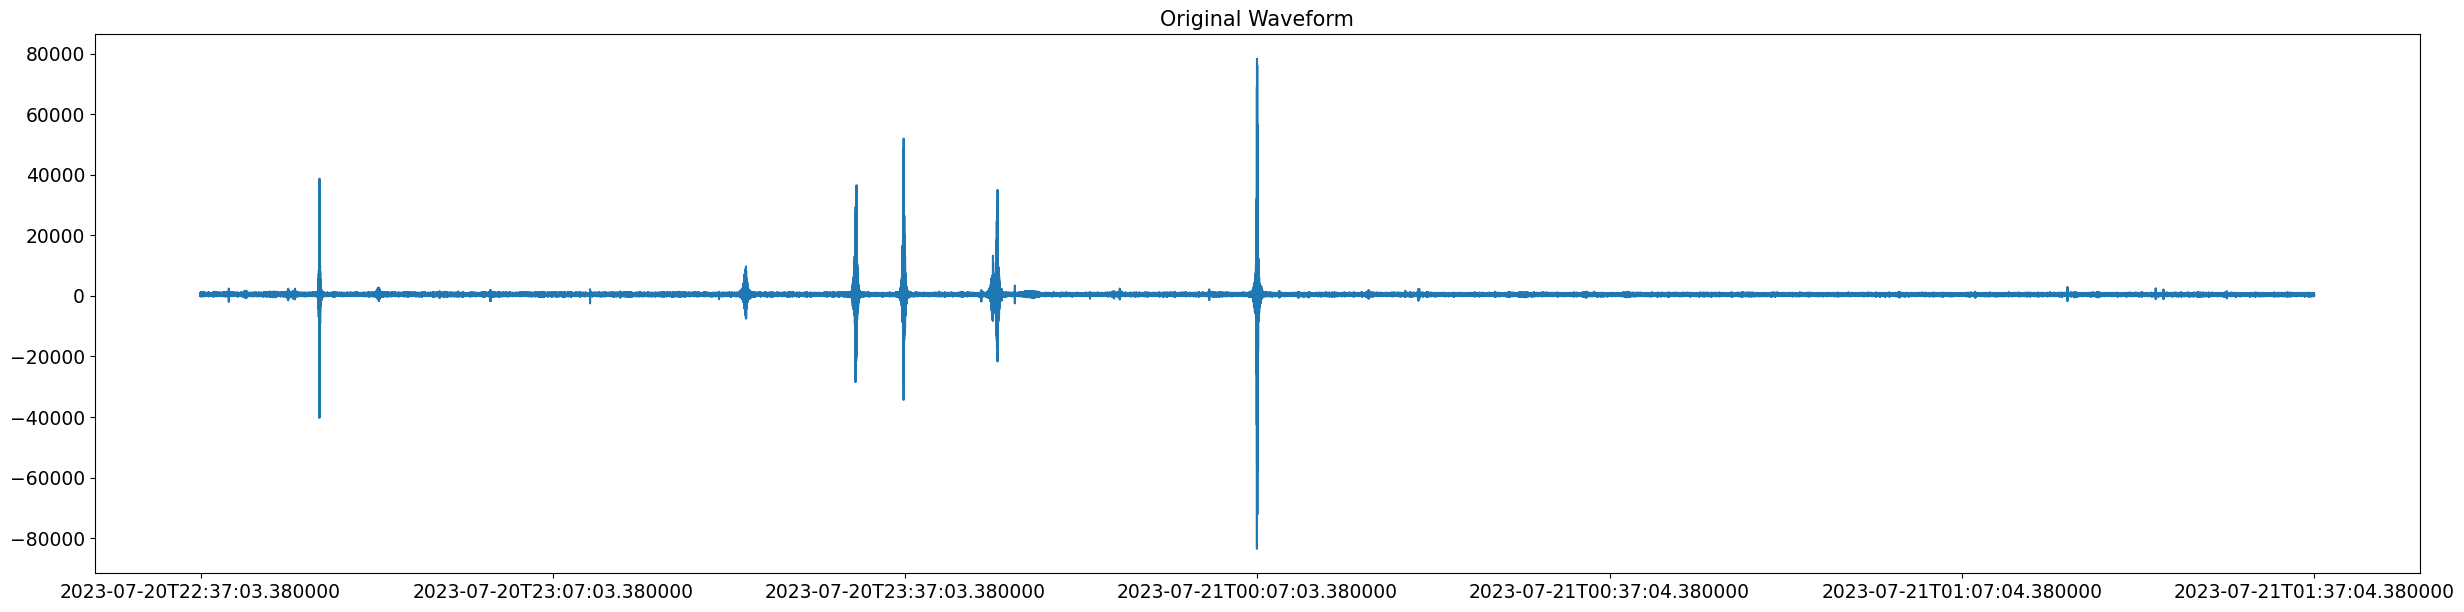

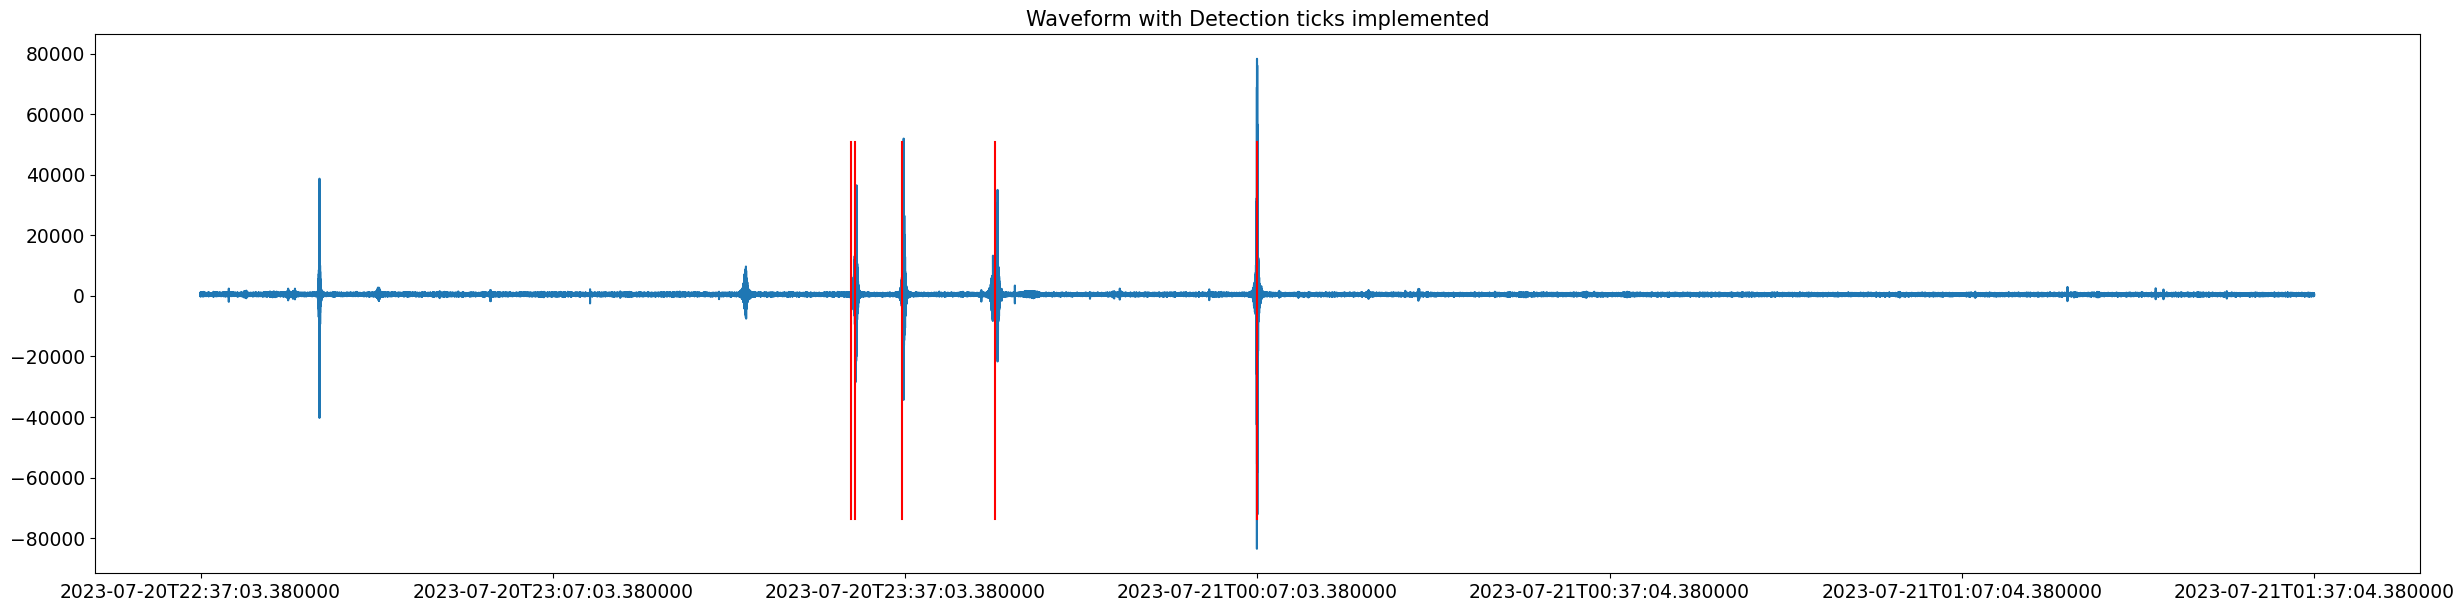

5

In [77]:
plt.figure(figsize=(30,7))
plt.plot(streamey3[0].data)
plt.title('Original Waveform', fontsize = 15)
plt.xticks(positions,ticks,fontsize = 13.5)
plt.yticks(fontsize=13.5)
plt.show()
plt.figure(figsize=(30,7))
plt.plot(streamey3[0].data)
plt.title('Waveform with Detection ticks implemented', fontsize = 15)
x = np.arange(len(streamey3[0].data))
plt.xticks(positions,ticks,fontsize = 13.5)
for index in index_list:
    plt.axvline(x=index,ymin=0.1,ymax=0.8,lw=1.5,color='red')
plt.yticks(fontsize=13.5)
plt.show()
len(index_list)

## Master Function that Reads in a group of Wavefiles, constructs a detector, and detects a stream based on an input parameter, and plots the results.

### Note: The subspace detector and detector schemes might have to be altered based on what type of waveforms you are trying to detect. Main variables to play with: In detector.contstruct -> lowcut, highcut, reject. In detector.detect -> threshold, trig_int. Other variables -> threshhold. Also play around with detector.partition! Possibly the most important one

In [94]:
def super_detector(wave_dir,test_stream):
    #Read in the wavefiles and the test_stream. Strip the test stream of its stats and convert back to a Stream.
    #We strip it of its stats so that the index-finder function can properly work. 
    wavefiles = glob.glob(f'{wave_dir}/*')
    streamey = read(test_stream)
    streamey_stripped = Stream(Trace(streamey[0].data))
    streamey_stripped[0].stats.sampling_rate = 100
    streams = [read(w) for w in wavefiles]
    streamz = []
    #Condense the wavefile stream data and strip stats. Set sampling_rate back to 100
    for st in streams:
        new_st = Stream(Trace(np.array(st[0][400:799].data)))
        new_st[0].stats.sampling_rate = 100
        streamz.append(new_st)
    #Initialize a subspace detector and construct it using the condensed wavefiles 
    detector = subspace.Detector()
    # Channels must all be the same length
    detector.construct(streams=streamz, lowcut=3, highcut=12, filt_order=4,
                        sampling_rate=100, multiplex=False, name='Test_1',
                        align=True,shift_len=1, reject=0.15) # ->EXP
    #partition the detector 
    detector.partition(2)
    #Use the detector on the test_stream. Extract the detections from it. Print out the total amount of detections. 
    detections = detector.detect(st=streamey_stripped, threshold=0.375,trig_int=20,extract_detections=True) # ->EXP
    print(f'Total detections made: {len(detections[0])}')
    #Filter out the 'False' detections that do not meet or exceed the common amplitude of the waveforms we are trying to detect. 
    trimmed_detections = []
    trimmed_detection_info = []
    for i,detection in enumerate(detections[1]):
        tr = detection[0].data
        threshhold = 5000
        if np.max(tr) > threshhold:
            new_tr = Stream(Trace(tr))
            new_tr[0].stats.sampling_rate = 100
            #Filtering is done by adding the adequete waveforms to a new list. The info accompanying 
            #These detections is also saved in a new list. 
            trimmed_detections.append((new_tr))
            trimmed_detection_info.append(detections[0][i]) 
    #Use the index finder on the saved detections and add all indeces (Sample #s) to the index list. 
    index_list = []
    for detection in trimmed_detection_info:
        index  = index_finder2(detection)
        index_list.append(index)
    tr2 = streamey[0]
    #Find the difference in time between the stream's beginning and end
    diff = tr2.stats.endtime - tr2.stats.starttime
    ticks = []
    positions = []
    #Make an increment variable
    increment = diff/6
    #Calculate an add on which will be time added for each tick on the plots. The positions list will hold each add_on in terms of sample #
    for i in range(7):
        add_on = int(increment*i)
        positions.append(add_on*100)
        new_tick = np.datetime64(tr2.stats.starttime) + np.timedelta64(add_on,'s')
        ticks.append(new_tick)
    #make a figure with the original waveform only with timestamps included
    plt.figure(figsize=(30,7))
    plt.plot(streamey[0].data)
    plt.title('Original Waveform', fontsize = 15)
    plt.xticks(positions,ticks,fontsize = 13.5)
    plt.yticks(fontsize=13.5)
    plt.show()
    #Duplicate the figure but this time, add in the detection markers. 
    plt.figure(figsize=(30,7))
    plt.plot(streamey[0].data)
    plt.title('Waveform with Detection ticks implemented', fontsize = 15)
    plt.xticks(positions,ticks,fontsize = 13.5)
    for index in index_list:
        plt.axvline(x=index,ymin=0.1,ymax=0.8,lw=1.5,color='red')
    plt.yticks(fontsize=13.5)
    plt.legend(['Waveform','Detection Markers'], fontsize = 15)
    plt.show()
    return detector

Total detections made: 10
Detection on template: Test_1 at: 1970-01-01T00:55:25.810000Z with 1 channels: [('', '')]
332500
Detection on template: Test_1 at: 1970-01-01T00:55:46.580000Z with 1 channels: [('', '')]
334600
Detection on template: Test_1 at: 1970-01-01T00:59:45.030000Z with 1 channels: [('', '')]
358500
Detection on template: Test_1 at: 1970-01-01T01:07:42.280000Z with 1 channels: [('', '')]
406200
Detection on template: Test_1 at: 1970-01-01T01:29:59.290000Z with 1 channels: [('', '')]
539900


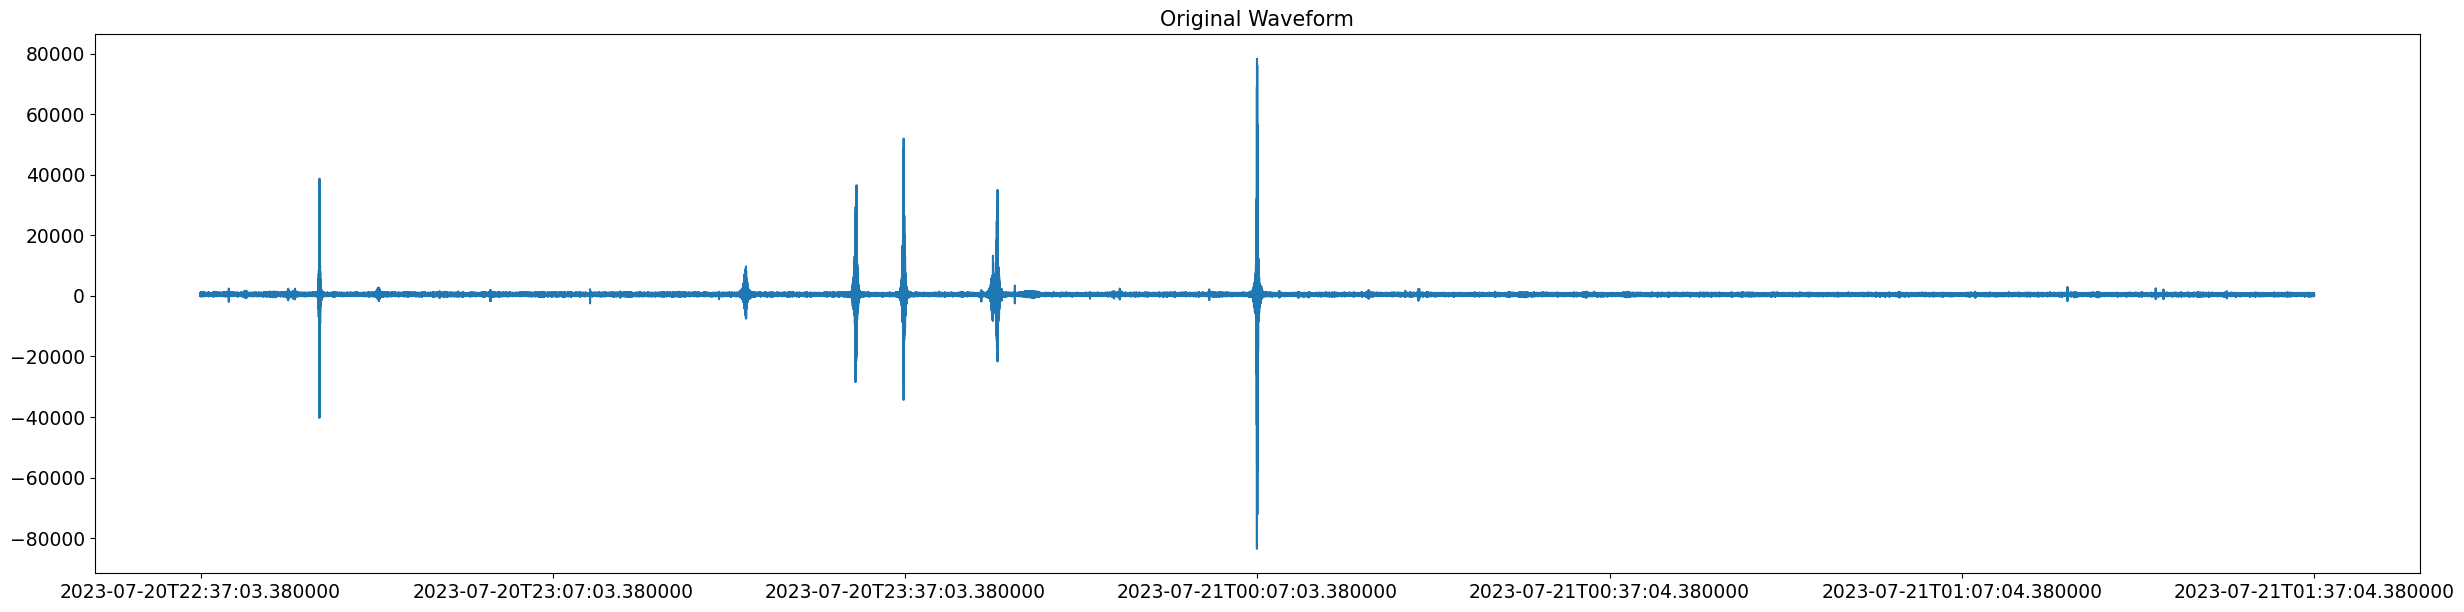

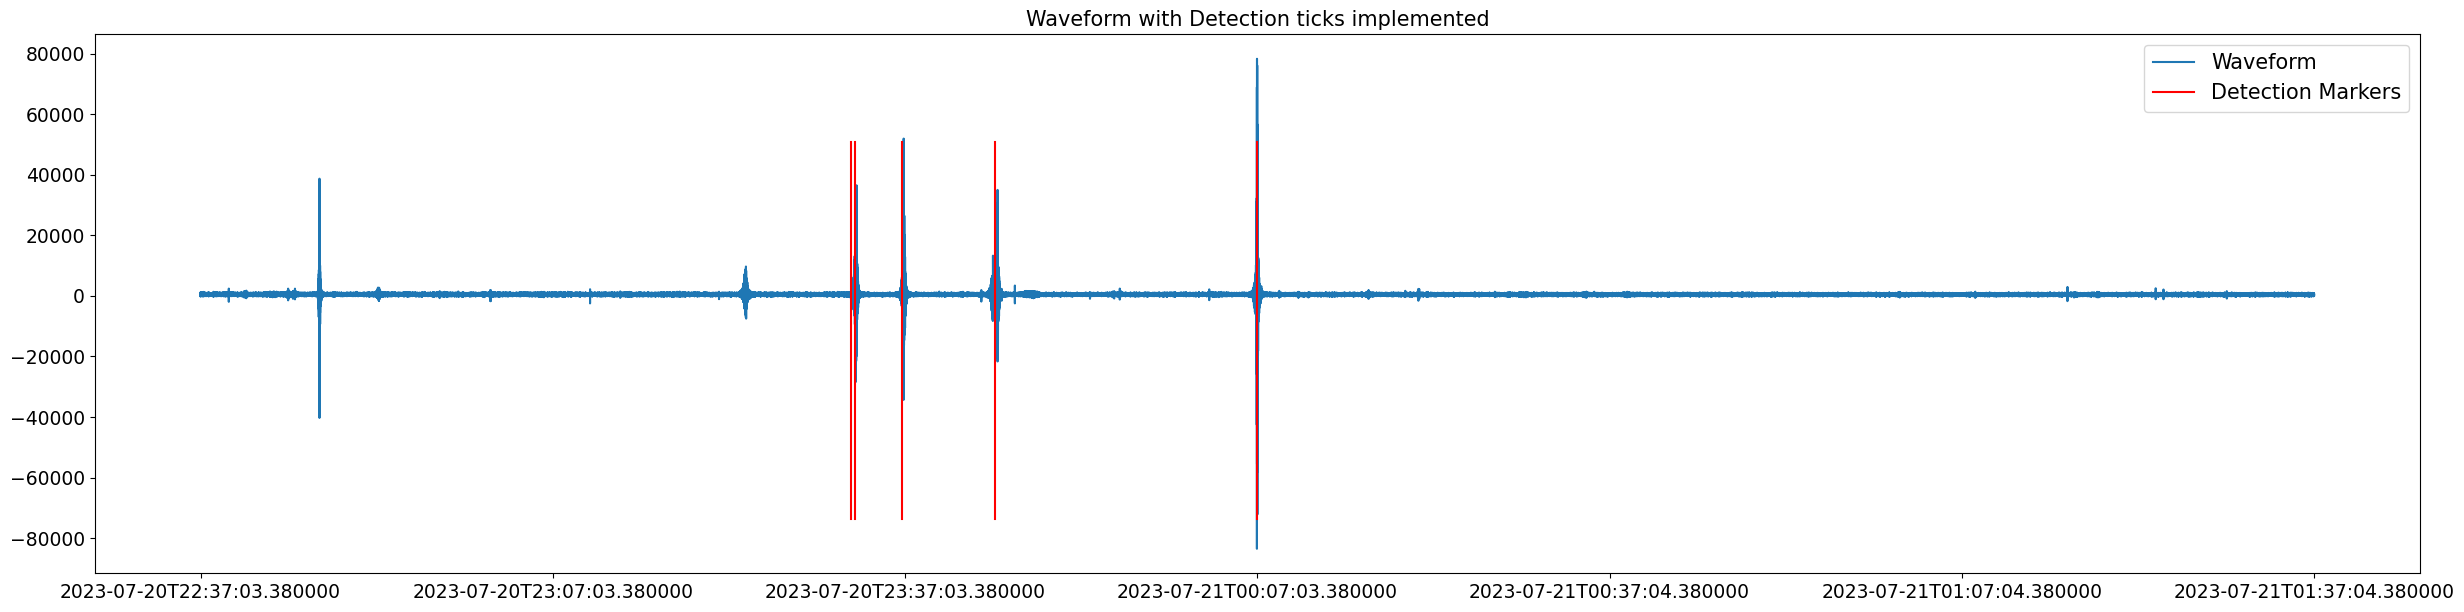

In [95]:
detector = super_detector('Truck_waves_clipped2','Test_dir/NORM_HHZ_RE_34_Test3.mseed')